<a href="https://colab.research.google.com/github/dldustnvn/covid19-Rt/blob/main/Rt_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#데이터 불러오기

In [ ]:
import pandas as pd
import numpy as np
import os
import datetime as dt
import seaborn as sns
from scipy.signal import savgol_filter
import itertools
import matplotlib.pyplot as plt
import re

##확진자 data

In [ ]:
df_covid=pd.read_excel('/content/drive/MyDrive/통계 학부 연구/covid_data.xlsx')
df_covid=df_covid.drop(['import'],axis=1)
df_covid

date  local
0   2020-05-01      1
1   2020-05-02      0
2   2020-05-03      3
3   2020-05-04      0
4   2020-05-05      0
..         ...    ...
559 2021-11-11   2494
560 2021-11-12   2358
561 2021-11-13   2310
562 2021-11-14   2401
563 2021-11-15   1986

[564 rows x 2 columns]

<AxesSubplot:>

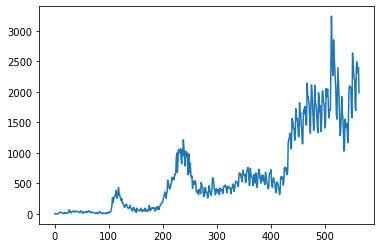

In [ ]:
df_covid['local'].plot()

##Wallinga data

In [ ]:
df_wallinga=pd.read_excel('/content/drive/MyDrive/통계 학부 연구/Data_infector_infectee_0810.xlsx')

다른 Rt와 시기를 어느정도 맞추기 위해 시작 지점과 끝지점 index를 결정하기 위한 것

In [ ]:
# 다른 Rt와 시기를 맞추기 위해 - 시작 지점
df_wallinga.index[df_wallinga['신고일'] == '2020-07-01']

Int64Index([2341, 2344, 2348, 2349, 2350, 2352, 2353, 2354, 2355, 2356, 2357,
            2358, 2360, 2361, 2362, 2364, 2366, 2374],
           dtype='int64')

In [ ]:
# 다른 Rt와 시기를 맞추기 위해 - 끝 지점
df_wallinga.index[df_wallinga['신고일'] == '2020-11-15']

Int64Index([8446, 8448, 8453, 8454, 8455, 8462, 8463, 8464, 8465, 8468,
            ...
            8673, 8674, 8695, 8721, 8722, 8723, 8795, 8796, 8812, 8857],
           dtype='int64', length=151)

In [ ]:
# 원본 저장
# 국내 값만 가져옴
df_wallinga=df_wallinga[df_wallinga.감염경로=='국내']

# NaN 값 제거
df_wallinga=df_wallinga.dropna()

# 다른 Rt와 시기를 맞춰 진행, 끝지점의 제일 첫번째 부분을 추출한 이유는 날짜가 뒤죽박죽이라 뒤에 날짜가 너무 많이 나와서 끊음
df_wallinga=df_wallinga.loc[2341:8446,:].copy()

# 국내 값만 가져옴
df_wallinga=df_wallinga[df_wallinga.감염경로=='국내']

# NaN 값 제거
df_wallinga=df_wallinga.dropna()

# 다른 Rt와 시기를 맞춰 진행, 끝지점의 제일 첫번째 부분을 추출한 이유는 날짜가 뒤죽박죽이라 뒤에 날짜가 너무 많이 나와서 끊음
df_wallinga=df_wallinga.loc[2341:8446,:]

In [ ]:
df_wallinga

id         신고일 감염경로  선행확진id
2341  12862  2020-07-01   국내  #12555
2342  12863  2020-06-30   국내  #12784
2343  12864  2020-06-30   국내  #12395
2344  12867  2020-07-01   국내  #12826
2345  12868  2020-06-30   국내  #12839
...     ...         ...  ...     ...
8442  28575  2020-11-14   국내  #28512
8443  28576  2020-11-14   국내  #28512
8444  28577  2020-11-14   국내  #28507
8445  28578  2020-11-14   국내  #28507
8446  28580  2020-11-15   국내  #27897

[6099 rows x 4 columns]

##변이 데이터

In [ ]:
# 변이 비율 데이터
df_variant=pd.read_excel('/content/drive/MyDrive/통계 학부 연구/df_combine_0908.xlsx',sheet_name='variants')
df_variant=df_variant[df_variant['city']=='total']
df_variant['others']=df_variant[['-','BLANK','Beta','Alpha','Gamma','Kappa','Epsilon','Eta','Iota','Mu']].sum(axis=1)
df_variant=df_variant.drop(['city','-','BLANK','Beta','Alpha','Gamma','Kappa','Epsilon','Eta','Iota','Mu'],axis=1)
df_variant.rename(columns = {'Unnamed: 0':'date'},inplace=True) # column에 이름 설정
df_variant=df_variant.set_index('date') # 날짜 데이터에 이름 설정
df_variant

Delta  Omicron  others
date                              
2020-01-06    1.0      0.0     0.0
2020-01-07    0.0      0.0     0.0
2020-01-08    0.0      0.0     0.0
2020-01-09    0.0      0.0     0.0
2020-01-10    0.0      0.0     0.0
...           ...      ...     ...
2022-08-17    0.0      1.0     0.0
2022-08-18    0.0      1.0     0.0
2022-08-19    0.0      1.0     0.0
2022-08-20    0.0      1.0     0.0
2022-08-21    0.0      1.0     0.0

[959 rows x 3 columns]

In [ ]:
# 전체 확진자 수 데이터
df_case=pd.read_excel('/content/drive/MyDrive/통계 학부 연구/df_combine_0908.xlsx')
df_case=df_case.set_index('보도일') # 날짜 데이터에 이름 설정
df_case=df_case.drop(['0-19','20-34','35-49','50-64','65+'],axis=1)
df_case.index=df_case.index.strftime('%Y-%m-%d') # datetime -> string으로 변경(merge하기 위해 type을 맞춤)
df_case

total
보도일              
2020-01-30      1
2020-01-31      3
2020-02-01      0
2020-02-02      1
2020-02-03      0
...           ...
2022-07-01   9382
2022-07-02  10542
2022-07-03   9868
2022-07-04   6089
2022-07-05  17976

[888 rows x 1 columns]

In [ ]:
df_variants=pd.merge(df_variant,df_case,left_index=True,right_index=True)
df_variants=pd.DataFrame(df_variants)
df_variants['Delta_p']=df_variants['Delta']*df_variants['total']
df_variants['Omicron_p']=df_variants['Omicron']*df_variants['total']
df_variants['Others_p']=df_variants['others']*df_variants['total']
df_variants

Delta  Omicron  others  total  Delta_p  Omicron_p  Others_p
2020-01-30    0.0      0.0     1.0      1      0.0        0.0       1.0
2020-01-31    0.0      0.0     1.0      3      0.0        0.0       3.0
2020-02-01    0.0      0.0     1.0      0      0.0        0.0       0.0
2020-02-02    0.0      0.0     1.0      1      0.0        0.0       1.0
2020-02-03    0.0      0.0     0.0      0      0.0        0.0       0.0
...           ...      ...     ...    ...      ...        ...       ...
2022-07-01    0.0      1.0     0.0   9382      0.0     9382.0       0.0
2022-07-02    0.0      1.0     0.0  10542      0.0    10542.0       0.0
2022-07-03    0.0      1.0     0.0   9868      0.0     9868.0       0.0
2022-07-04    0.0      1.0     0.0   6089      0.0     6089.0       0.0
2022-07-05    0.0      1.0     0.0  17976      0.0    17976.0       0.0

[888 rows x 7 columns]

###내삽

In [ ]:
tmp=df_variants[['Delta_p','Omicron_p','Others_p']].replace(0,np.nan) # 내삽을 쓰기 위해 0에서 NaN으로 변경
tmp.index = pd.to_datetime(tmp.index)
tmp=tmp.interpolate(method='cubic', order=2) #내삽
tmp
# 내삽을 진행한 결과 -값이 나오는 것을 확인 -> 여기서 0처리 하면 내삽 전과 같은 그래프가 나와 Rt를 구한 후 할 예정
tmp=tmp.replace(np.nan,0) #Rt 계산하기 위해 NaN을 다시 0으로 바꿈
tmp=round(tmp) # 확진자수이기 때문에 반올림
df_cases=tmp
df_cases

Delta_p  Omicron_p  Others_p
2020-01-30      0.0        0.0       1.0
2020-01-31      0.0        0.0       3.0
2020-02-01      0.0        0.0       2.0
2020-02-02      0.0        0.0       1.0
2020-02-03      0.0        0.0       2.0
...             ...        ...       ...
2022-07-01      0.0     9382.0       0.0
2022-07-02      0.0    10542.0       0.0
2022-07-03      0.0     9868.0       0.0
2022-07-04      0.0     6089.0       0.0
2022-07-05      0.0    17976.0       0.0

[888 rows x 3 columns]

<AxesSubplot:>

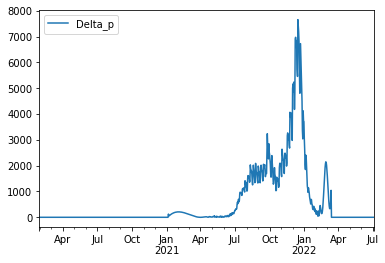

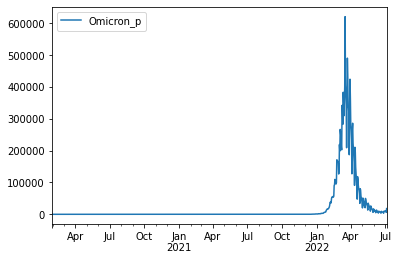

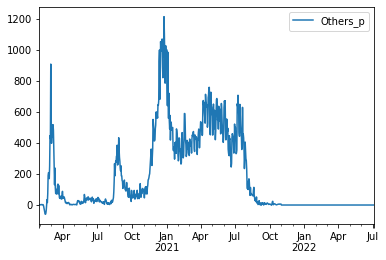

In [ ]:
df_cases.plot(y=['Delta_p'])
df_cases.plot(y=['Omicron_p'])
df_cases.plot(y=['Others_p'])

##부트스트랩 데이터

In [ ]:
df_all=pd.read_excel("/content/drive/MyDrive/통계 학부 연구/Rt 전체.xlsx",sheet_name="Sheet1")
df_delta=pd.read_excel("/content/drive/MyDrive/통계 학부 연구/Rt 전체.xlsx",sheet_name="delta")
df_omicron=pd.read_excel("/content/drive/MyDrive/통계 학부 연구/Rt 전체.xlsx",sheet_name="omicron")
df_others=pd.read_excel("/content/drive/MyDrive/통계 학부 연구/Rt 전체.xlsx",sheet_name="others")

In [ ]:
df_all.rename(columns = {'Unnamed: 0':'date'},inplace=True)
df_all=df_all.set_index('date')
df_delta.rename(columns = {'Unnamed: 0':'date'},inplace=True)
df_delta=df_delta.set_index('date')
df_omicron.rename(columns = {'Unnamed: 0':'date'},inplace=True)
df_omicron=df_omicron.set_index('date')
df_others.rename(columns = {'Unnamed: 0':'date'},inplace=True)
df_others=df_others.set_index('date')

##해외 변이 데이터

###함수

In [ ]:
def make_data(variant_name):
  data=pd.read_excel('/content/drive/MyDrive/통계 학부 연구/world_varient.xlsx',sheet_name=variant_name)
  data['omicron']=data[['cluster_counts/21K (Omicron)','cluster_counts/21L (Omicron)','cluster_counts/22A (Omicron)','cluster_counts/22B (Omicron)','cluster_counts/22C (Omicron)','cluster_counts/22D (Omicron)']].sum(axis=1)
  data['delta']=data[['cluster_counts/21A (Delta)','cluster_counts/21I (Delta)','cluster_counts/21J (Delta)']].sum(axis=1)
  data['others']=data['total_sequences']-data['omicron']-data['delta']
  data=data.set_index('week')
  data=data[['delta','omicron','others','total_sequences']]
  data['delta_p']=data['delta']/data['total_sequences'] # 변이 비율
  data['omicron_p']=data['omicron']/data['total_sequences']
  data['others_p']=data['others']/data['total_sequences']
  return data

###일본

In [ ]:
df_japan=make_data('Japan_varient')
df_japan

delta  omicron  others  total_sequences  delta_p  omicron_p  \
week                                                                      
2020-04-27      0        0     421              421      0.0        0.0   
2020-05-11      0        0     117              117      0.0        0.0   
2020-05-25      0        0     149              149      0.0        0.0   
2020-06-08      0        0     191              191      0.0        0.0   
2020-06-22      0        0     389              389      0.0        0.0   
...           ...      ...     ...              ...      ...        ...   
2022-07-18      0    21542       0            21542      0.0        1.0   
2022-08-01      0    13445       0            13445      0.0        1.0   
2022-08-15      0    10398       0            10398      0.0        1.0   
2022-08-29      0     5965       0             5965      0.0        1.0   
2022-09-12      0      936       0              936      0.0        1.0   

            others_p  
week                  
2020-04-27       1.0  
2020-05-11       1.0  
2020-05-25       1.0  
2020-06-08       1.0  
2020-06-22       1.0  
...              ...  
2022-07-18       0.0  
2022-08-01       0.0  
2022-08-15       0.0  
2022-08-29       0.0  
2022-09-12       0.0  

[63 rows x 7 columns]

###캐나다

In [ ]:
df_canada=make_data('Canada_varient')
df_canada

delta  omicron  others  total_sequences  delta_p  omicron_p  \
week                                                                      
2020-04-27      0        0     946              946      0.0   0.000000   
2020-05-11      0        0     623              623      0.0   0.000000   
2020-05-25      0        0     213              213      0.0   0.000000   
2020-06-08      0        0     204              204      0.0   0.000000   
2020-06-22      0        0     112              112      0.0   0.000000   
...           ...      ...     ...              ...      ...        ...   
2022-07-18      0     6616       0             6616      0.0   1.000000   
2022-08-01      0     6603       2             6605      0.0   0.999697   
2022-08-15      0     6761       2             6763      0.0   0.999704   
2022-08-29      0     5135      10             5145      0.0   0.998056   
2022-09-12      0     2255       0             2255      0.0   1.000000   

            others_p  
week                  
2020-04-27  1.000000  
2020-05-11  1.000000  
2020-05-25  1.000000  
2020-06-08  1.000000  
2020-06-22  1.000000  
...              ...  
2022-07-18  0.000000  
2022-08-01  0.000303  
2022-08-15  0.000296  
2022-08-29  0.001944  
2022-09-12  0.000000  

[63 rows x 7 columns]

###이탈리아

In [ ]:
df_italy=make_data('Italy_varient')
df_italy

delta  omicron  others  total_sequences  delta_p  omicron_p  \
week                                                                      
2020-04-27      0        0     111              111      0.0        0.0   
2020-05-11      0        0      49               49      0.0        0.0   
2020-05-25      0        0      35               35      0.0        0.0   
2020-06-08      0        0      50               50      0.0        0.0   
2020-06-22      0        0     107              107      0.0        0.0   
...           ...      ...     ...              ...      ...        ...   
2022-08-01      0     2088       0             2088      0.0        1.0   
2022-08-15      0      687       0              687      0.0        1.0   
2022-08-29      0     1007       0             1007      0.0        1.0   
2022-09-12      0      596       0              596      0.0        1.0   
2022-09-26      0       16       0               16      0.0        1.0   

            others_p  
week                  
2020-04-27       1.0  
2020-05-11       1.0  
2020-05-25       1.0  
2020-06-08       1.0  
2020-06-22       1.0  
...              ...  
2022-08-01       0.0  
2022-08-15       0.0  
2022-08-29       0.0  
2022-09-12       0.0  
2022-09-26       0.0  

[64 rows x 7 columns]

###미국

In [ ]:
df_usa=make_data('USA_varient')
df_usa

delta  omicron  others  total_sequences   delta_p  omicron_p  \
week                                                                       
2020-04-27      0        0    6024             6024  0.000000   0.000000   
2020-05-11      0        0    5080             5080  0.000000   0.000000   
2020-05-25      0        0    4709             4709  0.000000   0.000000   
2020-06-08      0        0    6580             6580  0.000000   0.000000   
2020-06-22      0        0    8507             8507  0.000000   0.000000   
...           ...      ...     ...              ...       ...        ...   
2022-07-18      1    71400      99            71500  0.000014   0.998601   
2022-08-01      0    60664      78            60742  0.000000   0.998716   
2022-08-15      1    56229     136            56366  0.000018   0.997569   
2022-08-29      1    44215     221            44437  0.000023   0.995004   
2022-09-12      1    41625     665            42291  0.000024   0.984252   

            others_p  
week                  
2020-04-27  1.000000  
2020-05-11  1.000000  
2020-05-25  1.000000  
2020-06-08  1.000000  
2020-06-22  1.000000  
...              ...  
2022-07-18  0.001385  
2022-08-01  0.001284  
2022-08-15  0.002413  
2022-08-29  0.004973  
2022-09-12  0.015724  

[63 rows x 7 columns]

###영국

In [ ]:
df_uk=make_data('UK_varient')
df_uk

delta  omicron  others  total_sequences  delta_p  omicron_p  \
week                                                                      
2020-04-27      0        0    4667             4667      0.0        0.0   
2020-05-11      0        0    2715             2715      0.0        0.0   
2020-05-25      0        0    1719             1719      0.0        0.0   
2020-06-08      0        0    4681             4681      0.0        0.0   
2020-06-22      0        0    2274             2274      0.0        0.0   
...           ...      ...     ...              ...      ...        ...   
2022-07-18      0    16729       0            16729      0.0        1.0   
2022-08-01      0    10541       0            10541      0.0        1.0   
2022-08-15      0     6597       0             6597      0.0        1.0   
2022-08-29      0     5308       0             5308      0.0        1.0   
2022-09-12      0     2729       0             2729      0.0        1.0   

            others_p  
week                  
2020-04-27       1.0  
2020-05-11       1.0  
2020-05-25       1.0  
2020-06-08       1.0  
2020-06-22       1.0  
...              ...  
2022-07-18       0.0  
2022-08-01       0.0  
2022-08-15       0.0  
2022-08-29       0.0  
2022-09-12       0.0  

[63 rows x 7 columns]

###독일

In [ ]:
df_ger=make_data('Germany_varient')
df_ger

delta  omicron  others  total_sequences   delta_p  omicron_p  \
week                                                                       
2020-04-27      0        0      94               94  0.000000   0.000000   
2020-05-11      0        0      86               86  0.000000   0.000000   
2020-05-25      0        0      67               67  0.000000   0.000000   
2020-06-08      0        0    1364             1364  0.000000   0.000000   
2020-06-22      0        0     323              323  0.000000   0.000000   
...           ...      ...     ...              ...       ...        ...   
2022-07-18      0    13578       2            13580  0.000000   0.999853   
2022-08-01      0     9236       0             9236  0.000000   1.000000   
2022-08-15      0     8696       0             8696  0.000000   1.000000   
2022-08-29      7     9292       4             9303  0.000752   0.998818   
2022-09-12      7     3745       2             3754  0.001865   0.997603   

            others_p  
week                  
2020-04-27  1.000000  
2020-05-11  1.000000  
2020-05-25  1.000000  
2020-06-08  1.000000  
2020-06-22  1.000000  
...              ...  
2022-07-18  0.000147  
2022-08-01  0.000000  
2022-08-15  0.000000  
2022-08-29  0.000430  
2022-09-12  0.000533  

[63 rows x 7 columns]

###프랑스

In [ ]:
df_fra=make_data('France_varient')
df_fra

delta  omicron  others  total_sequences   delta_p  omicron_p  \
week                                                                       
2020-04-27      0        0     195              195  0.000000   0.000000   
2020-05-11      0        0      58               58  0.000000   0.000000   
2020-05-25      0        0      30               30  0.000000   0.000000   
2020-06-08      0        0      43               43  0.000000   0.000000   
2020-06-22      0        0      28               28  0.000000   0.000000   
...           ...      ...     ...              ...       ...        ...   
2022-07-18      2     8919       0             8921  0.000224   0.999776   
2022-08-01      0     4998       0             4998  0.000000   1.000000   
2022-08-15      0     4118       0             4118  0.000000   1.000000   
2022-08-29      0     3760       0             3760  0.000000   1.000000   
2022-09-12      0     1580       0             1580  0.000000   1.000000   

            others_p  
week                  
2020-04-27       1.0  
2020-05-11       1.0  
2020-05-25       1.0  
2020-06-08       1.0  
2020-06-22       1.0  
...              ...  
2022-07-18       0.0  
2022-08-01       0.0  
2022-08-15       0.0  
2022-08-29       0.0  
2022-09-12       0.0  

[63 rows x 7 columns]

#Rt 방법 세가지

##내장 함수

In [ ]:
import os

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

%matplotlib inline

from scipy.stats import gamma, poisson

!pip3 install epyestim

import epyestim
import epyestim.covid19 as covid19

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
si_distrb = covid19.generate_standard_si_distribution()
delay_distrb = covid19.generate_standard_infection_to_reporting_distribution()

####기존 Rt

In [ ]:
ch_cases = pd.read_excel(
    os.path.join('', '/content/drive/MyDrive/통계 학부 연구/covid_data.xlsx'),
    parse_dates=['date']
).set_index('date')['local']

ch_cases

date
2020-05-01       1
2020-05-02       0
2020-05-03       3
2020-05-04       0
2020-05-05       0
              ... 
2021-11-11    2494
2021-11-12    2358
2021-11-13    2310
2021-11-14    2401
2021-11-15    1986
Name: local, Length: 564, dtype: int64

In [ ]:
ch_cases.index

DatetimeIndex(['2020-05-01', '2020-05-02', '2020-05-03', '2020-05-04',
               '2020-05-05', '2020-05-06', '2020-05-07', '2020-05-08',
               '2020-05-09', '2020-05-10',
               ...
               '2021-11-06', '2021-11-07', '2021-11-08', '2021-11-09',
               '2021-11-10', '2021-11-11', '2021-11-12', '2021-11-13',
               '2021-11-14', '2021-11-15'],
              dtype='datetime64[ns]', name='date', length=564, freq=None)

In [ ]:
ch_time_varying_r = covid19.r_covid(ch_cases,gt_distribution=si_distrb)
ch_time_varying_r.tail()

cases    R_mean     R_var    Q0.025      Q0.5    Q0.975
2021-11-01  1664.0  1.051085  0.000154  1.026953  1.051037  1.075487
2021-11-02  1578.0  1.025349  0.000146  1.001731  1.025301  1.049200
2021-11-03  2640.0  1.008607  0.000142  0.985325  1.008560  1.032102
2021-11-04  2457.0  0.999038  0.000140  0.976023  0.998991  1.022375
2021-11-05  2322.0  0.993450  0.000138  0.970462  0.993403  1.016736

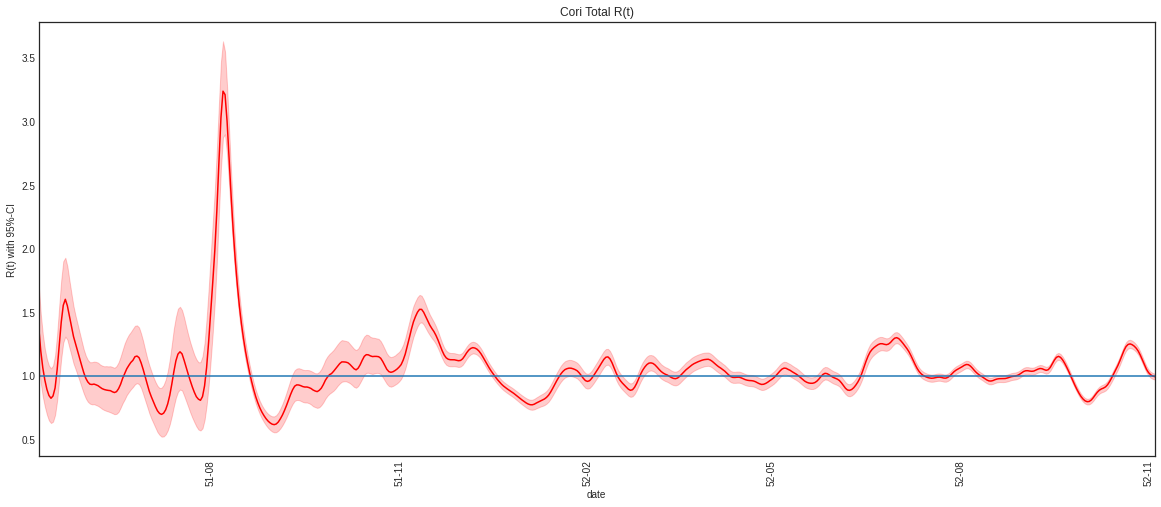

In [ ]:
# 파이썬 내장 함수
import matplotlib.dates as mdates
fig, ax = plt.subplots(1,1, figsize=(20, 8))

ch_time_varying_r.loc[:,'Q0.5'].plot(ax=ax, color='red')
ax.fill_between(ch_time_varying_r.index,
                    ch_time_varying_r['Q0.025'],
                    ch_time_varying_r['Q0.975'],
                    color='red', alpha=0.2)
ax.set_xlabel('date')
ax.set_ylabel('R(t) with 95%-CI')
#ax.set_ylim([0,3])
ax.axhline(y=1)
ax.set_title('Cori Total R(t)')
ax.set_xticklabels(ch_cases.index,rotation=90)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
dateFmt = mdates.DateFormatter('%Y-%m')
ax.xaxis.set_major_formatter(dateFmt)
plt.show()

####Delta

In [ ]:
ch_cases=df_cases['Delta_p'].loc['2021-04-08':'2022-03-13']
ch_cases

2021-04-08       9.0
2021-04-09      12.0
2021-04-10      15.0
2021-04-11      17.0
2021-04-12      19.0
               ...  
2022-03-09     341.0
2022-03-10     331.0
2022-03-11     432.0
2022-03-12     664.0
2022-03-13    1045.0
Name: Delta_p, Length: 340, dtype: float64

In [ ]:
ch_cases.index = pd.to_datetime(ch_cases.index)
ch_time_varying_r = covid19.r_covid(ch_cases,gt_distribution=si_distrb)
ch_time_varying_r.tail()

cases    R_mean     R_var    Q0.025      Q0.5    Q0.975
2022-02-27  2150.0  0.553450  0.000083  0.535660  0.553400  0.571526
2022-02-28  2126.0  0.457617  0.000074  0.440807  0.457563  0.474738
2022-03-01  2015.0  0.381936  0.000070  0.365675  0.381875  0.398546
2022-03-02  1835.0  0.324110  0.000070  0.307818  0.324037  0.340817
2022-03-03  1608.0  0.282976  0.000075  0.266212  0.282888  0.300153

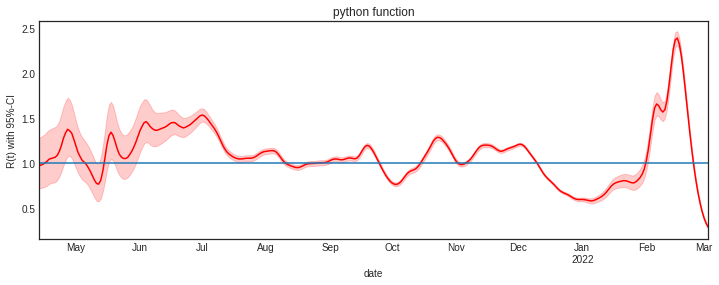

In [ ]:
# 파이썬 내장 함수
fig, ax = plt.subplots(1,1, figsize=(12, 4))

ch_time_varying_r.loc[:,'Q0.5'].plot(ax=ax, color='red')
ax.fill_between(ch_time_varying_r.index,
                    ch_time_varying_r['Q0.025'],
                    ch_time_varying_r['Q0.975'],
                    color='red', alpha=0.2)
ax.set_xlabel('date')
ax.set_ylabel('R(t) with 95%-CI')
#ax.set_ylim([0,3])
ax.axhline(y=1)
ax.set_title('python function')
plt.show()

####Omicron

In [ ]:
ch_cases=df_cases['Omicron_p'].loc['2021-11-6':'2022-7-5']
ch_cases

2021-11-06        3.0
2021-11-07        4.0
2021-11-08        4.0
2021-11-09        5.0
2021-11-10        6.0
               ...   
2022-07-01     9382.0
2022-07-02    10542.0
2022-07-03     9868.0
2022-07-04     6089.0
2022-07-05    17976.0
Name: Omicron_p, Length: 242, dtype: float64

In [ ]:
ch_cases.index = pd.to_datetime(ch_cases.index)
ch_time_varying_r = covid19.r_covid(ch_cases,gt_distribution=si_distrb)
ch_time_varying_r.tail()

cases    R_mean     R_var    Q0.025      Q0.5    Q0.975
2022-06-21  9228.0  1.129386  0.000059  1.114365  1.129369  1.144507
2022-06-22  8876.0  1.202345  0.000062  1.186968  1.202328  1.217819
2022-06-23  7402.0  1.298526  0.000065  1.282734  1.298510  1.314414
2022-06-24  7107.0  1.392762  0.000067  1.376807  1.392746  1.408807
2022-06-25  6669.0  1.451115  0.000065  1.435304  1.451100  1.467011

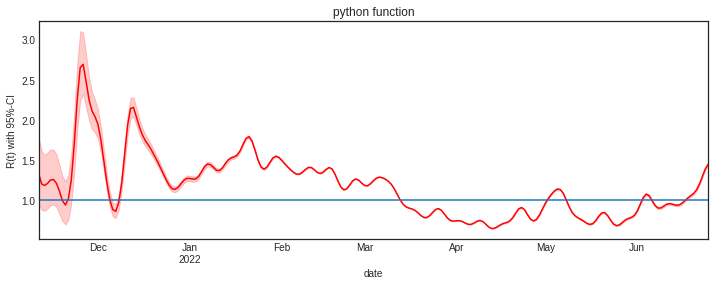

In [ ]:
# 파이썬 내장 함수
fig, ax = plt.subplots(1,1, figsize=(12, 4))

ch_time_varying_r.loc[:,'Q0.5'].plot(ax=ax, color='red')
ax.fill_between(ch_time_varying_r.index,
                    ch_time_varying_r['Q0.025'],
                    ch_time_varying_r['Q0.975'],
                    color='red', alpha=0.2)
ax.set_xlabel('date')
ax.set_ylabel('R(t) with 95%-CI')
#ax.set_ylim([0,3])
ax.axhline(y=1)
ax.set_title('python function')
plt.show()

####Others

In [ ]:
ch_cases=df_cases['Others_p'].loc['2020-3-1':'2021-10-31']
ch_cases[ch_cases<0]=0 # 2021-09-08에 음수가 존재해서 에러가 떠서 처리
ch_cases

2020-03-01    593.0
2020-03-02    398.0
2020-03-03    464.0
2020-03-04    516.0
2020-03-05    437.0
              ...  
2021-10-27      5.0
2021-10-28      6.0
2021-10-29      6.0
2021-10-30      6.0
2021-10-31      6.0
Name: Others_p, Length: 610, dtype: float64

In [ ]:
ch_cases.index = pd.to_datetime(ch_cases.index)
ch_time_varying_r = covid19.r_covid(ch_cases,gt_distribution=si_distrb)
ch_time_varying_r.tail()

cases    R_mean     R_var    Q0.025      Q0.5    Q0.975
2021-10-17    3.0  0.913331  0.065746  0.480260  0.890329  1.482019
2021-10-18    2.0  1.048844  0.085231  0.555415  1.023891  1.698385
2021-10-19    1.0  1.199050  0.104646  0.656425  1.163919  1.917191
2021-10-20    2.0  1.356704  0.122492  0.746433  1.323692  2.118076
2021-10-21    3.0  1.463448  0.134822  0.830315  1.432630  2.244957

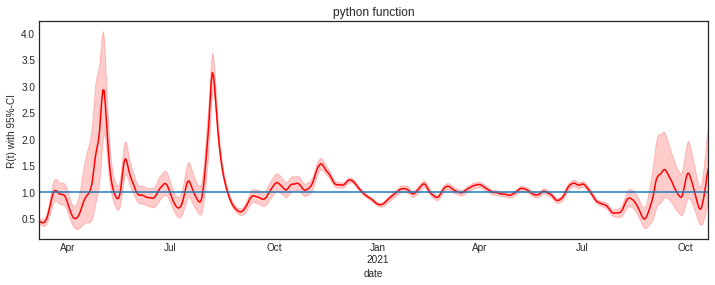

In [ ]:
# 파이썬 내장 함수
fig, ax = plt.subplots(1,1, figsize=(12, 4))

ch_time_varying_r.loc[:,'Q0.5'].plot(ax=ax, color='red')
ax.fill_between(ch_time_varying_r.index,
                    ch_time_varying_r['Q0.025'],
                    ch_time_varying_r['Q0.975'],
                    color='red', alpha=0.2)
ax.set_xlabel('date')
ax.set_ylabel('R(t) with 95%-CI')
#ax.set_ylim([0,3])
ax.axhline(y=1)
ax.set_title('python function')
plt.show()

##cori

###W 함수

In [ ]:
def W(num):
  from numpy import linspace, exp # Cori의 Ws Gamma 분포
  x=linspace(1,num,num) # df의 개수만큼 나눔
  from scipy.special import gamma # gamma 분포 계산
  mu=4.8
  sig=2.3
  shape=mu**2/sig**2
  scale=sig**2/mu
  y=x**(shape-1)*exp(-x/scale)/(scale**shape*gamma(shape))
  W=y
  return W

###Cori 함수

In [ ]:
def Cori(i,data,W):
  a=data.values[i] # I_t
  b=0 # b 초기화
  for k in range(1,i):
    b+=data[i-k]*W[k] # I_t-s * Ws
  if(b>0):
    r=a/b
  else:
    r=0
  return r

###기존 Rt 그래프

In [ ]:
df_covid['W']=W(len(df_covid))
df_covid

date  local              W
0   2020-05-01      1   2.770210e-02
1   2020-05-02      0   1.144243e-01
2   2020-05-03      3   1.800138e-01
3   2020-05-04      0   1.907466e-01
4   2020-05-05      0   1.627648e-01
..         ...    ...            ...
559 2021-11-11   2494  2.401001e-213
560 2021-11-12   2358  9.748223e-214
561 2021-11-13   2310  3.957800e-214
562 2021-11-14   2401  1.606859e-214
563 2021-11-15   1986  6.523743e-215

[564 rows x 3 columns]

In [ ]:
for i in range(1,len(df_covid.index)):
    df_covid.loc[i,'Cori']=Cori(i,df_covid['local'],df_covid['W'])

In [ ]:
df_covid

date  local              W      Cori
0   2020-05-01      1   2.770210e-02       NaN
1   2020-05-02      0   1.144243e-01  0.000000
2   2020-05-03      3   1.800138e-01  0.000000
3   2020-05-04      0   1.907466e-01  0.000000
4   2020-05-05      0   1.627648e-01  0.000000
..         ...    ...            ...       ...
559 2021-11-11   2494  2.401001e-213  1.243435
560 2021-11-12   2358  9.748223e-214  1.148363
561 2021-11-13   2310  3.957800e-214  1.089071
562 2021-11-14   2401  1.606859e-214  1.102904
563 2021-11-15   1986  6.523743e-215  0.893171

[564 rows x 4 columns]

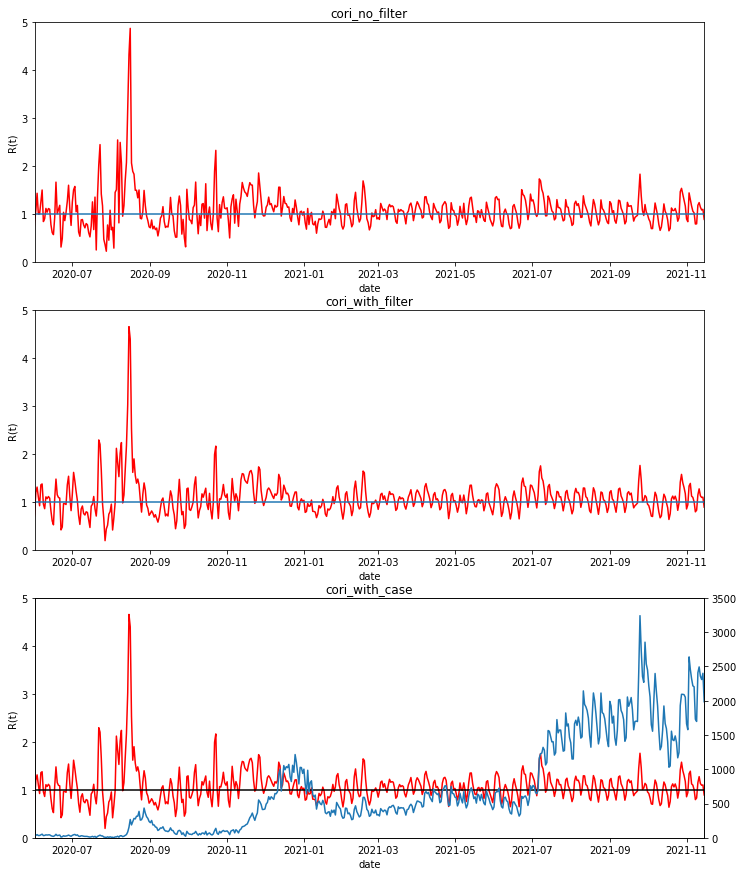

In [ ]:
f, axes = plt.subplots(3, 1)
f.set_size_inches((12, 15))
x=df_covid['date']
y=df_covid['Cori']
yhat=savgol_filter(y,11,9)
# cori_no_filter
axes[0].plot(x,y,'r')
axes[0].axhline(y=1)
axes[0].set_xlim([dt.date(2020,6,1),dt.date(2021,11,15)])
axes[0].set_ylim(0,5)
axes[0].set_xlabel('date')
axes[0].set_ylabel('R(t)')
axes[0].set_title('cori_no_filter')
# cori_with_filter
axes[1].plot(x,yhat,'r')
axes[1].axhline(y=1)
axes[1].set_xlim([dt.date(2020,6,1),dt.date(2021,11,15)])
axes[1].set_ylim(0,5)
axes[1].set_xlabel('date')
axes[1].set_ylabel('R(t)')
axes[1].set_title('cori_with_filter')
# cori_with_case
axes[2].plot(x,yhat,'r')
axes[2].axhline(y=1,color='black')
axes[2].set_xlim([dt.date(2020,6,1),dt.date(2021,11,15)])
axes[2].set_ylim(0,5)
axes[2].set_xlabel('date')
axes[2].set_ylabel('R(t)')
axes[2].set_title('cori_with_case')
ax = axes[2].twinx()
x1=df_covid['date']
y1=df_covid['local']
ax.plot(x1,y1)
ax.set_xlim([dt.date(2020,6,1),dt.date(2021,11,15)])
ax.set_ylim(0,3500)
plt.show()

###변이 Rt 그래프

In [ ]:
# 각 변이 별로 Rt를 계산하는 그래프
cori=[]
for i in range(len(df_cases.columns)):
  temp=[]
  variant=df_cases.iloc[:,i] # 각 변이 그래프를 불러옴
  for j in range(len(variant.index)):
    temp.append(Cori(j,variant,W(len(df_cases))))
  cori.append(temp) # list에 저장

In [ ]:
df_cases

Delta_p  Omicron_p  Others_p
2020-01-30      0.0        0.0       1.0
2020-01-31      0.0        0.0       3.0
2020-02-01      0.0        0.0       2.0
2020-02-02      0.0        0.0       1.0
2020-02-03      0.0        0.0       2.0
...             ...        ...       ...
2022-07-01      0.0     9382.0       0.0
2022-07-02      0.0    10542.0       0.0
2022-07-03      0.0     9868.0       0.0
2022-07-04      0.0     6089.0       0.0
2022-07-05      0.0    17976.0       0.0

[888 rows x 3 columns]

In [ ]:
#단순하게 전체 표본으로 계산할 경우 각 변이가 온전히 반영되지 않아 (각 변이의 Rt)*(해당 변이의 비율)의 합으로 구현
df_variants.index = pd.to_datetime(df_variants.index)
df_variants['Delta_Rt']=cori[0]
df_variants['Omicron_Rt']=cori[1]
df_variants['Others_Rt']=cori[2]
df_variants['Total_Rt']=df_variants['Delta_Rt']*df_variants['Delta']+df_variants['Omicron_Rt']*df_variants['Omicron']+df_variants['Others_Rt']*df_variants['others']
df_variants

Delta  Omicron  others  total  Delta_p  Omicron_p  Others_p  \
2020-01-30    0.0      0.0     1.0      1      0.0        0.0       1.0   
2020-01-31    0.0      0.0     1.0      3      0.0        0.0       3.0   
2020-02-01    0.0      0.0     1.0      0      0.0        0.0       0.0   
2020-02-02    0.0      0.0     1.0      1      0.0        0.0       1.0   
2020-02-03    0.0      0.0     0.0      0      0.0        0.0       0.0   
...           ...      ...     ...    ...      ...        ...       ...   
2022-07-01    0.0      1.0     0.0   9382      0.0     9382.0       0.0   
2022-07-02    0.0      1.0     0.0  10542      0.0    10542.0       0.0   
2022-07-03    0.0      1.0     0.0   9868      0.0     9868.0       0.0   
2022-07-04    0.0      1.0     0.0   6089      0.0     6089.0       0.0   
2022-07-05    0.0      1.0     0.0  17976      0.0    17976.0       0.0   

            Delta_Rt  Omicron_Rt  Others_Rt  Total_Rt  
2020-01-30       0.0    0.000000   0.000000  0.000000  
2020-01-31       0.0    0.000000   0.000000  0.000000  
2020-02-01       0.0    0.000000   5.826270  5.826270  
2020-02-02       0.0    0.000000   1.300576  1.300576  
2020-02-03       0.0    0.000000   1.910783  0.000000  
...              ...         ...        ...       ...  
2022-07-01       0.0    1.247842   0.000000  1.247842  
2022-07-02       0.0    1.303823   0.000000  1.303823  
2022-07-03       0.0    1.143198   0.000000  1.143198  
2022-07-04       0.0    0.674119   0.000000  0.674119  
2022-07-05       0.0    2.028468   0.000000  2.028468  

[888 rows x 11 columns]

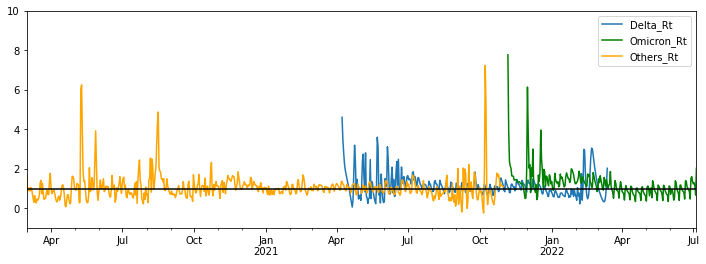

In [ ]:
#import datetime as dt
fig, ax1=plt.subplots(figsize=(12,4))
df_variants['Delta_Rt'].loc['2021-4-8':'2022-3-13'].plot(ax=ax1)
df_variants['Omicron_Rt'].loc['2021-11-6':'2022-7-5'].plot(ax=ax1,color='green')
df_variants['Others_Rt'].loc['2020-3-1':'2021-10-31'].plot(ax=ax1,color='orange')

# 전체 Rt 그래프 : 이거까지 하면 그래프가 너무 복잡해서 일단은 주석처리했습니다.
#df1['Total_Rt'].loc['2020-03-01':'2022-07-05'].plot(ax=ax4,color='red')

ax1.axhline(y=1,color='black')
ax1.set_ylim(-1,10)
ax1.set_xlim([dt.date(2020,3,1),dt.date(2022,7,5)])
ax1.legend()
plt.show()

####전체

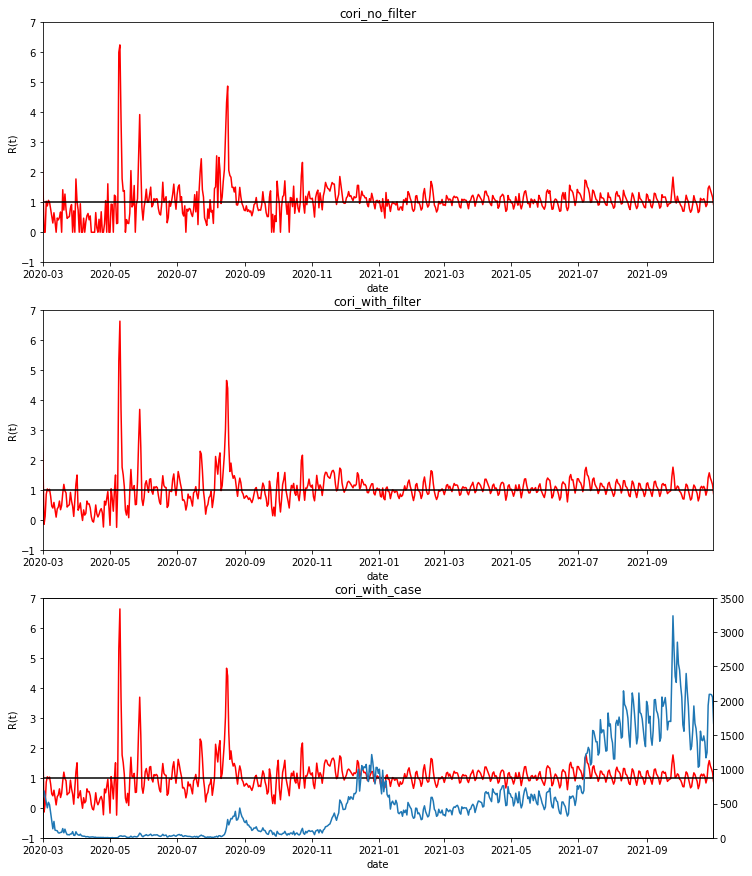

In [ ]:
f, axes = plt.subplots(3, 1)
f.set_size_inches((12, 15))
x=df_variants['Total_Rt'].index
y=df_variants['Total_Rt']
yhat=savgol_filter(y,11,9)
# cori_no_filter
axes[0].plot(x,y,'r')
axes[0].axhline(y=1,color='black')
axes[0].set_xlim([dt.date(2020,3,1),dt.date(2021,10,31)])
axes[0].set_ylim(-1,7)
axes[0].set_xlabel('date')
axes[0].set_ylabel('R(t)')
axes[0].set_title('cori_no_filter')
# cori_with_filter
axes[1].plot(x,yhat,'r')
axes[1].axhline(y=1,color='black')
axes[1].set_xlim([dt.date(2020,3,1),dt.date(2021,10,31)])
axes[1].set_ylim(-1,7)
axes[1].set_xlabel('date')
axes[1].set_ylabel('R(t)')
axes[1].set_title('cori_with_filter')
# cori_with_case
axes[2].plot(x,yhat,'r')
axes[2].axhline(y=1,color='black')
axes[2].set_xlim([dt.date(2020,3,1),dt.date(2021,10,31)])
axes[2].set_ylim(-1,7)
axes[2].set_xlabel('date')
axes[2].set_ylabel('R(t)')
axes[2].set_title('cori_with_case')
ax = axes[2].twinx()
x1=df_variants['total'].index
y1=df_variants['total']
ax.plot(x1,y1)
ax.set_xlim([dt.date(2020,3,1),dt.date(2021,10,31)])
ax.set_ylim(0,3500)
plt.show()

####Delta

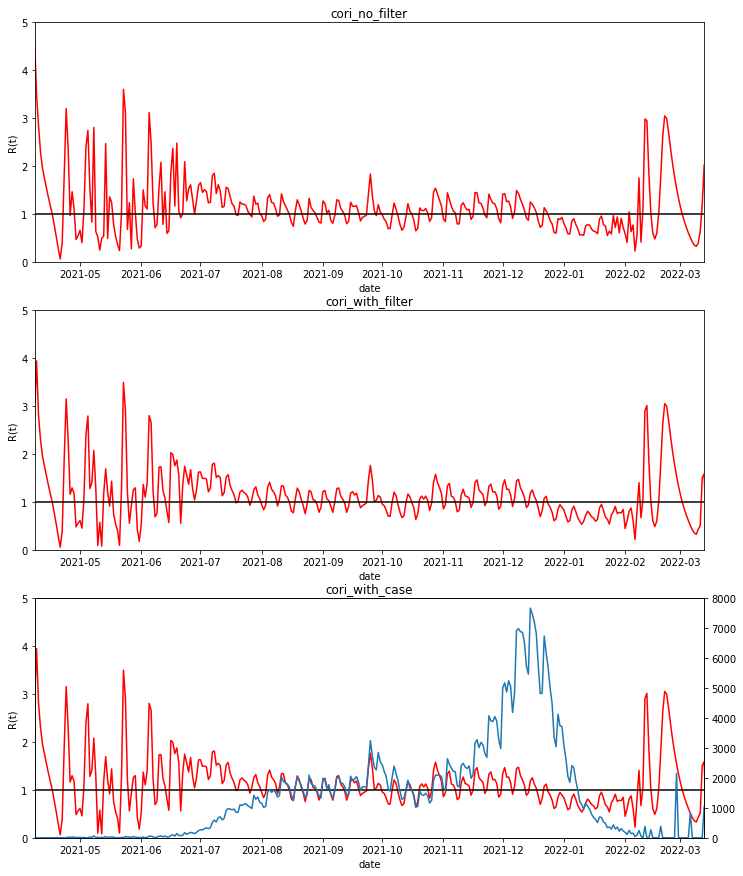

In [ ]:
f, axes = plt.subplots(3, 1)
f.set_size_inches((12, 15))
x=df_variants['Delta_Rt'].index
y=df_variants['Delta_Rt']
yhat=savgol_filter(y,11,9)
# cori_no_filter
axes[0].plot(x,y,'r')
axes[0].axhline(y=1,color='black')
axes[0].set_xlim([dt.date(2021,4,8),dt.date(2022,3,13)])
axes[0].set_ylim(0,5)
axes[0].set_xlabel('date')
axes[0].set_ylabel('R(t)')
axes[0].set_title('cori_no_filter')
# cori_with_filter
axes[1].plot(x,yhat,'r')
axes[1].axhline(y=1,color='black')
axes[1].set_xlim([dt.date(2021,4,8),dt.date(2022,3,13)])
axes[1].set_ylim(0,5)
axes[1].set_xlabel('date')
axes[1].set_ylabel('R(t)')
axes[1].set_title('cori_with_filter')
# cori_with_case
axes[2].plot(x,yhat,'r')
axes[2].axhline(y=1,color='black')
axes[2].set_xlim([dt.date(2021,4,8),dt.date(2022,3,13)])
axes[2].set_ylim(0,5)
axes[2].set_xlabel('date')
axes[2].set_ylabel('R(t)')
axes[2].set_title('cori_with_case')
ax = axes[2].twinx()
x1=df_variants['Delta_p'].index
y1=df_variants['Delta_p']
ax.plot(x1,y1)
ax.set_xlim([dt.date(2021,4,8),dt.date(2022,3,13)])
ax.set_ylim(0,8000)
plt.show()

####Omicron

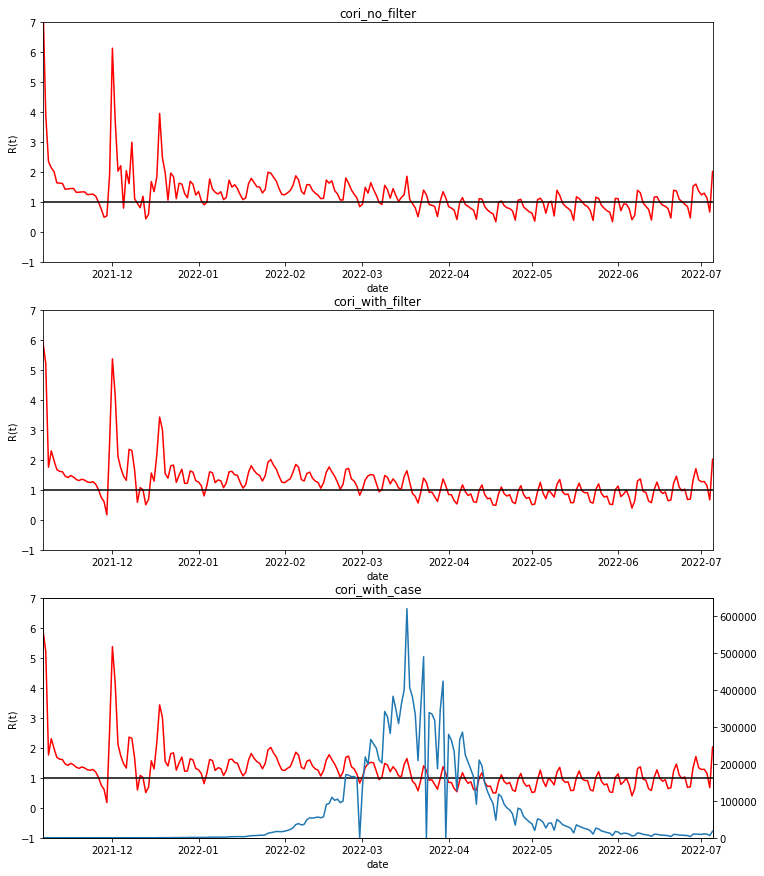

In [ ]:
f, axes = plt.subplots(3, 1)
f.set_size_inches((12, 15))
x=df_variants['Omicron_Rt'].index
y=df_variants['Omicron_Rt']
yhat=savgol_filter(y,11,9)
# cori_no_filter
axes[0].plot(x,y,'r')
axes[0].axhline(y=1,color='black')
axes[0].set_xlim([dt.date(2021,11,6),dt.date(2022,7,5)])
axes[0].set_ylim(-1,7)
axes[0].set_xlabel('date')
axes[0].set_ylabel('R(t)')
axes[0].set_title('cori_no_filter')
# cori_with_filter
axes[1].plot(x,yhat,'r')
axes[1].axhline(y=1,color='black')
axes[1].set_xlim([dt.date(2021,11,6),dt.date(2022,7,5)])
axes[1].set_ylim(-1,7)
axes[1].set_xlabel('date')
axes[1].set_ylabel('R(t)')
axes[1].set_title('cori_with_filter')
# cori_with_case
axes[2].plot(x,yhat,'r')
axes[2].axhline(y=1,color='black')
axes[2].set_xlim([dt.date(2021,11,6),dt.date(2022,7,5)])
axes[2].set_ylim(-1,7)
axes[2].set_xlabel('date')
axes[2].set_ylabel('R(t)')
axes[2].set_title('cori_with_case')
ax = axes[2].twinx()
x1=df_variants['Omicron_p'].index
y1=df_variants['Omicron_p']
ax.plot(x1,y1)
ax.set_xlim([dt.date(2021,11,6),dt.date(2022,7,5)])
ax.set_ylim(0,650000)
plt.show()

####Others

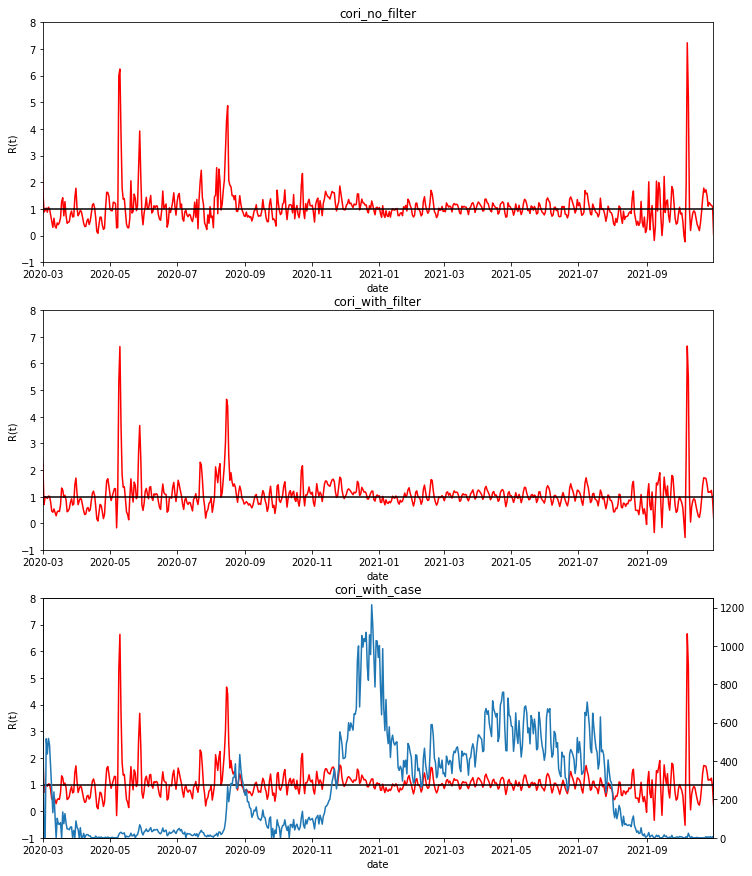

In [ ]:
f, axes = plt.subplots(3, 1)
f.set_size_inches((12, 15))
x=df_variants['Others_Rt'].index
y=df_variants['Others_Rt']
yhat=savgol_filter(y,11,9)
# cori_no_filter
axes[0].plot(x,y,'r')
axes[0].axhline(y=1,color='black')
axes[0].set_xlim([dt.date(2020,3,1),dt.date(2021,10,31)])
axes[0].set_ylim(-1,8)
axes[0].set_xlabel('date')
axes[0].set_ylabel('R(t)')
axes[0].set_title('cori_no_filter')
# cori_with_filter
axes[1].plot(x,yhat,'r')
axes[1].axhline(y=1,color='black')
axes[1].set_xlim([dt.date(2020,3,1),dt.date(2021,10,31)])
axes[1].set_ylim(-1,8)
axes[1].set_xlabel('date')
axes[1].set_ylabel('R(t)')
axes[1].set_title('cori_with_filter')
# cori_with_case
axes[2].plot(x,yhat,'r')
axes[2].axhline(y=1,color='black')
axes[2].set_xlim([dt.date(2020,3,1),dt.date(2021,10,31)])
axes[2].set_ylim(-1,8)
axes[2].set_xlabel('date')
axes[2].set_ylabel('R(t)')
axes[2].set_title('cori_with_case')
ax = axes[2].twinx()
x1=df_variants['Others_p'].index
y1=df_variants['Others_p']
ax.plot(x1,y1)
ax.set_xlim([dt.date(2020,3,1),dt.date(2021,10,31)])
ax.set_ylim(0,1250)
plt.show()

###부트스트랩 그래프 -> 제외

In [ ]:
# df_all['R_mean']=0
# df_all['R_sd']=0
# df_all['R_Q0.025']=0
# df_all['R_Q0.975']=0
# df_all

In [ ]:
# import scipy.stats
# from scipy.stats import norm
# import math
# import warnings
# pd.set_option('mode.chained', None) #warning이 뜨는데 문제 없는 거 같아 껐습니다
# warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)
# n=100 #표본을 늘리면 좋기는 하지만 오래 걸리거나 안 돌아갈 경우 정확도는 떨어지지만 낮추면 됩니다(n=100에서도 분산 충분히 작음)
# norm_=norm(0,1)
# for i in range(len(df_all.index)):
#     tmp=[]
#     for j in range(n):
#         rnum=np.random.uniform(0,1,1)
#         if rnum<df_all['p_Delta'].iloc[i]: # random 값이 delta 변이 비율보다 작은 경우
#             if df_delta['R_mean'].iloc[i]==0 : tmp.append(0) # delta의 평균이 0인 경우
#             else : # delta의 평균이 0이 아닌 경우
#                 tmp.append(np.random.normal(df_delta['R_mean'].iloc[i],np.sqrt(df_delta['R_var'].iloc[i]),1))
#         elif rnum>=df_all['p_Delta'].iloc[i] and rnum<(df_all['p_Delta'].iloc[i]+df_all['p_Omicron'].iloc[i]):
#             # random 값이 delta의 변이 비율보다 크고 delta와 omicron을 더한 변이 비율보다 작은 경우
#             if df_omicron['R_mean'].iloc[i]==0 : tmp.append(0) # omicron의 평군이 0일 경우
#             else : # omicron의 평균이 0이 아닐 경우
#                 tmp.append(np.random.normal(df_omicron['R_mean'].iloc[i],np.sqrt(df_omicron['R_var'].iloc[i]),1))
#         else: # random 값이 delta와 omicron을 더한 변이 비율보다 큰 경우
#             if df_others['R_mean'].iloc[i]==0 : tmp.append(0) # others의 평균이 0일 경우
#             else: # others의 평균이 0이 아닐 경우
#                 tmp.append(np.random.normal(df_others['R_mean'].iloc[i],np.sqrt(df_others['R_var'].iloc[i]),1))
#         df_all['R_mean'].iloc[i]=np.mean(tmp)
#         df_all['R_sd'].iloc[i]=np.std(tmp)
#         df_all['R_Q0.025'].iloc[i]=df_all['R_mean'].iloc[i]-(norm_.ppf(0.975)*df_all['R_sd'].iloc[i]/np.sqrt(n))
#         df_all['R_Q0.975'].iloc[i]=df_all['R_mean'].iloc[i]+(norm_.ppf(0.975)*df_all['R_sd'].iloc[i]/np.sqrt(n))
#         tmp

In [ ]:
# df_all

In [ ]:
# fig, ax1 = plt.subplots(figsize=(12,4))
# df_all.loc[:,'R_mean'].plot(ax=ax1, color='red')
# ax1.fill_between(df_all.index, df_all['R_Q0.025'], df_all['R_Q0.975'], color='green', alpha=0.5) #CI가 작아서 거의 안 보입니다
# ax1.set_xlabel('date')
# ax1.set_ylim(0,6)
# df_variants['Total_Rt'].loc['2020-03-06':'2022-06-25'].plot(ax=ax1,color='red',alpha=0.3) #연한게 전에 만들었던 그래프
# ax1.axhline(y=1)
# ax1.legend()
# plt.show()

In [ ]:
# fig, ax1 = plt.subplots(figsize=(12,4))
# df_all.loc[:,'R_mean'].plot(ax=ax1, color='red')
# ax1.fill_between(df_all.index, df_all['R_Q0.025'], df_all['R_Q0.975'], color='red', alpha=0.3) #CI가 작아서 거의 안 보입니다
# ax1.set_xlabel('date')
# ax1.set_ylim(0,4)
# ax1.axhline(y=1)
# ax1.legend()
# plt.show()

###해외 변이 Rt 그래프

####함수

In [ ]:
def Rt_variant(data,country):
  # cori 계산
  cori=[]
  for i in range(4):
      temp=[]
      variant=data.iloc[:,i] # 각 변이 그래프를 불러옴
      for j in range(len(variant.index)): # cori rt값 계산
         temp.append(Cori(j,variant,W(len(variant))))
      cori.append(pd.DataFrame(temp,index=variant.index)) # list에 저장
  data['Delta_Rt']=cori[0]
  data['Omicron_Rt']=cori[1]
  data['Others_Rt']=cori[2]
  data['total_Rt']=cori[3]
  data['Total_Rt']=data['Delta_Rt']*data['delta_p']+data['Omicron_Rt']*data['omicron_p']+data['Others_Rt']*data['others_p']

  # 시각화
  pd.set_option('mode.chained_assignment',  None)
  f, axes = plt.subplots(2, 5)
  f.set_size_inches((60, 12))

  # total_before
  x=data['total_Rt'].index
  data['total_Rt'][data['total_Rt']>5] = 0
  y=data['total_Rt']
  yhat=savgol_filter(y,11,9)
  # total_before_no_filter
  axes[0][0].plot(x,y,'r')
  axes[0][0].axhline(y=1,color='black')
  axes[0][0].set_xlabel('date')
  axes[0][0].set_ylabel('R(t)')
  axes[0][0].set_title(country+'_total_before_no_filter')
  ax = axes[0][0].twinx()
  x1=data['total_sequences'].index
  y1=data['total_sequences']
  ax.plot(x1,y1)
  # total_before_with_filter
  axes[1][0].plot(x,yhat,'r')
  axes[1][0].axhline(y=1,color='black')
  axes[1][0].set_xlabel('date')
  axes[1][0].set_ylabel('R(t)')
  axes[1][0].set_title(country+'_total_before_with_filter')
  ax = axes[1][0].twinx()
  x1=data['total_sequences'].index
  y1=data['total_sequences']
  ax.plot(x1,y1)

  # total_after
  x=data['Total_Rt'].index
  data['Total_Rt'][data['Total_Rt']>5] = 0
  y=data['Total_Rt']
  yhat=savgol_filter(y,11,9)
  # total_after_no_filter
  axes[0][1].plot(x,y,'r')
  axes[0][1].axhline(y=1,color='black')
  axes[0][1].set_xlabel('date')
  axes[0][1].set_ylabel('R(t)')
  axes[0][1].set_title(country+'_total_after_no_filter')
  ax = axes[0][1].twinx()
  x1=data['total_sequences'].index
  y1=data['total_sequences']
  ax.plot(x1,y1)
  # total_after_with_filter
  axes[1][1].plot(x,yhat,'r')
  axes[1][1].axhline(y=1,color='black')
  axes[1][1].set_xlabel('date')
  axes[1][1].set_ylabel('R(t)')
  axes[1][1].set_title(country+'_total_after_with_filter')
  ax = axes[1][1].twinx()
  x1=data['total_sequences'].index
  y1=data['total_sequences']
  ax.plot(x1,y1)

  # Delta
  x=data['Delta_Rt'].index
  data['Delta_Rt'][data['Delta_Rt']>5] = 0
  y=data['Delta_Rt']
  yhat=savgol_filter(y,11,9)
  # delta_no_filter
  axes[0][2].plot(x,y,'r')
  axes[0][2].axhline(y=1,color='black')
  axes[0][2].set_xlabel('date')
  axes[0][2].set_ylabel('R(t)')
  axes[0][2].set_title(country+'_delta_no_filter')
  ax = axes[0][2].twinx()
  x1=data['delta'].index
  y1=data['delta']
  ax.plot(x1,y1)
  # delta_with_filter
  axes[1][2].plot(x,yhat,'r')
  axes[1][2].axhline(y=1,color='black')
  axes[1][2].set_xlabel('date')
  axes[1][2].set_ylabel('R(t)')
  axes[1][2].set_title(country+'_delta_with_filter')
  ax = axes[1][2].twinx()
  x1=data['delta'].index
  y1=data['delta']
  ax.plot(x1,y1)

  # Omicron
  x=data['Omicron_Rt'].index
  data['Omicron_Rt'][data['Omicron_Rt']>5] = 0
  y=data['Omicron_Rt']
  yhat=savgol_filter(y,11,9)
  # omicron_no_filter
  axes[0][3].plot(x,y,'r')
  axes[0][3].axhline(y=1,color='black')
  axes[0][3].set_xlabel('date')
  axes[0][3].set_ylabel('R(t)')
  axes[0][3].set_title(country+'_omicron_no_filter')
  ax = axes[0][3].twinx()
  x1=data['omicron'].index
  y1=data['omicron']
  ax.plot(x1,y1)
  # omicron_with_filter
  axes[1][3].plot(x,yhat,'r')
  axes[1][3].axhline(y=1,color='black')
  axes[1][3].set_xlabel('date')
  axes[1][3].set_ylabel('R(t)')
  axes[1][3].set_title(country+'_omicron_with_filter')
  ax = axes[1][3].twinx()
  x1=data['omicron'].index
  y1=data['omicron']
  ax.plot(x1,y1)

  # Others
  x=data['Others_Rt'].index
  data['Others_Rt'][data['Others_Rt']>5] = 0
  y=data['Others_Rt']
  yhat=savgol_filter(y,11,9)
  # others_no_filter
  axes[0][4].plot(x,y,'r')
  axes[0][4].axhline(y=1,color='black')
  axes[0][4].set_xlabel('date')
  axes[0][4].set_ylabel('R(t)')
  axes[0][4].set_title(country+'_others_no_filter')
  ax = axes[0][4].twinx()
  x1=data['others'].index
  y1=data['others']
  ax.plot(x1,y1)
  # others_with_filter
  axes[1][4].plot(x,yhat,'r')
  axes[1][4].axhline(y=1,color='black')
  axes[1][4].set_xlabel('date')
  axes[1][4].set_ylabel('R(t)')
  axes[1][4].set_title(country+'_others_with_filter')
  ax = axes[1][4].twinx()
  x1=data['others'].index
  y1=data['others']
  ax.plot(x1,y1)

  plt.show()

####일본

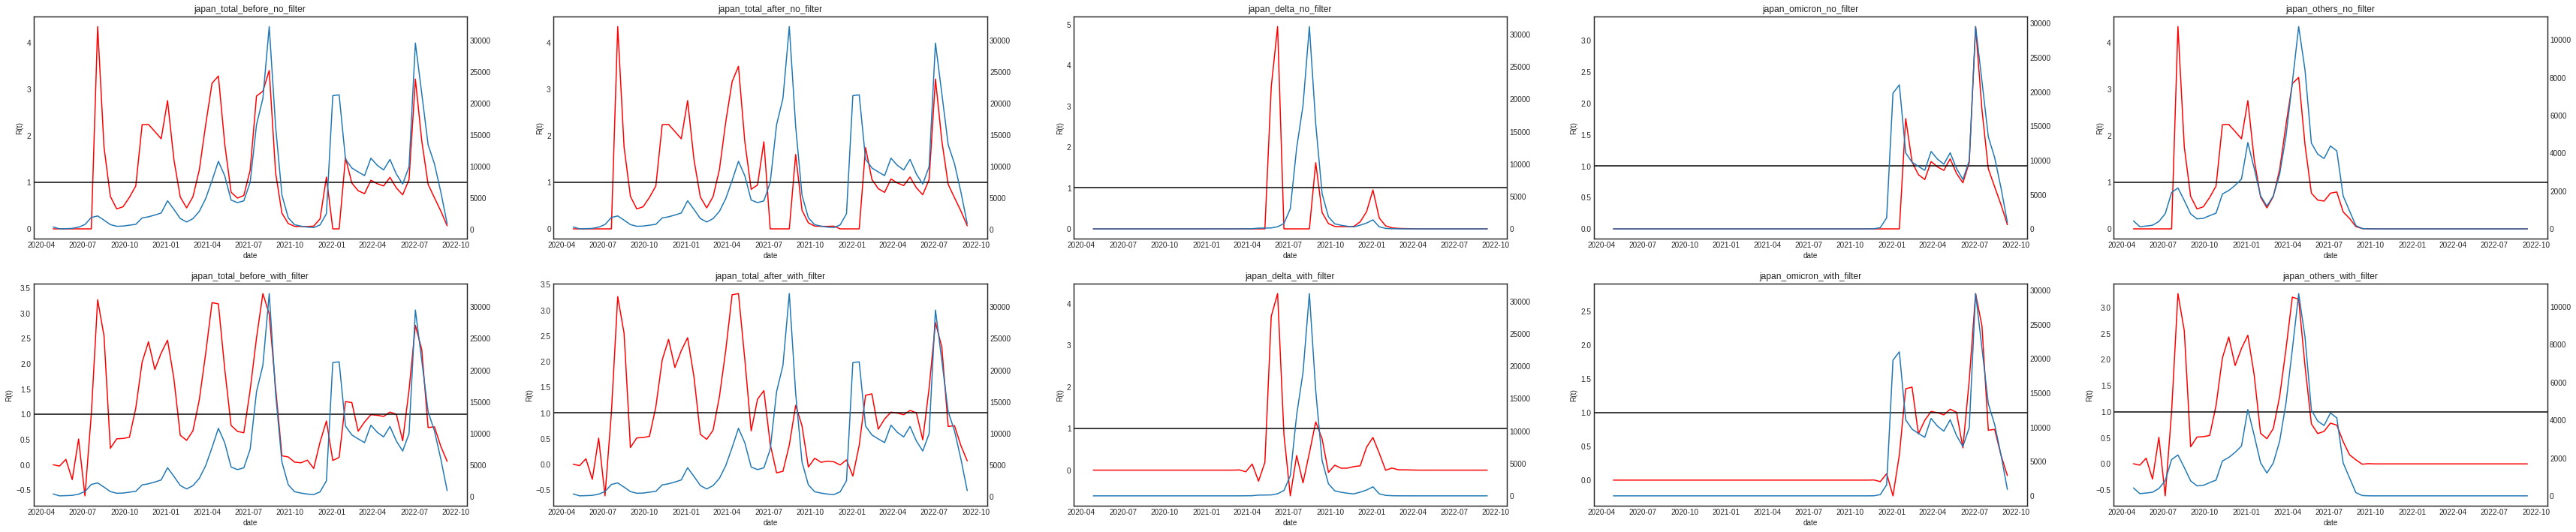

In [ ]:
Rt_variant(df_japan,'japan')

####캐나다

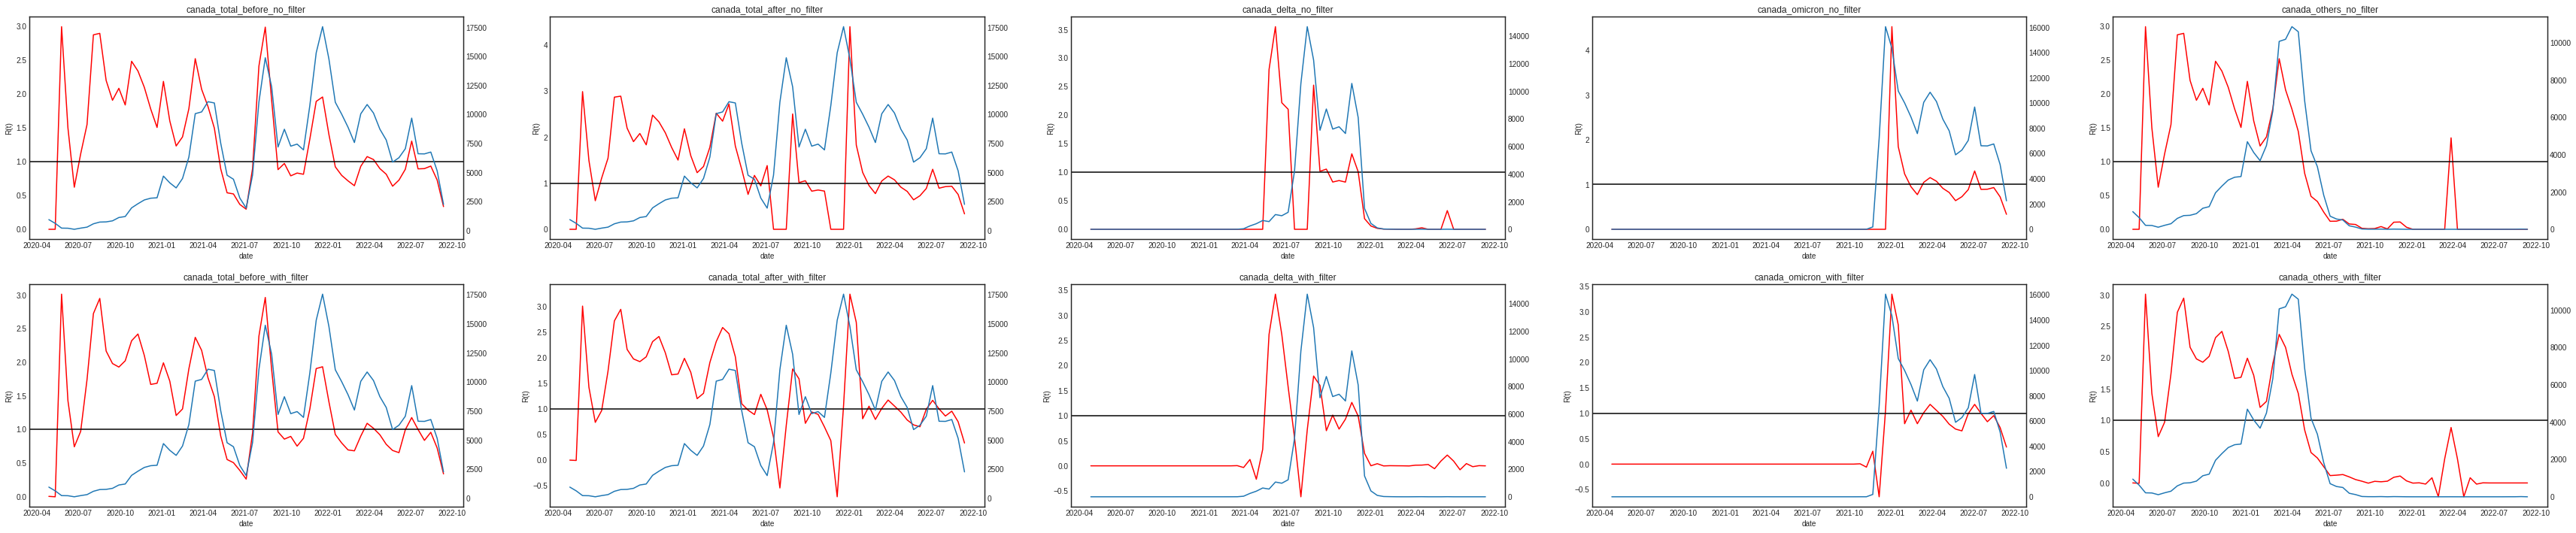

In [ ]:
Rt_variant(df_canada,'canada')

####이탈리아

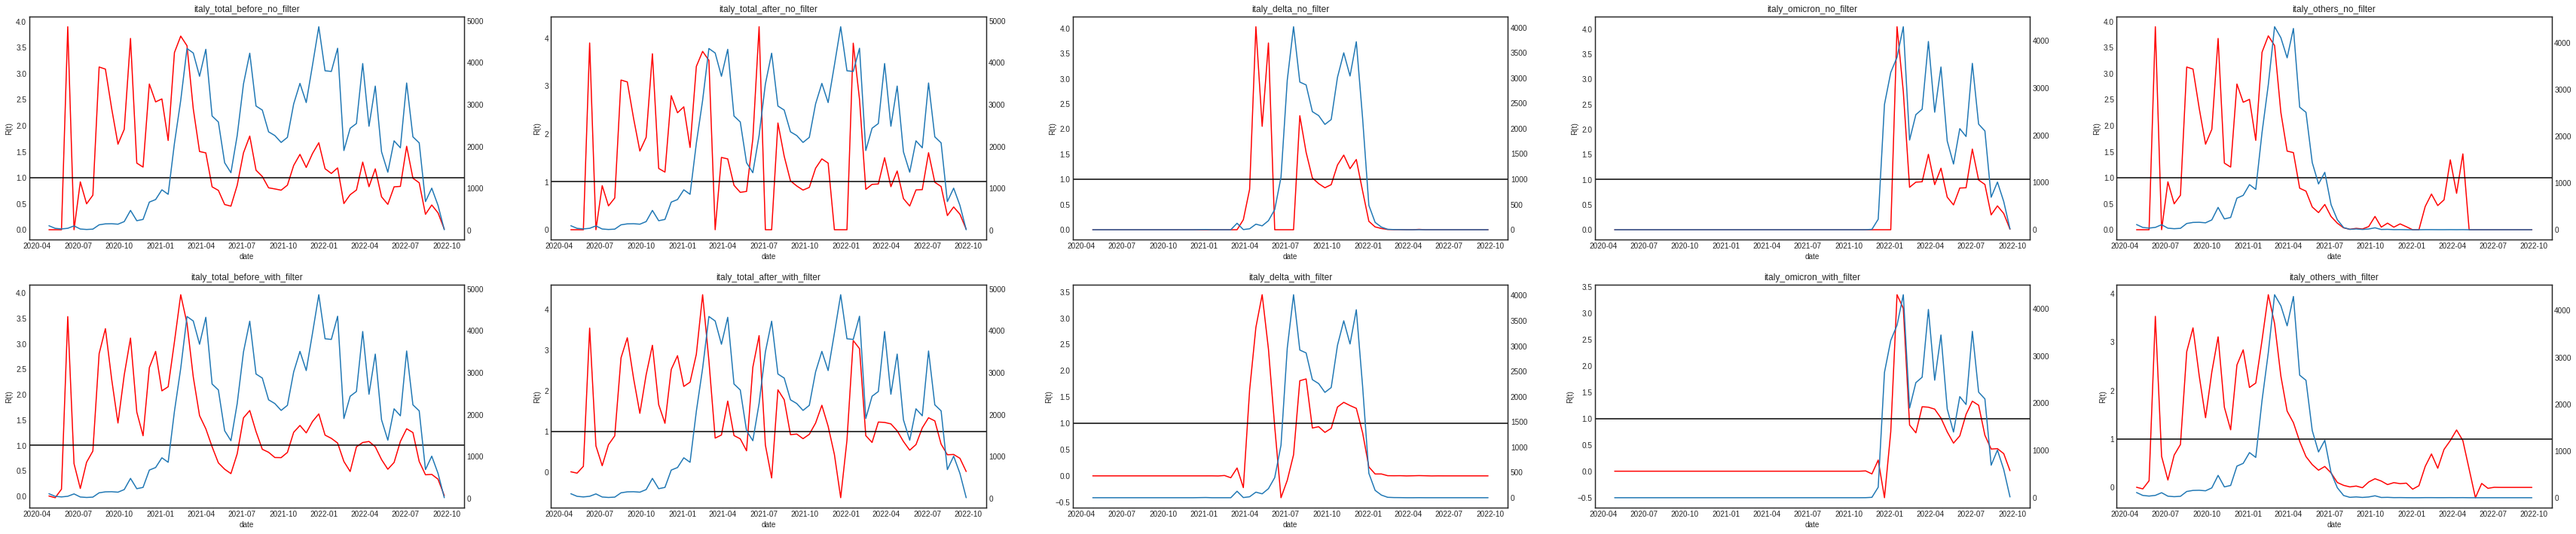

In [ ]:
Rt_variant(df_italy,'italy')

####미국

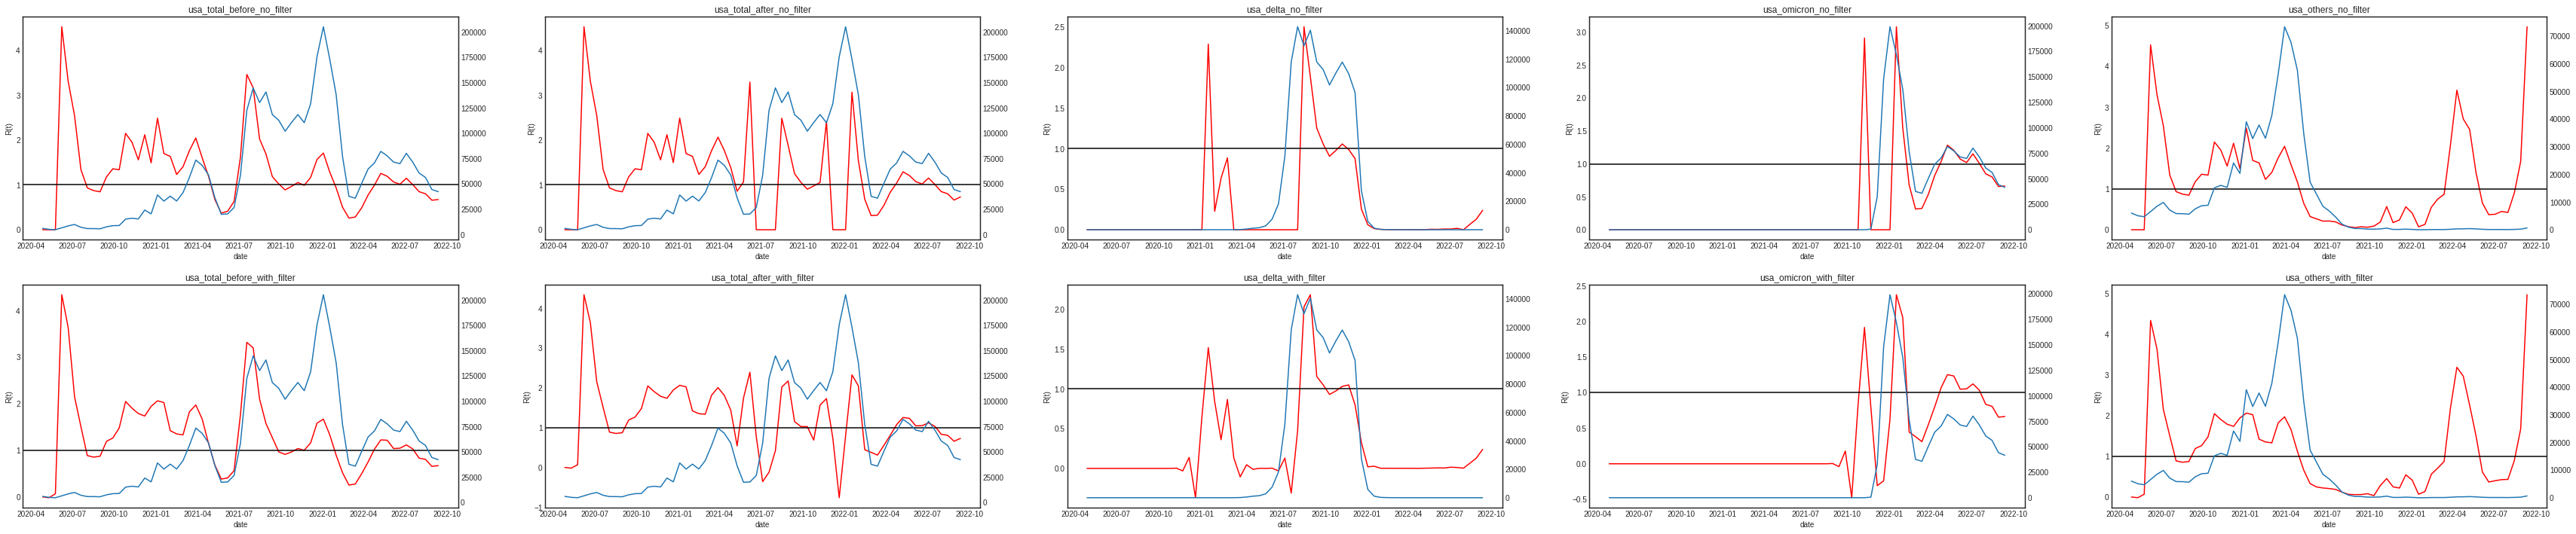

In [ ]:
Rt_variant(df_usa,'usa')

####영국

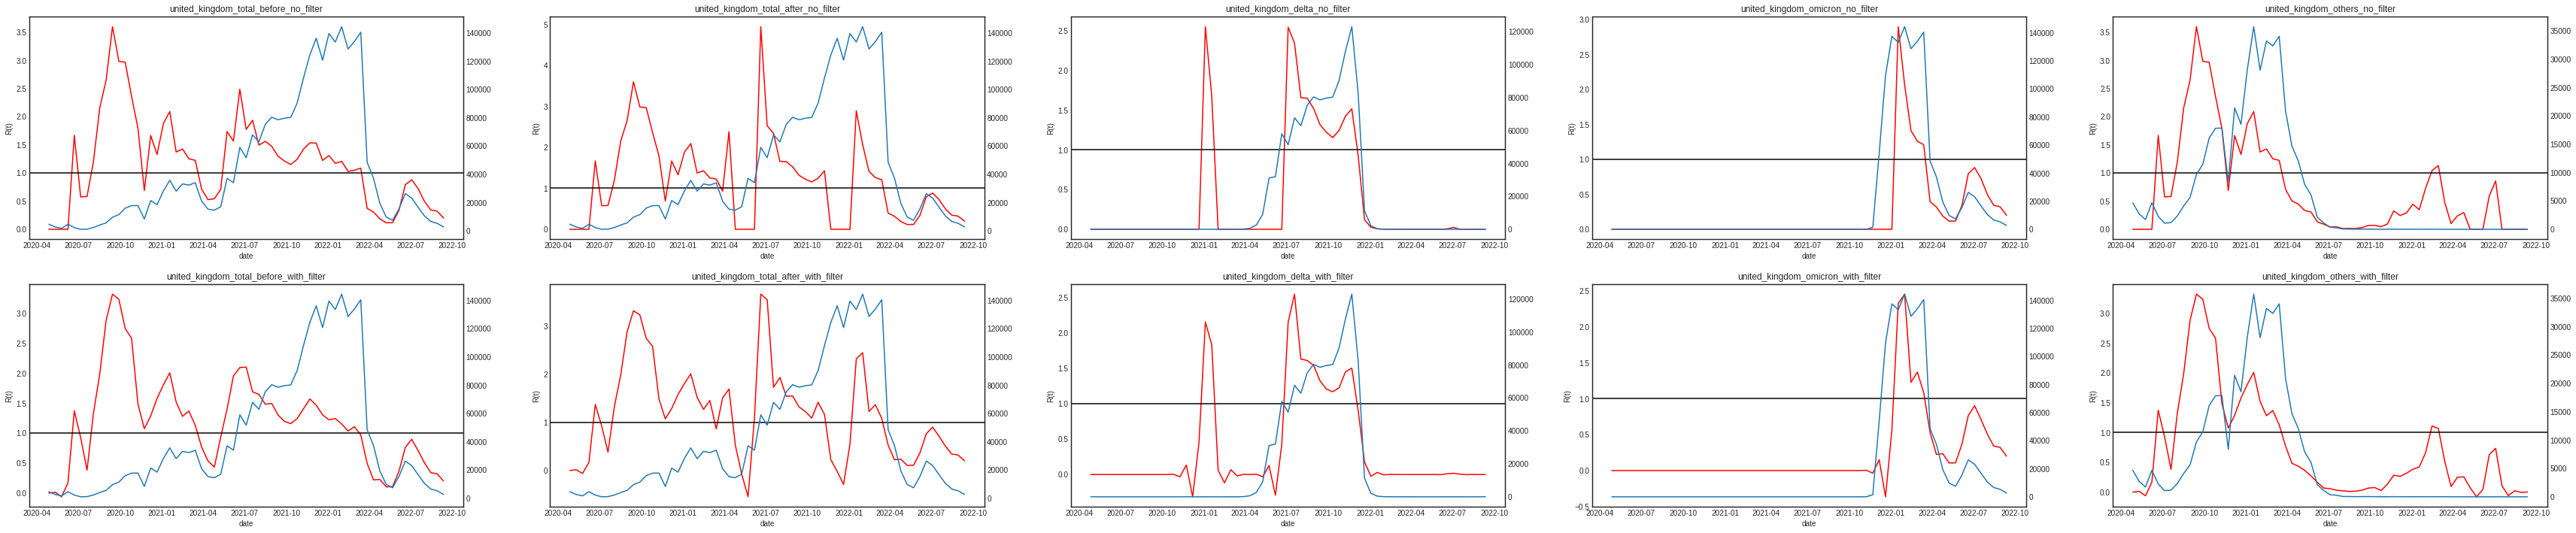

In [ ]:
Rt_variant(df_uk,'united_kingdom')

####독일

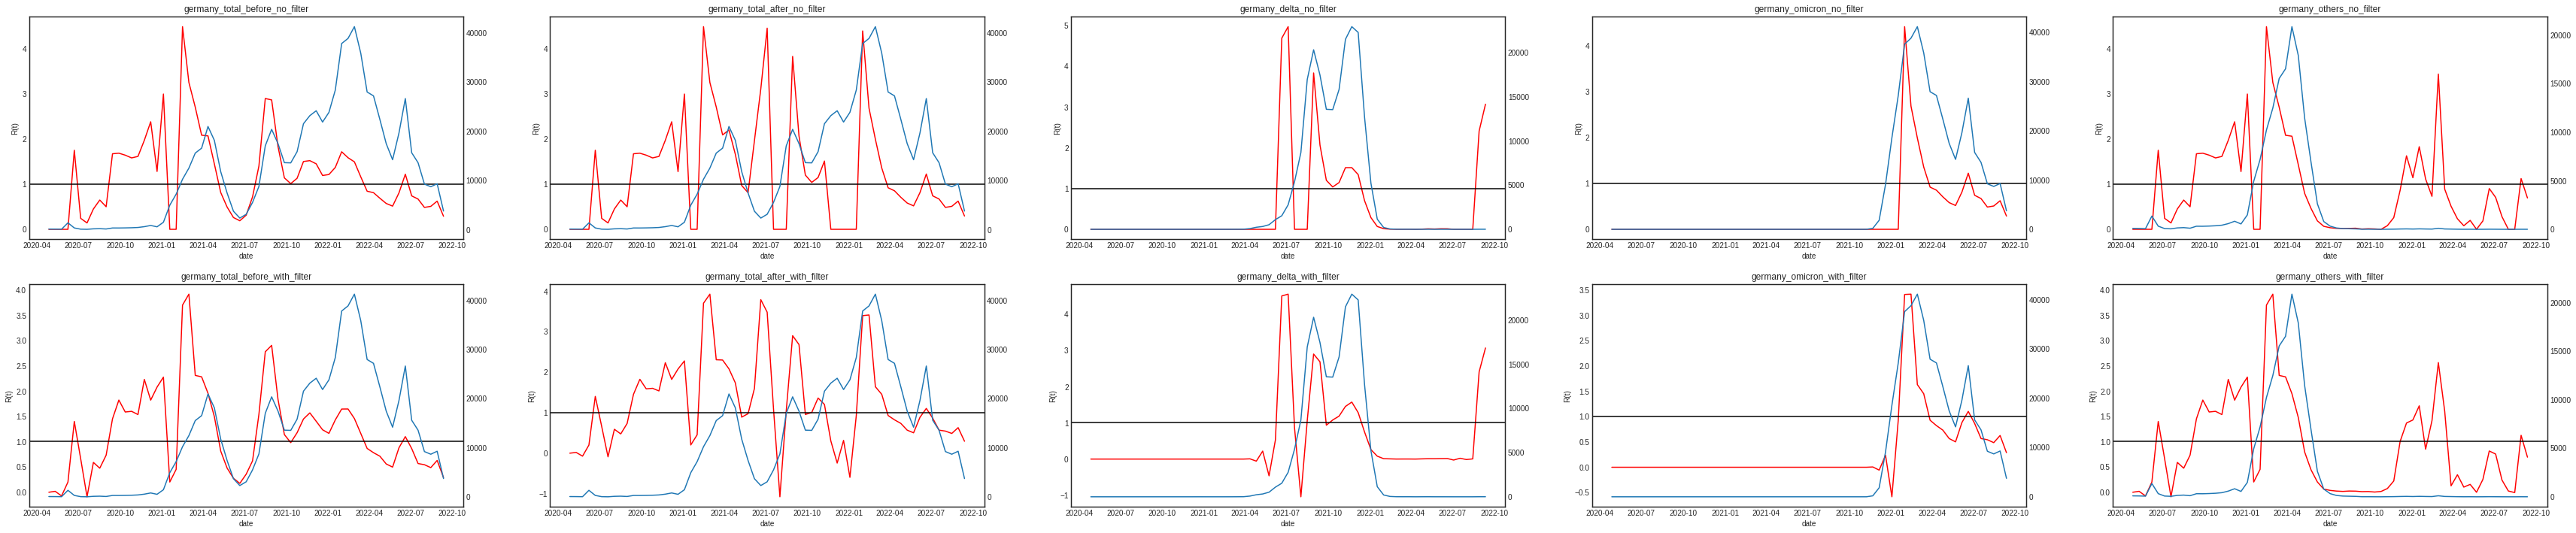

In [ ]:
Rt_variant(df_ger,'germany')

####프랑스

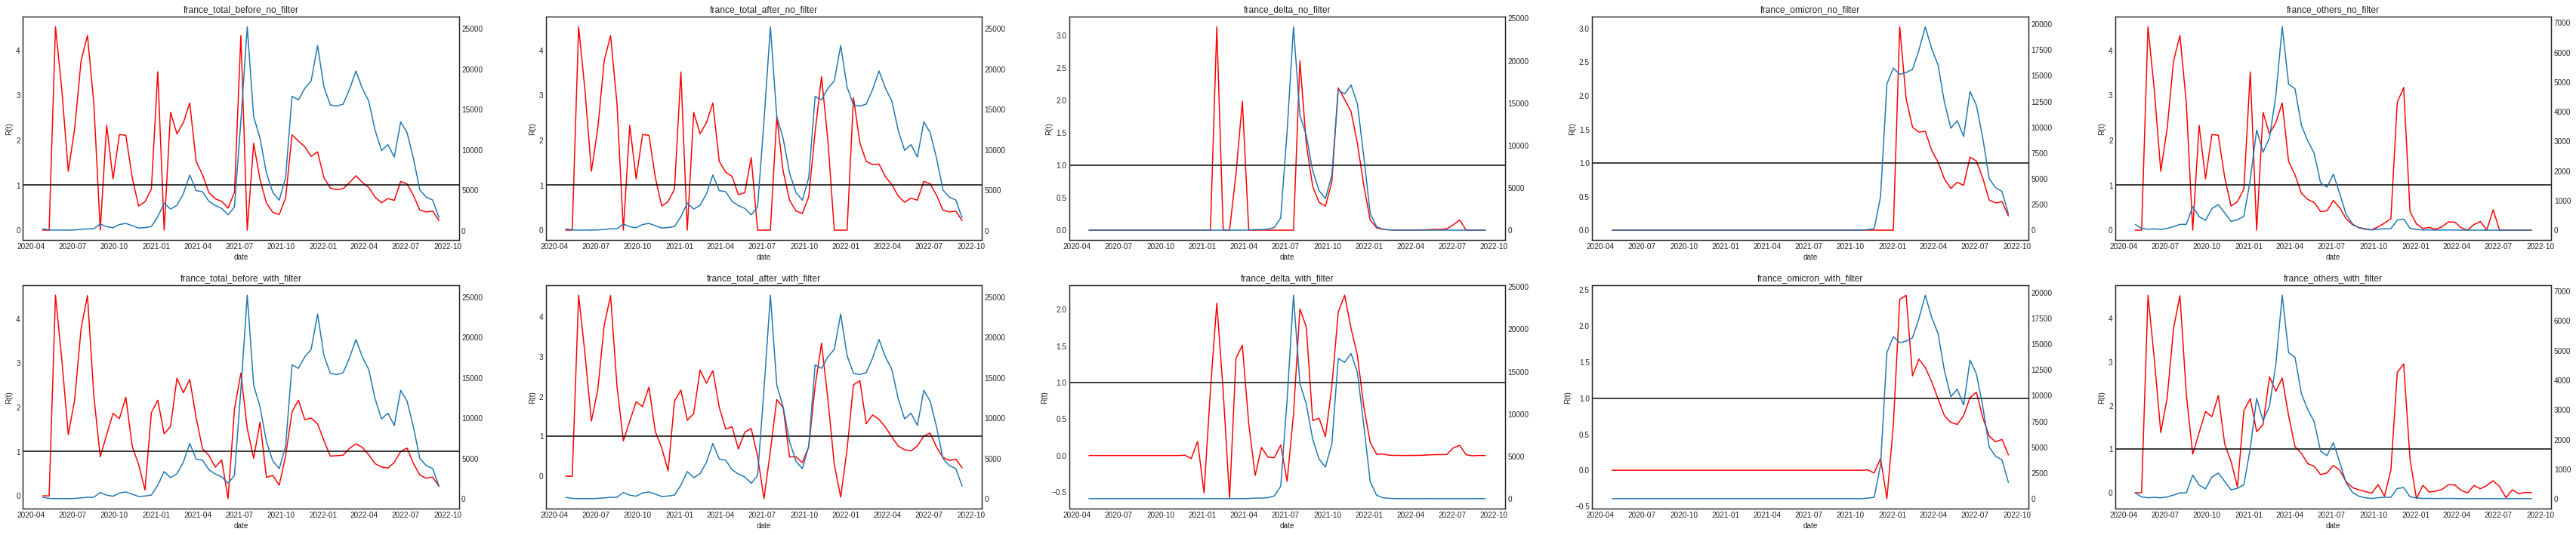

In [ ]:
Rt_variant(df_fra,'france')

##Bettencourt

###Bettencourt 함수

In [ ]:
g1=len(df_covid)/df_covid['local'].sum()
g1

0.001514594080730013

In [ ]:
def Bett(i,data,g): # Bett update version
    a=data[i+1] # I_t+1
    b=data[i] # I_t
    r=g*np.log(a/b)+1
    return r

###Bettencourt 그래프

In [ ]:
for i in range(7,len(df_covid.index)-1):
    df_covid.loc[i,'Bett']=Bett(i,df_covid['local'],g1)

In [ ]:
df_covid

date  local              W      Cori      Bett
0   2020-05-01      1   2.770210e-02       NaN       NaN
1   2020-05-02      0   1.144243e-01  0.000000       NaN
2   2020-05-03      3   1.800138e-01  0.000000       NaN
3   2020-05-04      0   1.907466e-01  0.000000       NaN
4   2020-05-05      0   1.627648e-01  0.000000       NaN
..         ...    ...            ...       ...       ...
559 2021-11-11   2494  2.401001e-213  1.243435  0.999915
560 2021-11-12   2358  9.748223e-214  1.148363  0.999969
561 2021-11-13   2310  3.957800e-214  1.089071  1.000059
562 2021-11-14   2401  1.606859e-214  1.102904  0.999713
563 2021-11-15   1986  6.523743e-215  0.893171       NaN

[564 rows x 5 columns]

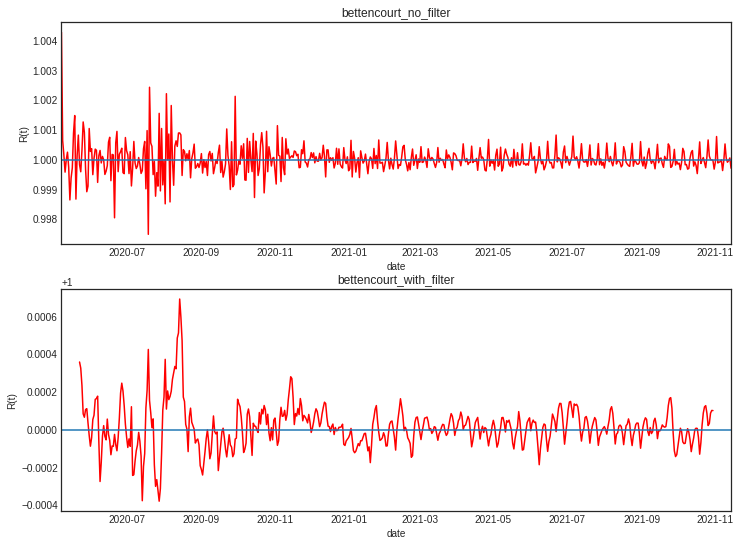

In [ ]:
f, axes = plt.subplots(2, 1)
f.set_size_inches((12, 9))
x=df_covid['date']
y=df_covid['Bett']
yhat=savgol_filter(y,31,9)
# bettencourt_no_filter
axes[0].plot(x,y,'r')
axes[0].axhline(y=1)
axes[0].set_xlim([dt.date(2020,5,8),dt.date(2021,11,14)])
axes[0].set_xlabel('date')
axes[0].set_ylabel('R(t)')
axes[0].set_title('bettencourt_no_filter')
# bettencourt_with_filter
axes[1].plot(x,yhat,'r')
axes[1].axhline(y=1)
axes[1].set_xlim([dt.date(2020,5,8),dt.date(2021,11,14)])
axes[1].set_xlabel('date')
axes[1].set_ylabel('R(t)')
axes[1].set_title('bettencourt_with_filter')
plt.show()

##Wallinga

###Weibull distribution

In [ ]:
#시간마다 weibull distribution을 만들기 위해 시간만 추출
date=df_wallinga.신고일.unique()
date=sorted(date) # 날짜 뒤죽박죽이라 정렬함
date

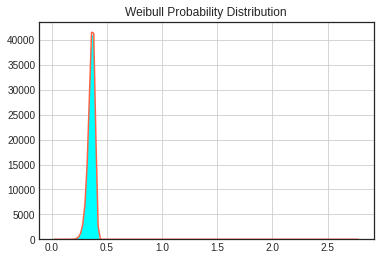

In [ ]:
#wallinga 매개변수 w -> weibull distribution
import numpy as np
import matplotlib.pyplot as plt

n_MC=10**6
mu=5.19
sig=1.39
shape=mu**2/sig**2
scale=sig**2/mu

def my_weibull(x,m,n):
    return(m/n)*(x/n)**(m-1)*np.exp(-(x/n)**m)

y1=scale*np.random.weibull(shape,n_MC)
x2=np.arange(1,len(date)+1)/50.
y2=my_weibull(x2,shape,scale)

plt.figure(1)
count,bins,ignored=plt.hist(y1,bins=100,color='Aqua')
y_scale=count.max()/y2.max()
y2=y2*y_scale
plt.plot(x2,y2,color='Tomato')
plt.title('Weibull Probability Distribution')
plt.grid()
plt.show()

In [ ]:
wb=dict(zip(date,y2))
df_wallinga['w'] = df_wallinga.신고일.map(wb)
df_wallinga

id         신고일 감염경로  선행확진id             w
2341  12862  2020-07-01   국내  #12555  3.478452e-08
2342  12863  2020-06-30   국내  #12784  4.422305e-12
2343  12864  2020-06-30   국내  #12395  4.422305e-12
2344  12867  2020-07-01   국내  #12826  3.478452e-08
2345  12868  2020-06-30   국내  #12839  4.422305e-12
...     ...         ...  ...     ...           ...
8442  28575  2020-11-14   국내  #28512  0.000000e+00
8443  28576  2020-11-14   국내  #28512  0.000000e+00
8444  28577  2020-11-14   국내  #28507  0.000000e+00
8445  28578  2020-11-14   국내  #28507  0.000000e+00
8446  28580  2020-11-15   국내  #27897  0.000000e+00

[6099 rows x 5 columns]

###Wallinga 함수

In [ ]:
# t_i를 구하기 쉽게하기 위해
id_date=dict(zip(df_wallinga.id,df_wallinga.신고일))

# i 값이 실제로 있는지 확인하기 위해
check=list(df_wallinga.id)

**와이링가 식**
- w(t_i-t_j)/sigma i!=k w(t_i-t_k)
- t_i : case i가 감염된 시간
- t_j : case j가 감염된 시간

In [ ]:
from datetime import datetime
def Wallinga(m,w):
  P=[]
  j=df_wallinga.loc[m,'id'] # case j
  i=df_wallinga.loc[m,'선행확진id'] # case i
  i=i.replace('\n',',')
  for tok in i.split(','): # case i가 여러개인 경우 존재
    tok = re.sub(r'[^0-9]', '', tok) # 선행 id만 추출
    if tok != '':
      if int(tok) in check: # 선행 id(i)가 주어진 데이터에 존재하는 경우
        total=0
        t_j=id_date[int(j)] # case j가 감염된 시간
        t_i=id_date[int(tok)]# case i가 감염된 시간
        t_j=datetime.strptime(t_j, '%Y-%m-%d')
        t_i=datetime.strptime(t_i, '%Y-%m-%d')
        for k in df_wallinga.index: # Pij의 분모 구하기
          k=df_wallinga.loc[k,'id'] # case k
          if i != k:
            t_k=datetime.strptime(id_date[int(k)], '%Y-%m-%d')
            total+=w*(t_i-t_k).days
        day=w*(t_i-t_j).days # Pij의 분자 구하기
        p=day/total
      else: p=np.nan # 선행 id가 존재하지 않는 경우
      P.append(p) # Pij
  return np.nansum(P) # Rj, nansum: nan을 무시하고 더함

###Wallinga 그래프

In [ ]:
for m in df_wallinga.index:
  # print(df_wallinga.loc[m,'신고일'])
  df_wallinga.loc[m,'Wallinga']=Wallinga(m,df_wallinga.loc[m,'w'])

In [ ]:
df_wallinga

id         신고일 감염경로  선행확진id             w  Wallinga
2341  12862  2020-07-01   국내  #12555  3.478452e-08       0.0
2342  12863  2020-06-30   국내  #12784  4.422305e-12       0.0
2343  12864  2020-06-30   국내  #12395  4.422305e-12       0.0
2344  12867  2020-07-01   국내  #12826  3.478452e-08       0.0
2345  12868  2020-06-30   국내  #12839  4.422305e-12       0.0
...     ...         ...  ...     ...           ...       ...
8442  28575  2020-11-14   국내  #28512  0.000000e+00       0.0
8443  28576  2020-11-14   국내  #28512  0.000000e+00       0.0
8444  28577  2020-11-14   국내  #28507  0.000000e+00       0.0
8445  28578  2020-11-14   국내  #28507  0.000000e+00       0.0
8446  28580  2020-11-15   국내  #27897  0.000000e+00       0.0

[6099 rows x 6 columns]

In [ ]:
# 시간대별로 바꿈
df_wall=df_wallinga.groupby('신고일')['Wallinga'].sum()
df_wall=pd.DataFrame(df_wall)

In [ ]:
df_wall

Wallinga
신고일                 
2020-06-30  0.000000
2020-07-01  0.000000
2020-07-02  0.000004
2020-07-03  0.000014
2020-07-04  0.000024
...              ...
2020-11-11  0.000000
2020-11-12  0.000000
2020-11-13  0.000000
2020-11-14  0.000000
2020-11-15  0.000000

[139 rows x 1 columns]

In [ ]:
type(df_wall.index)

pandas.core.indexes.base.Index

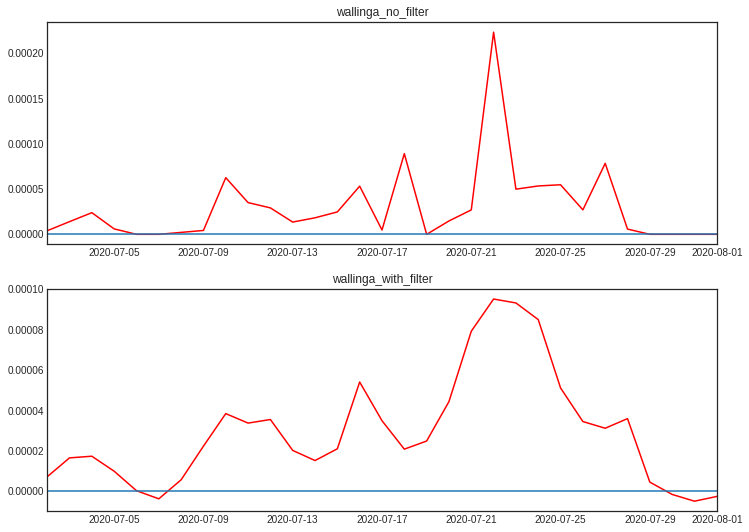

In [ ]:
# y=0으로 setting -> 말이 되지 않음
f, axes = plt.subplots(2, 1)
f.set_size_inches((12, 9))
x=pd.to_datetime(df_wall.index)
y=df_wall['Wallinga']
yhat=savgol_filter(y,15,7)
# wallinga_no_filter
axes[0].plot(x,y,'r')
axes[0].axhline(y=0)
axes[0].set_xlim([dt.date(2020,7,2),dt.date(2020,8,1)])
axes[0].set_title('wallinga_no_filter')
# wallinga_with_filter
axes[1].plot(x,yhat,'r')
axes[1].axhline(y=0)
axes[1].set_xlim([dt.date(2020,7,2),dt.date(2020,8,1)])
axes[1].set_title('wallinga_with_filter')
plt.show()

# 포스터 그래프

##result1 : 국내 변이 시각화

###python으로 계산한 데이터

####cori

In [ ]:
plt.rc('font', size=20)        # 기본 폰트 크기
plt.rc('axes', labelsize=20)   # x,y축 label 폰트 크기
plt.rc('xtick', labelsize=20)  # x축 눈금 폰트 크기
plt.rc('ytick', labelsize=20)  # y축 눈금 폰트 크기
plt.rc('legend', fontsize=20)  # 범례 폰트 크기
plt.rc('figure', titlesize=50) # figure title 폰트 크기

In [ ]:
df_variants['Delta_Rt'][df_variants['Delta_Rt']<0]=0
df_variants['Omicron_Rt'][df_variants['Omicron_Rt']<0]=0
df_variants['Others_Rt'][df_variants['Others_Rt']<0]=0

df_variants['Delta_Rt'][df_variants['Delta_Rt']>5]=0
df_variants['Omicron_Rt'][df_variants['Omicron_Rt']>5]=0
df_variants['Others_Rt'][df_variants['Others_Rt']>50]=8

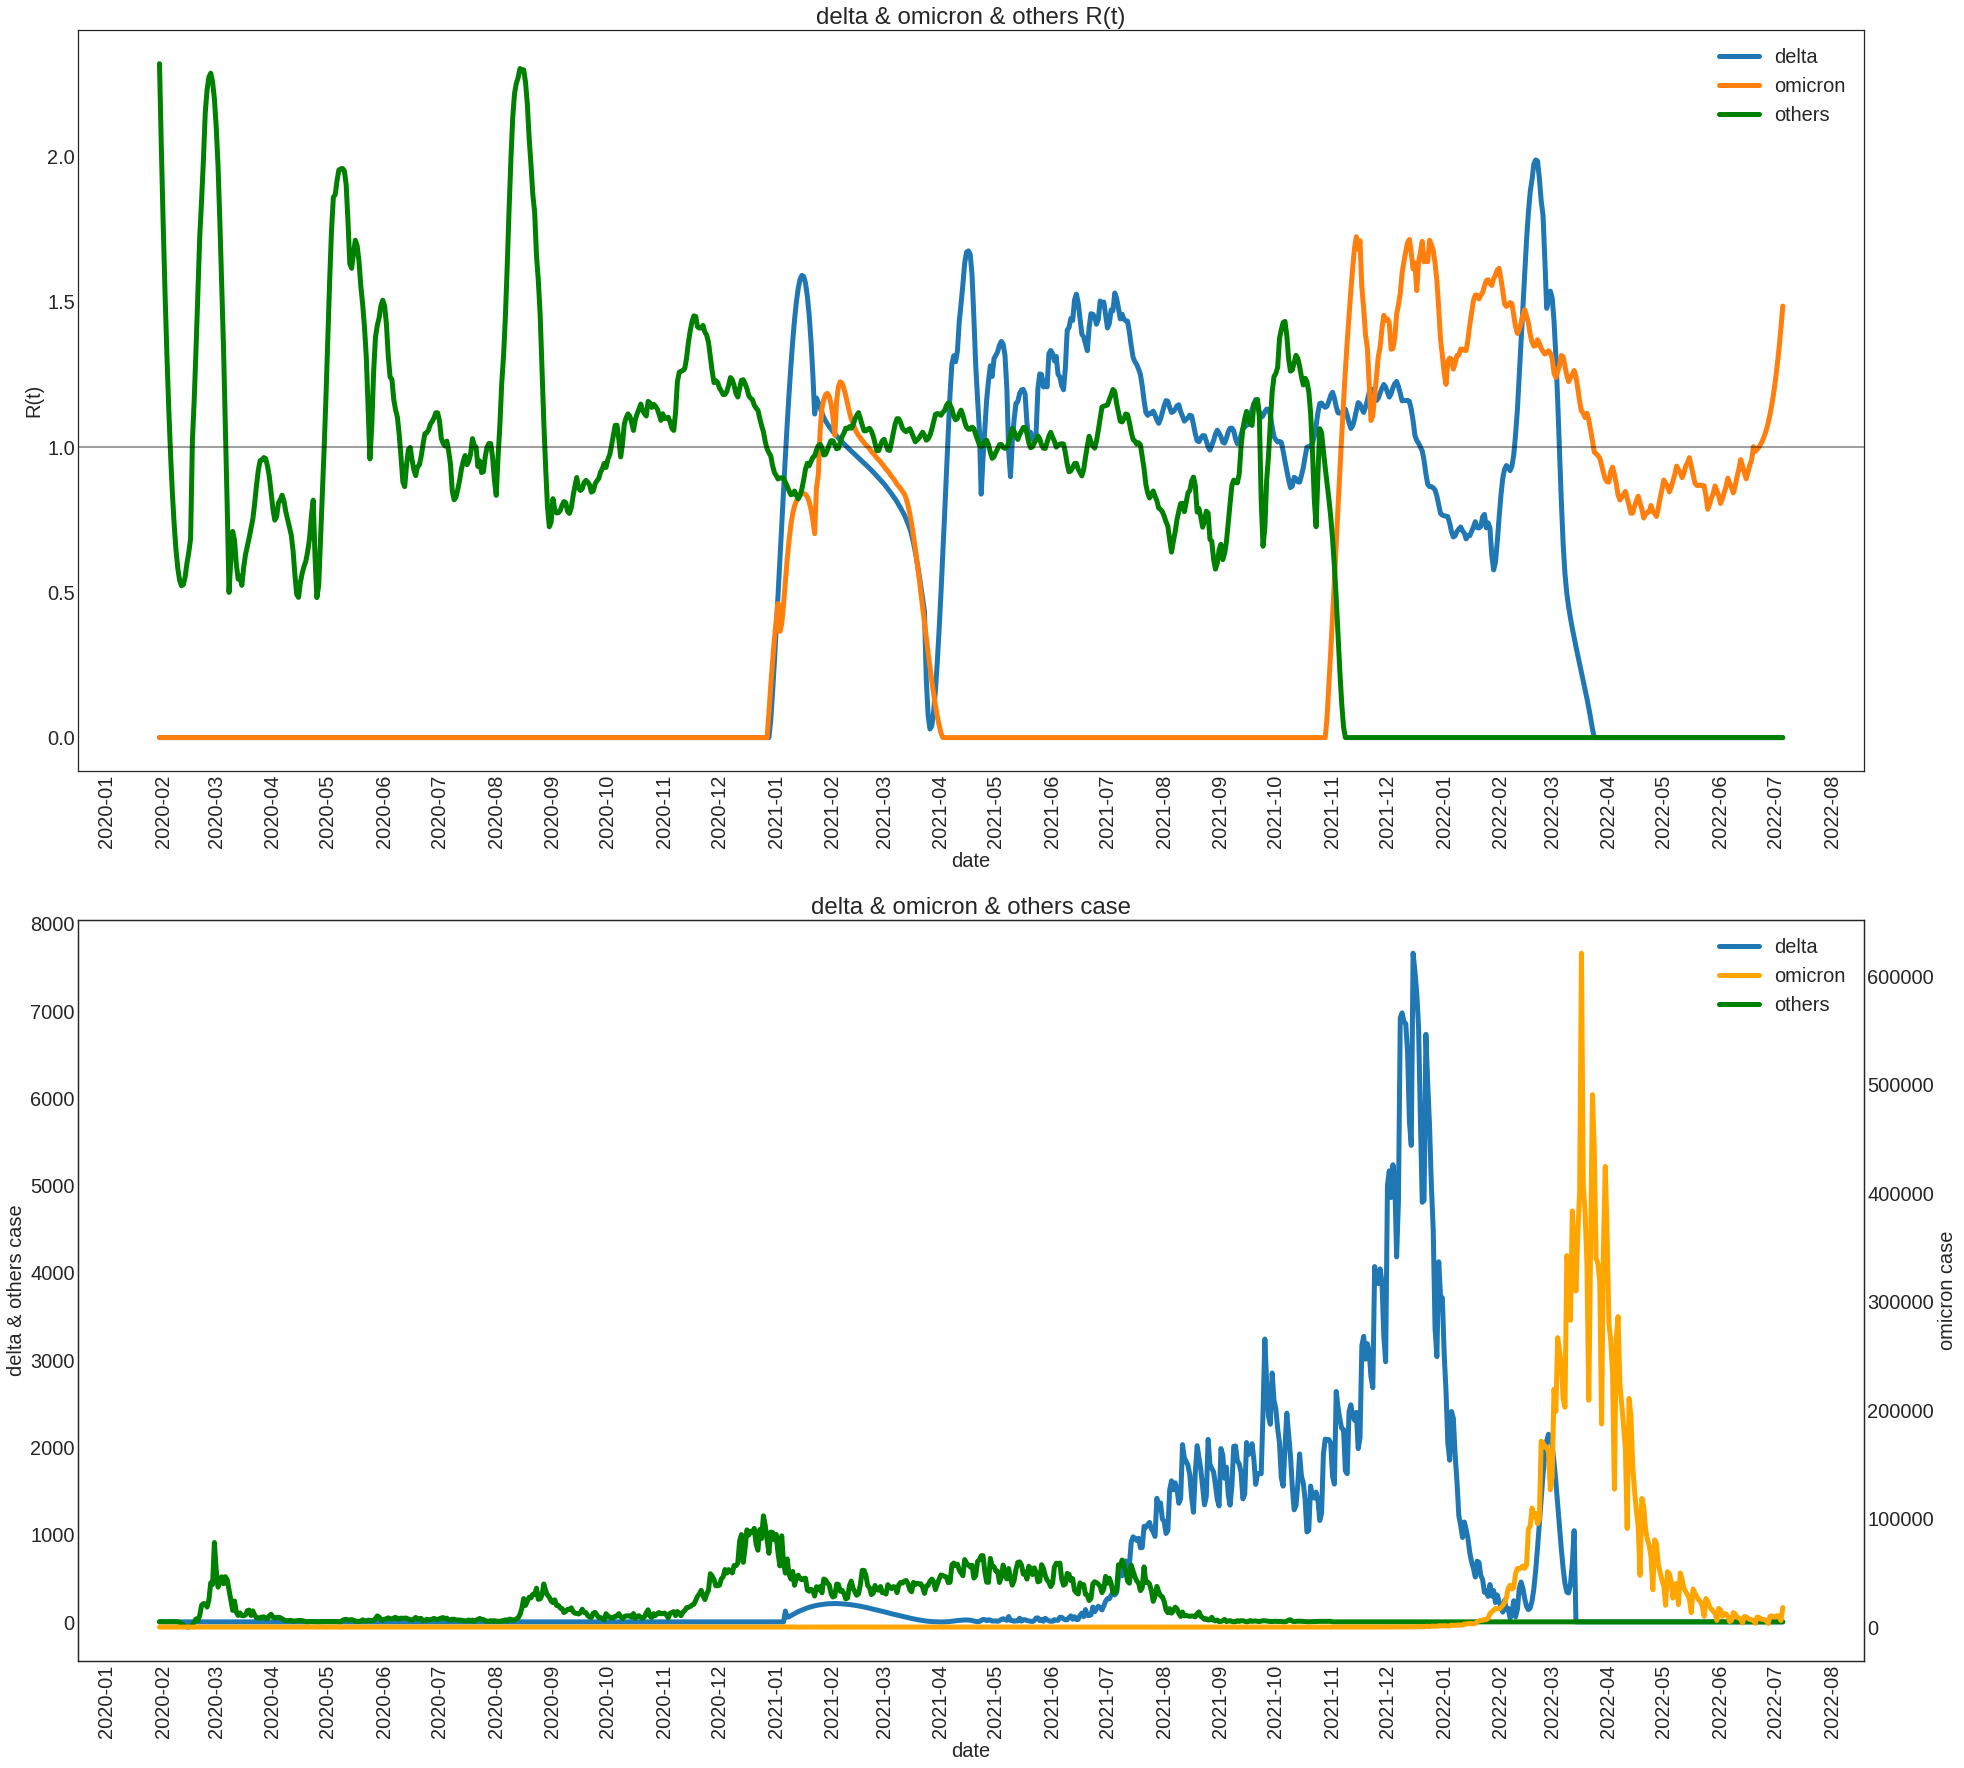

In [ ]:
from matplotlib import dates
import matplotlib.dates as mdates

f, axes = plt.subplots(2, 1)
f.set_size_inches((32, 30))

####R(t)####
#delta
delta_x=df_variants['Delta_Rt'].index
delta_y=df_variants['Delta_Rt']
delta_yhat=savgol_filter(delta_y,31,3)
delta_yhat[delta_yhat<0]=0
delta=axes[0].plot(delta_x,delta_yhat,label='delta', linewidth=5)

#omicron
omicron_x=df_variants['Omicron_Rt'].index
omicron_y=df_variants['Omicron_Rt']
omicron_yhat=savgol_filter(omicron_y,31,3)
omicron_yhat[omicron_yhat<0]=0
omicron=axes[0].plot(omicron_x,omicron_yhat,label='omicron', linewidth=5)

#others
others_x=df_variants['Others_Rt'].index
others_y=df_variants['Others_Rt']
others_yhat=savgol_filter(others_y,31,3)
others_yhat[others_yhat<0]=0
others=axes[0].plot(others_x,others_yhat,'g',label='others', linewidth=5)

axes[0].set_xlabel('date')
axes[0].set_ylabel('R(t)')
axes[0].axhline(y=1,color='black',alpha=0.5)
axes[0].legend()
axes[0].set_title('delta & omicron & others R(t)')
axes[0].set_xticklabels(delta_x,rotation=90)
axes[0].xaxis.set_major_locator(dates.MonthLocator(interval=1))
dateFmt = mdates.DateFormatter('%Y-%m')
axes[0].xaxis.set_major_formatter(dateFmt)

####case####
#delta
delta_x=df_cases['Delta_p'].index
delta_y=df_cases['Delta_p']
delta=axes[1].plot(delta_x,delta_y,label='delta', linewidth=5)

#omicron
ax2 = axes[1].twinx()
omicron_x=df_cases['Omicron_p'].index
omicron_y=df_cases['Omicron_p']
omicron=ax2.plot(omicron_x,omicron_y,'orange',label='omicron', linewidth=5)

#others
others_x=df_cases['Others_p'].index
others_y=df_cases['Others_p']
others=axes[1].plot(others_x,others_y,'g',label='others', linewidth=5)

axes[1].set_xlabel('date')
axes[1].set_ylabel('delta & others case')
ax2.set_ylabel('omicron case')

#범례 설정
lns = delta+omicron+others
labs = [l.get_label() for l in lns]
axes[1].legend(lns, labs, loc=0)
#제목 설정
axes[1].set_title('delta & omicron & others case')
# 축 설정
axes[1].set_xticklabels(delta_x,rotation=90)
axes[1].xaxis.set_major_locator(dates.MonthLocator(interval=1))
dateFmt = mdates.DateFormatter('%Y-%m')
axes[1].xaxis.set_major_formatter(dateFmt)

plt.show()

####bettencourt

In [ ]:
plt.rc('font', size=20)        # 기본 폰트 크기
plt.rc('axes', labelsize=20)   # x,y축 label 폰트 크기
plt.rc('xtick', labelsize=20)  # x축 눈금 폰트 크기
plt.rc('ytick', labelsize=20)  # y축 눈금 폰트 크기
plt.rc('legend', fontsize=20)  # 범례 폰트 크기
plt.rc('figure', titlesize=50) # figure title 폰트 크기

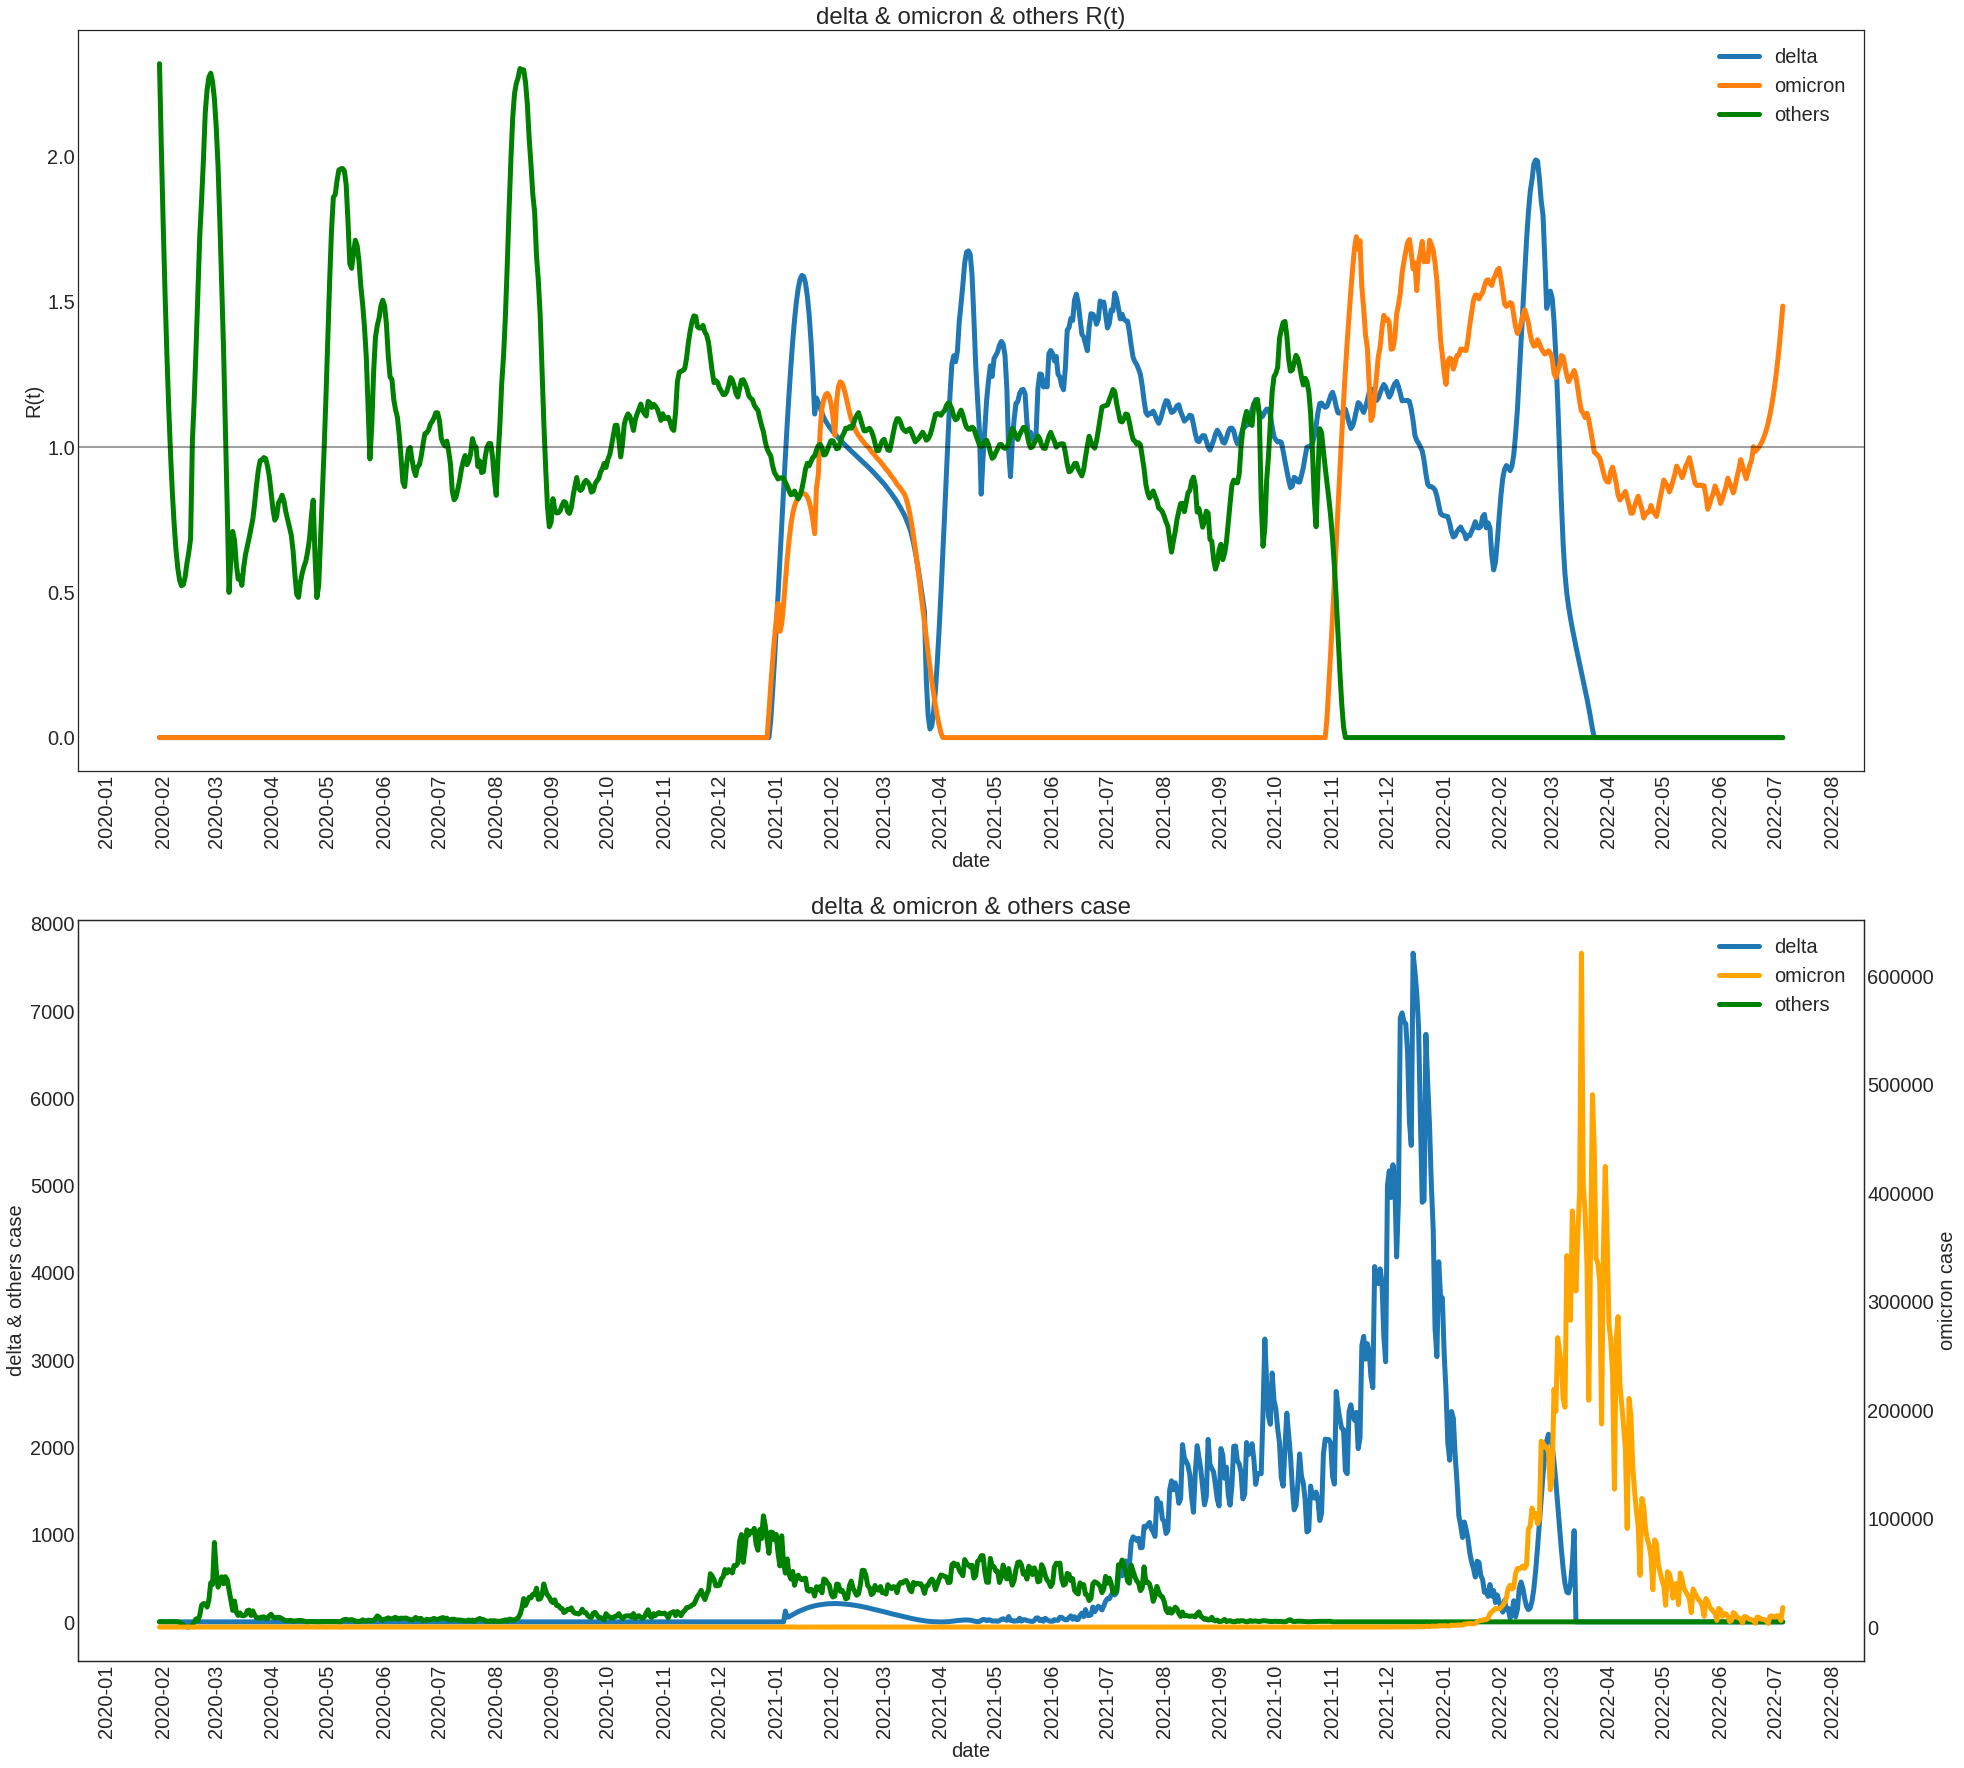

In [ ]:
from matplotlib import dates
import matplotlib.dates as mdates

f, axes = plt.subplots(2, 1)
f.set_size_inches((32, 30))

####R(t)####
#delta
delta_x=df_variants['Delta_Rt'].index
delta_y=df_variants['Delta_Rt']
delta_yhat=savgol_filter(delta_y,31,3)
delta_yhat[delta_yhat<0]=0
delta=axes[0].plot(delta_x,delta_yhat,label='delta', linewidth=5)

#omicron
omicron_x=df_variants['Omicron_Rt'].index
omicron_y=df_variants['Omicron_Rt']
omicron_yhat=savgol_filter(omicron_y,31,3)
omicron_yhat[omicron_yhat<0]=0
omicron=axes[0].plot(omicron_x,omicron_yhat,label='omicron', linewidth=5)

#others
others_x=df_variants['Others_Rt'].index
others_y=df_variants['Others_Rt']
others_yhat=savgol_filter(others_y,31,3)
others_yhat[others_yhat<0]=0
others=axes[0].plot(others_x,others_yhat,'g',label='others', linewidth=5)

axes[0].set_xlabel('date')
axes[0].set_ylabel('R(t)')
axes[0].axhline(y=1,color='black',alpha=0.5)
axes[0].legend()
axes[0].set_title('delta & omicron & others R(t)')
axes[0].set_xticklabels(delta_x,rotation=90)
axes[0].xaxis.set_major_locator(dates.MonthLocator(interval=1))
dateFmt = mdates.DateFormatter('%Y-%m')
axes[0].xaxis.set_major_formatter(dateFmt)

####case####
#delta
delta_x=df_cases['Delta_p'].index
delta_y=df_cases['Delta_p']
delta=axes[1].plot(delta_x,delta_y,label='delta', linewidth=5)

#omicron
ax2 = axes[1].twinx()
omicron_x=df_cases['Omicron_p'].index
omicron_y=df_cases['Omicron_p']
omicron=ax2.plot(omicron_x,omicron_y,'orange',label='omicron', linewidth=5)

#others
others_x=df_cases['Others_p'].index
others_y=df_cases['Others_p']
others=axes[1].plot(others_x,others_y,'g',label='others', linewidth=5)

axes[1].set_xlabel('date')
axes[1].set_ylabel('delta & others case')
ax2.set_ylabel('omicron case')

#범례 설정
lns = delta+omicron+others
labs = [l.get_label() for l in lns]
axes[1].legend(lns, labs, loc=0)
#제목 설정
axes[1].set_title('delta & omicron & others case')
# 축 설정
axes[1].set_xticklabels(delta_x,rotation=90)
axes[1].xaxis.set_major_locator(dates.MonthLocator(interval=1))
dateFmt = mdates.DateFormatter('%Y-%m')
axes[1].xaxis.set_major_formatter(dateFmt)

plt.show()

###R로 만든 데이터 -> python으로 Rt 계산

In [ ]:
plt.rc('font', size=20)        # 기본 폰트 크기
plt.rc('axes', labelsize=20)   # x,y축 label 폰트 크기
plt.rc('xtick', labelsize=20)  # x축 눈금 폰트 크기
plt.rc('ytick', labelsize=20)  # y축 눈금 폰트 크기
plt.rc('legend', fontsize=20)  # 범례 폰트 크기
plt.rc('figure', titlesize=20) # figure title 폰트 크기

In [ ]:
R_case=pd.read_excel('/content/drive/MyDrive/통계 학부 연구/case_korea_varient.xlsx')
# 확진자 급격하게 떨어지는 부분 확인용
#R_case['date']=df_variants.index
#==> index 342 343 344 : 667 -> (125 56 58) -> 581 -> 391 -> 467 <= 급격하게 떨어지는 것을 확인
R_case.loc[342,'Delta']=529
R_case.loc[343,'Delta']=391
R_case.loc[344,'Delta']=467
R_case

Delta  Omicron  others  total
0        1        1       1      1
1        1        1       3      3
2        0        0       0      0
3        1        1       1      1
4        0        0       0      0
..     ...      ...     ...    ...
883      0     9382       0   9382
884      0    10542       0  10542
885      0     9868       0   9868
886      0     6089       0   6089
887      0    17976       0  17976

[888 rows x 4 columns]

####cori

In [ ]:
# 각 변이 별로 Rt를 계산하는 그래프
cori=[]
for i in range(len(R_case.columns)):
  temp=[]
  variant=R_case.iloc[:,i] # 각 변이 그래프를 불러옴
  for j in range(len(variant.index)):
    temp.append(Cori(j,variant,W(len(R_case))))
  cori.append(temp) # list에 저장

In [ ]:
R_rt=pd.DataFrame(cori,index=['Delta_Rt','Omicron_Rt','Others_Rt','Total_Rt'],columns=df_variants.index)
R_rt=R_rt.transpose()
R_rt

Delta_Rt  Omicron_Rt  Others_Rt  Total_Rt
2020-01-30   0.00000    0.000000    0.00000  0.000000
2020-01-31   0.00000    0.000000    0.00000  0.000000
2020-02-01   0.00000    0.000000    0.00000  0.000000
2020-02-02   5.55513    5.555130    1.85171  1.851710
2020-02-03   0.00000    0.000000    0.00000  0.000000
...              ...         ...        ...       ...
2022-07-01   0.00000    1.247842    0.00000  1.247842
2022-07-02   0.00000    1.303823    0.00000  1.303823
2022-07-03   0.00000    1.143198    0.00000  1.143198
2022-07-04   0.00000    0.674119    0.00000  0.674119
2022-07-05   0.00000    2.028468    0.00000  2.028468

[888 rows x 4 columns]

####bettencourt

In [ ]:
bett=[]
for i in range(len(R_case.columns)):
  temp=[]
  variant=R_case.iloc[:,i] # 각 변이 그래프를 불러옴
  for j in range(len(variant.index)-1):
    temp.append(Bett(j,variant,g1))
  bett.append(temp) # list에 저장

In [ ]:
R_bett=pd.DataFrame(bett,index=['Delta_Rt','Omicron_Rt','Others_Rt','Total_Rt'],columns=df_variants.index[:-1])
R_bett=R_bett.transpose()
R_bett

####그래프

In [ ]:
R_bett[R_bett<0]=1
R_bett = R_bett.replace([np.nan, np.inf, -np.inf], 1)

In [ ]:
R_bett

Delta_Rt  Omicron_Rt  Others_Rt  Total_Rt
2020-01-30       1.0    1.000000   1.001664  1.001664
2020-01-31       1.0    1.000000   1.000000  1.000000
2020-02-01       1.0    1.000000   1.000000  1.000000
2020-02-02       1.0    1.000000   1.000000  1.000000
2020-02-03       1.0    1.000000   1.000000  1.000000
...              ...         ...        ...       ...
2022-06-30       1.0    0.999989   1.000000  0.999989
2022-07-01       1.0    1.000177   1.000000  1.000177
2022-07-02       1.0    0.999900   1.000000  0.999900
2022-07-03       1.0    0.999269   1.000000  0.999269
2022-07-04       1.0    1.001640   1.000000  1.001640

[887 rows x 4 columns]

In [ ]:
R_rt['Delta_Rt'][R_rt['Delta_Rt']<0]=0
R_rt['Omicron_Rt'][R_rt['Omicron_Rt']<0]=0
R_rt['Others_Rt'][R_rt['Others_Rt']<0]=0
R_rt['Total_Rt'][R_rt['Total_Rt']<0]=0

R_rt['Delta_Rt'][R_rt['Delta_Rt']>50]=8
R_rt['Omicron_Rt'][R_rt['Omicron_Rt']>50]=8
R_rt['Others_Rt'][R_rt['Others_Rt']>50]=8
R_rt['Total_Rt'][R_rt['Total_Rt']>50]=8

In [ ]:
plt.rc('font', size=30)        # 기본 폰트 크기
plt.rc('axes', labelsize=30)   # x,y축 label 폰트 크기
plt.rc('xtick', labelsize=30)  # x축 눈금 폰트 크기
plt.rc('ytick', labelsize=30)  # y축 눈금 폰트 크기
plt.rc('legend', fontsize=30)  # 범례 폰트 크기
plt.rc('figure', titlesize=30) # figure title 폰트 크기

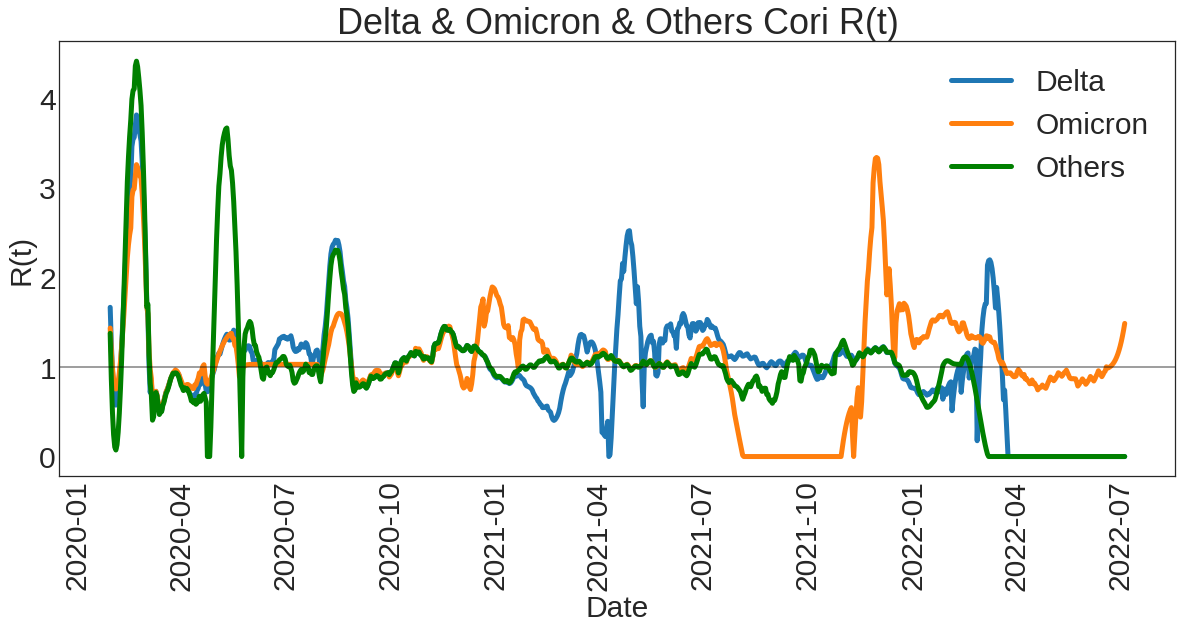

In [ ]:
from matplotlib import dates
import matplotlib.dates as mdates

fig, ax1=plt.subplots(figsize=(20,8))
f.patch.set_alpha(0)

####R(t) - cori####
#delta
delta_x=R_rt['Delta_Rt'].index
delta_y=R_rt['Delta_Rt']
delta_yhat=savgol_filter(delta_y,31,3)
delta_yhat[delta_yhat<0]=0
delta=ax1.plot(delta_x,delta_yhat,label='Delta', linewidth=5)

#omicron
omicron_x=R_rt['Omicron_Rt'].index
omicron_y=R_rt['Omicron_Rt']
omicron_yhat=savgol_filter(omicron_y,31,3)
omicron_yhat[omicron_yhat<0]=0
omicron=ax1.plot(omicron_x,omicron_yhat,label='Omicron', linewidth=5)

#others
others_x=R_rt['Others_Rt'].index
others_y=R_rt['Others_Rt']
others_yhat=savgol_filter(others_y,31,3)
others_yhat[others_yhat<0]=0
others=ax1.plot(others_x,others_yhat,'g',label='Others', linewidth=5)

ax1.set_xlabel('Date')
ax1.set_ylabel('R(t)')
ax1.axhline(y=1,color='black',alpha=0.5)
ax1.legend()
ax1.set_title('Delta & Omicron & Others Cori R(t)')
ax1.set_xticklabels(delta_x,rotation=90)
ax1.xaxis.set_major_locator(dates.MonthLocator(interval=3))
dateFmt = mdates.DateFormatter('%Y-%m')
ax1.xaxis.set_major_formatter(dateFmt)
plt.show()

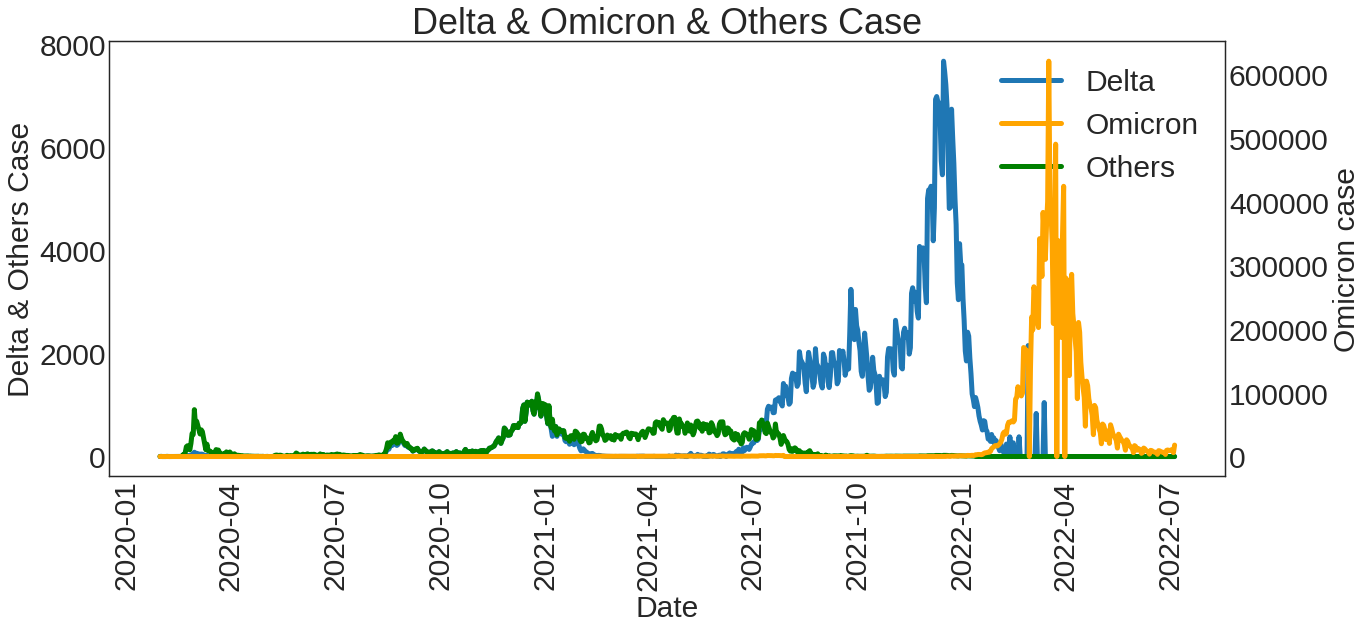

In [ ]:
from matplotlib import dates
import matplotlib.dates as mdates

fig, ax1=plt.subplots(figsize=(10,4))
f.patch.set_alpha(0)

ax1=fig.add_subplot(figsize=(20,8))

####case####
#delta
delta_x=df_variants.index
delta_y=R_case['Delta']
delta=ax1.plot(delta_x,delta_y,label='Delta', linewidth=5)

#omicron
ax2 = ax1.twinx()
omicron_x=df_variants.index
omicron_y=R_case['Omicron']
omicron=ax2.plot(omicron_x,omicron_y,'orange',label='Omicron', linewidth=5)

#others
others_x=df_variants.index
others_y=R_case['others']
others=ax1.plot(others_x,others_y,'g',label='Others', linewidth=5)

ax1.set_xlabel('Date')
ax1.set_ylabel('Delta & Others Case')
ax2.set_ylabel('Omicron case')

#범례 설정
lns = delta+omicron+others
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)
#제목 설정
ax1.set_title('Delta & Omicron & Others Case')
# 축 설정
ax1.set_xticklabels(delta_x,rotation=90)
ax1.xaxis.set_major_locator(dates.MonthLocator(interval=3))
dateFmt = mdates.DateFormatter('%Y-%m')
ax1.xaxis.set_major_formatter(dateFmt)

plt.show()

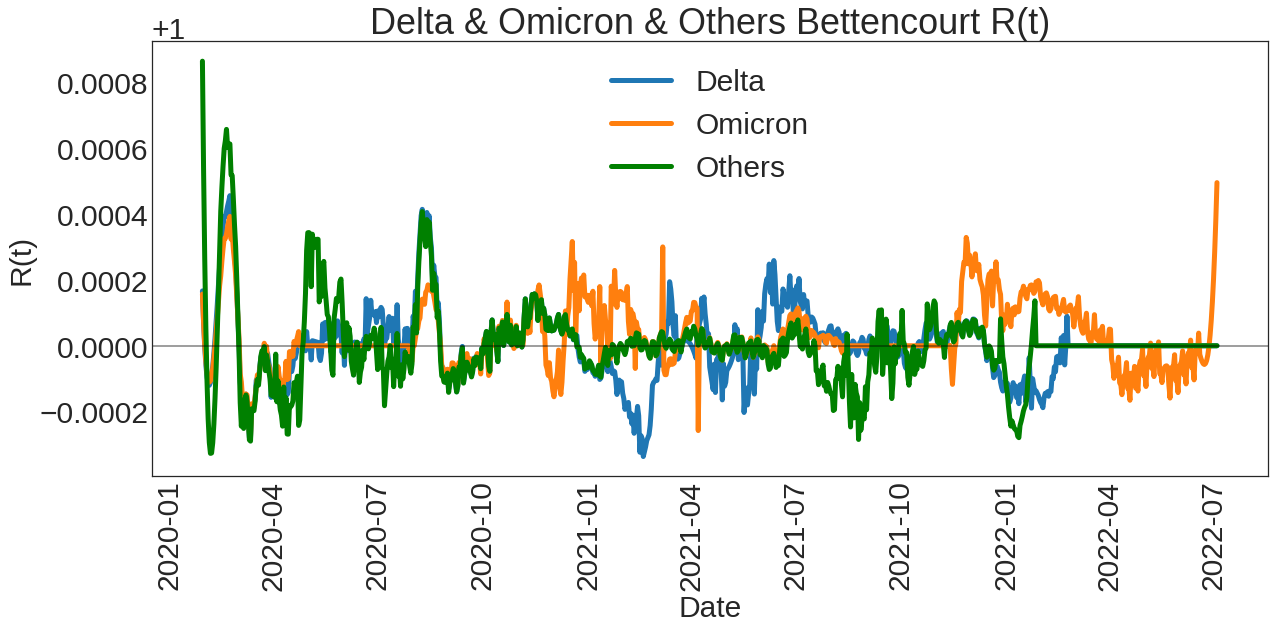

In [ ]:
from matplotlib import dates
import matplotlib.dates as mdates

fig, ax1=plt.subplots(figsize=(20,8))
f.patch.set_alpha(0)

####R(t)-Bettencourt####
#delta
delta_x=R_bett['Delta_Rt'].index
delta_y=R_bett['Delta_Rt']
delta_yhat=savgol_filter(delta_y,31,3)
delta_yhat[delta_yhat<0]=0
#delta=axes[2].plot(delta_x,delta_y,label='delta', linewidth=5)
delta=ax1.plot(delta_x,delta_yhat,label='Delta', linewidth=5)

#omicron
omicron_x=R_bett['Omicron_Rt'].index
omicron_y=R_bett['Omicron_Rt']
omicron_yhat=savgol_filter(omicron_y,31,3)
omicron_yhat[omicron_yhat<0]=0
#omicron=axes[2].plot(omicron_x,omicron_y,label='omicron', linewidth=5)
omicron=ax1.plot(omicron_x,omicron_yhat,label='Omicron', linewidth=5)

#others
others_x=R_bett['Others_Rt'].index
others_y=R_bett['Others_Rt']
others_yhat=savgol_filter(others_y,31,3)
others_yhat[others_yhat<0]=0
#others=axes[2].plot(others_x,others_y,'g',label='others', linewidth=5)
others=ax1.plot(others_x,others_yhat,'g',label='Others', linewidth=5)

ax1.set_xlabel('Date')
ax1.set_ylabel('R(t)')
ax1.axhline(y=1,color='black',alpha=0.5)
ax1.legend()
ax1.set_title('Delta & Omicron & Others Bettencourt R(t)')
ax1.set_xticklabels(delta_x,rotation=90)
ax1.xaxis.set_major_locator(dates.MonthLocator(interval=3))
dateFmt = mdates.DateFormatter('%Y-%m')
ax1.xaxis.set_major_formatter(dateFmt)

plt.show()

##result2 : 해외 변이 시각화

###Rt+case

####Rt+case함수

In [ ]:
def result_2_1(x,y,data,case,country): # (x,y):subplot의 위치, data : 사용되는 데이터, case : 확진자 변수 이름(국내와 해외가 달라서 설정), country : 나라 이름
  #delta
  delta_x=data['Delta_Rt'].index
  delta_y=data['Delta_Rt']
  delta_yhat=savgol_filter(delta_y,31,3)
  delta_yhat[delta_yhat<0]=0
  delta=axes[x][y].plot(delta_x,delta_yhat,label='delta', linewidth=5)

  #omicron
  omicron_x=data['Omicron_Rt'].index
  omicron_y=data['Omicron_Rt']
  omicron_yhat=savgol_filter(omicron_y,31,3)
  omicron_yhat[omicron_yhat<0]=0
  omicron=axes[x][y].plot(omicron_x,omicron_yhat,label='omicron', linewidth=5)

  #others
  others_x=data['Others_Rt'].index
  others_y=data['Others_Rt']
  others_yhat=savgol_filter(others_y,31,3)
  others_yhat[others_yhat<0]=0
  others=axes[x][y].plot(others_x,others_yhat,'g',label='others', linewidth=5)

  #case
  ax = axes[x][y].twinx()
  x1=data[case].index
  y1=data[case]
  case=ax.plot(x1,y1,'r',label='case', linewidth=4)

  # 범례
  lns = delta+omicron+others+case
  labs = [l.get_label() for l in lns]
  axes[x][y].legend(lns, labs, loc=0)

  axes[x][y].set_xlabel('date')
  axes[x][y].set_ylabel('R(t)')
  ax.set_ylabel('case')
  axes[x][y].axhline(y=1,color='black',alpha=0.5)
  axes[x][y].set_title(country, fontsize=50)

####그래프 : Rt+case

In [ ]:
plt.rc('font', size=20)        # 기본 폰트 크기
plt.rc('axes', labelsize=30)   # x,y축 label 폰트 크기
plt.rc('xtick', labelsize=30)  # x축 눈금 폰트 크기
plt.rc('ytick', labelsize=30)  # y축 눈금 폰트 크기
plt.rc('legend', fontsize=30)  # 범례 폰트 크기

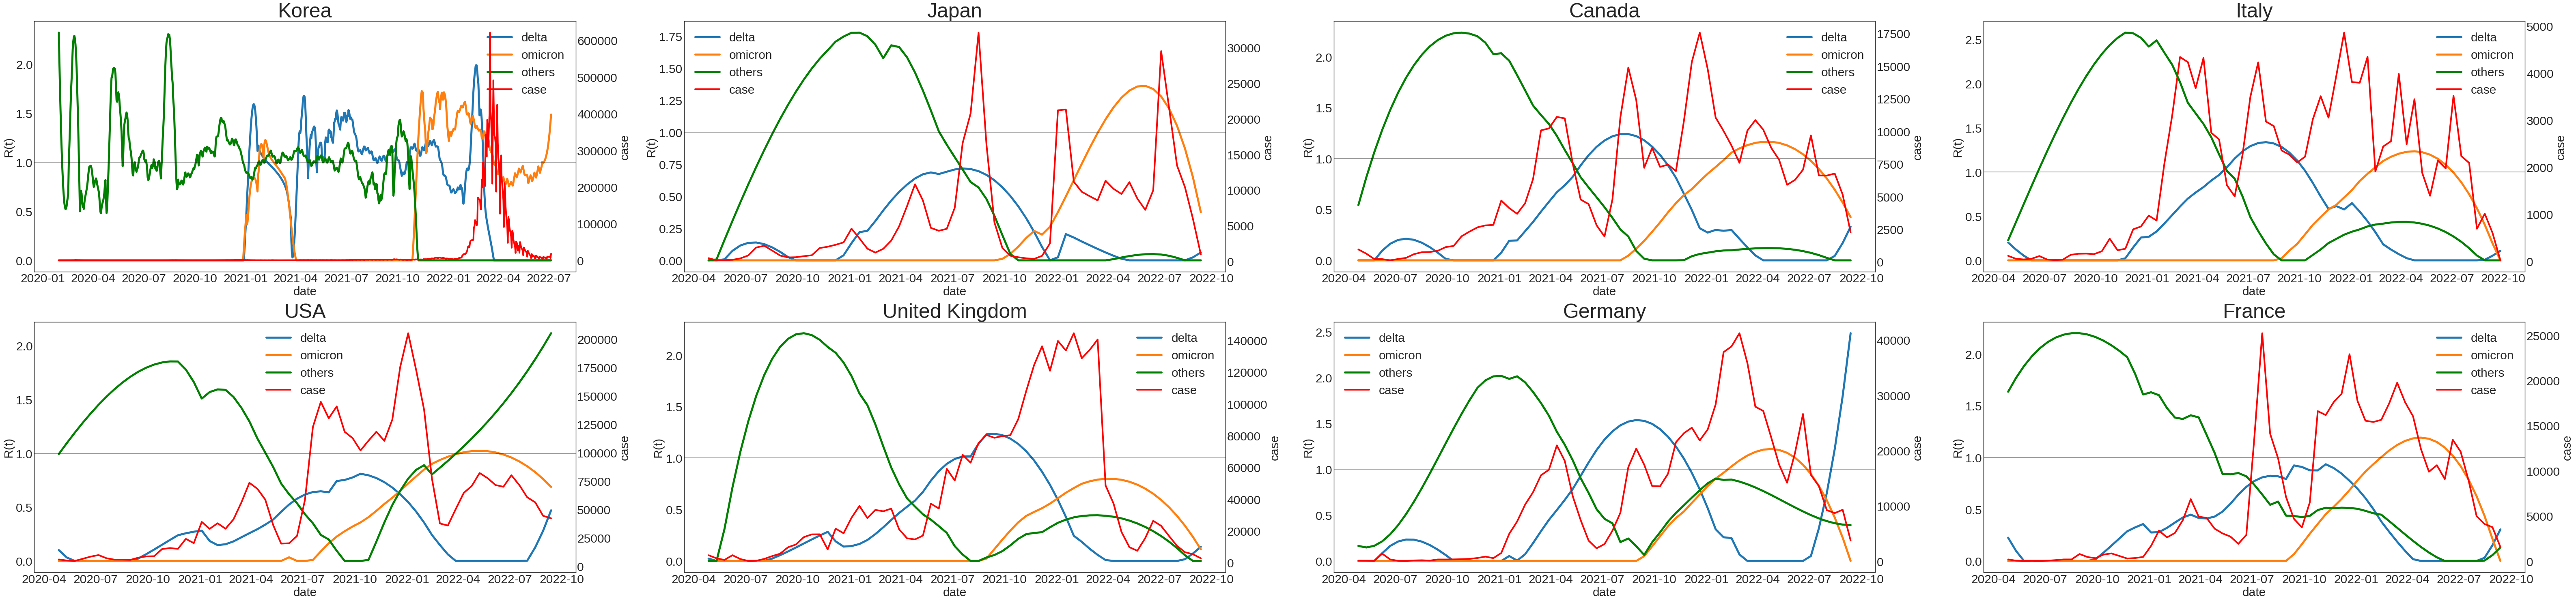

In [ ]:
pd.set_option('mode.chained_assignment',  None)
f, axes = plt.subplots(2, 4)
f.set_size_inches((110, 25))

#### Korea ####
result_2_1(0,0,df_variants,'total','Korea')

#### Japan ####
result_2_1(0,1,df_japan,'total_sequences','Japan')

#### Canada ####
result_2_1(0,2,df_canada,'total_sequences','Canada')

#### Italy ####
result_2_1(0,3,df_italy,'total_sequences','Italy')

#### USA ####
result_2_1(1,0,df_usa,'total_sequences','USA')

#### United Kingdom ####
result_2_1(1,1,df_uk,'total_sequences','United Kingdom')

#### Germany ####
result_2_1(1,2,df_ger,'total_sequences','Germany')

#### France ####
result_2_1(1,3,df_fra,'total_sequences','France')

plt.show()

###Rt, case 따로

####Rt 함수

In [ ]:
def result_2_2(x,data,country): # (x,y):subplot의 위치, data : 사용되는 데이터, country : 나라 이름
  #total
  total_x=data['Total_Rt'].index
  total_y=data['Total_Rt']
  total_yhat=savgol_filter(total_y,31,3)
  total_yhat[total_yhat<0]=0
  total=axes[x].plot(total_x,total_yhat,label='total', linewidth=5)

  #delta
  delta_x=data['Delta_Rt'].index
  delta_y=data['Delta_Rt']
  delta_yhat=savgol_filter(delta_y,31,3)
  delta_yhat[delta_yhat<0]=0
  delta=axes[x].plot(delta_x,delta_yhat,label='delta', linewidth=5)

  #omicron
  omicron_x=data['Omicron_Rt'].index
  omicron_y=data['Omicron_Rt']
  omicron_yhat=savgol_filter(omicron_y,31,3)
  omicron_yhat[omicron_yhat<0]=0
  omicron=axes[x].plot(omicron_x,omicron_yhat,label='omicron', linewidth=5)

  #others
  others_x=data['Others_Rt'].index
  others_y=data['Others_Rt']
  others_yhat=savgol_filter(others_y,31,3)
  others_yhat[others_yhat<0]=0
  others=axes[x].plot(others_x,others_yhat,label='others', linewidth=5)

  axes[x].legend()
  axes[x].set_xlabel('Date')
  axes[x].set_ylabel('R(t)')
  axes[x].axhline(y=1,color='black',alpha=0.5, linewidth=5)
  axes[x].set_title(country, fontsize=50)
  axes[x].set_xticklabels(data['Total_Rt'].index,rotation=90)
  axes[x].xaxis.set_major_locator(dates.MonthLocator(interval=3))
  dateFmt = mdates.DateFormatter('%Y-%m')
  axes[x].xaxis.set_major_formatter(dateFmt)

####case 함수

In [ ]:
def result_2_3(x,data,total,delta,omicron,others,country): # (x,y):subplot의 위치, data : 사용되는 데이터, (total,delta,omicron,others) : 확진자 변수 이름(국내와 해외가 달라서 설정), country : 나라 이름

  world_cases=pd.DataFrame()
  world_cases['total']=data[total]
  world_cases['delta']=data[delta]
  world_cases['omicron']=data[omicron]
  world_cases['others']=data[others]

  world_cases.plot(ax=axes[x],linewidth=5)

  #axes[x].legend()
  axes[x].set_xlabel('Date')
  axes[x].set_ylabel('Case')
  axes[x].set_title(country, fontsize=50)

####그래프 : Rt, case 따로

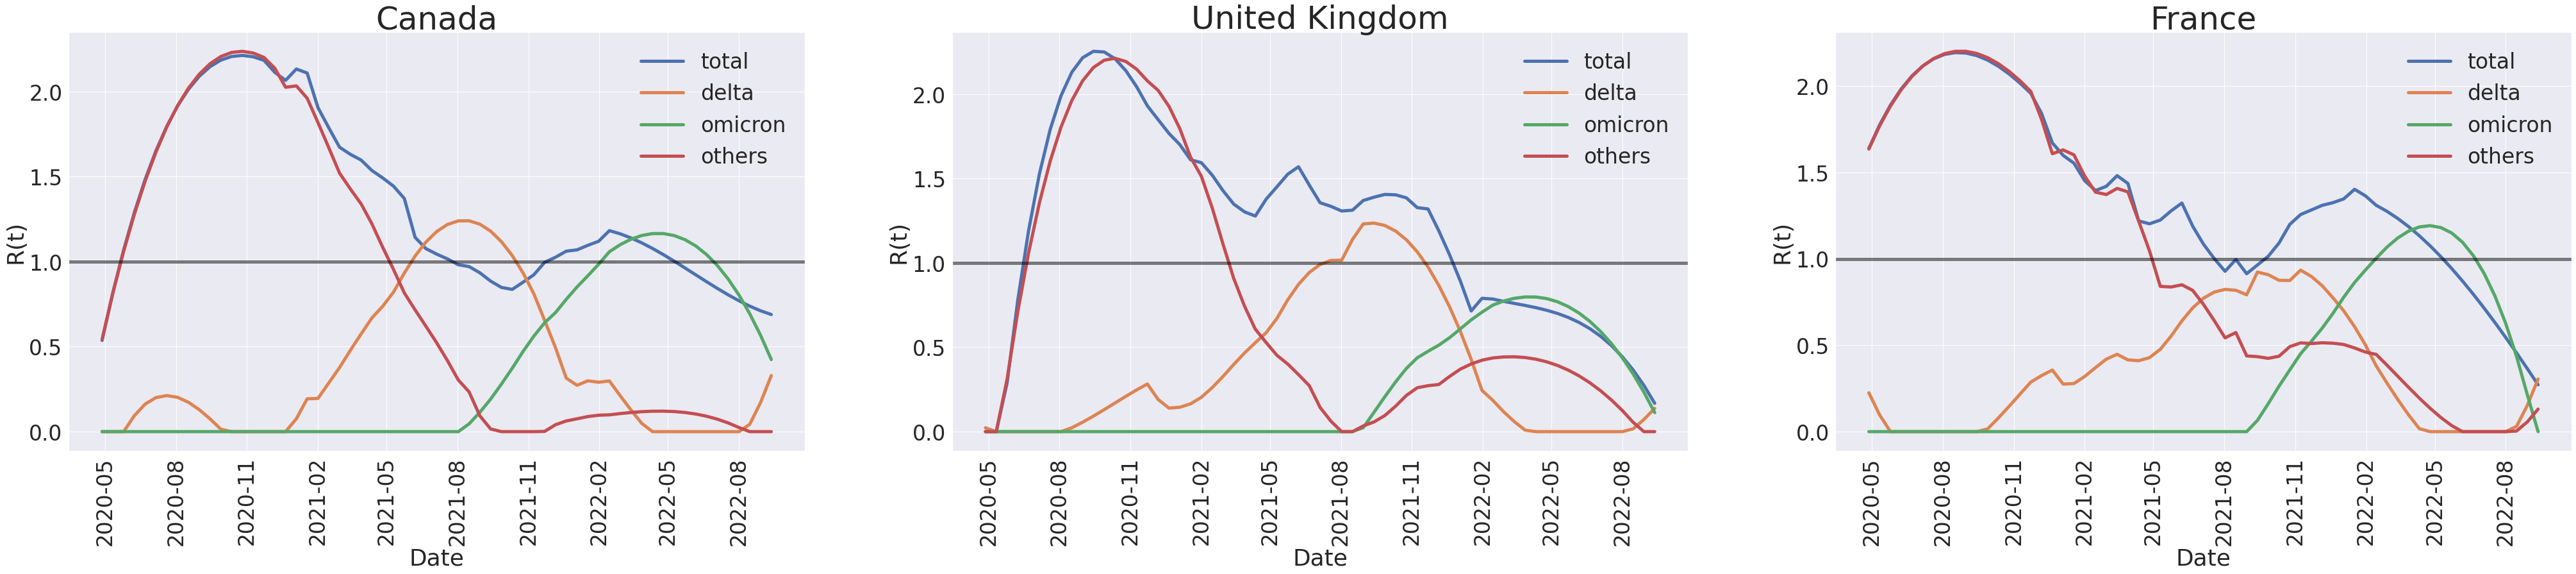

In [ ]:
pd.set_option('mode.chained_assignment',  None)
f, axes = plt.subplots(1, 3)
f.set_size_inches((70, 12))

#### Canada ####
result_2_2(0,df_canada,'Canada')

#### United Kingdom ####
result_2_2(1,df_uk,'United Kingdom')

#### France ####
result_2_2(2,df_fra,'France')

plt.show()

In [ ]:
# pd.set_option('mode.chained_assignment',  None)
# f, axes = plt.subplots(2, 4)
# f.set_size_inches((100, 25))

# #### Korea ####
# result_2_2(0,0,R_rt,'Korea')

# #### Japan ####
# result_2_2(0,1,df_japan,'Japan')

# #### Canada ####
# result_2_2(0,2,df_canada,'Canada')

# #### Italy ####
# result_2_2(0,3,df_italy,'Italy')

# #### USA ####
# result_2_2(1,0,df_usa,'USA')

# #### United Kingdom ####
# result_2_2(1,1,df_uk,'United Kingdom')

# #### Germany ####
# result_2_2(1,2,df_ger,'Germany')

# #### France ####
# result_2_2(1,3,df_fra,'France')

# plt.show()

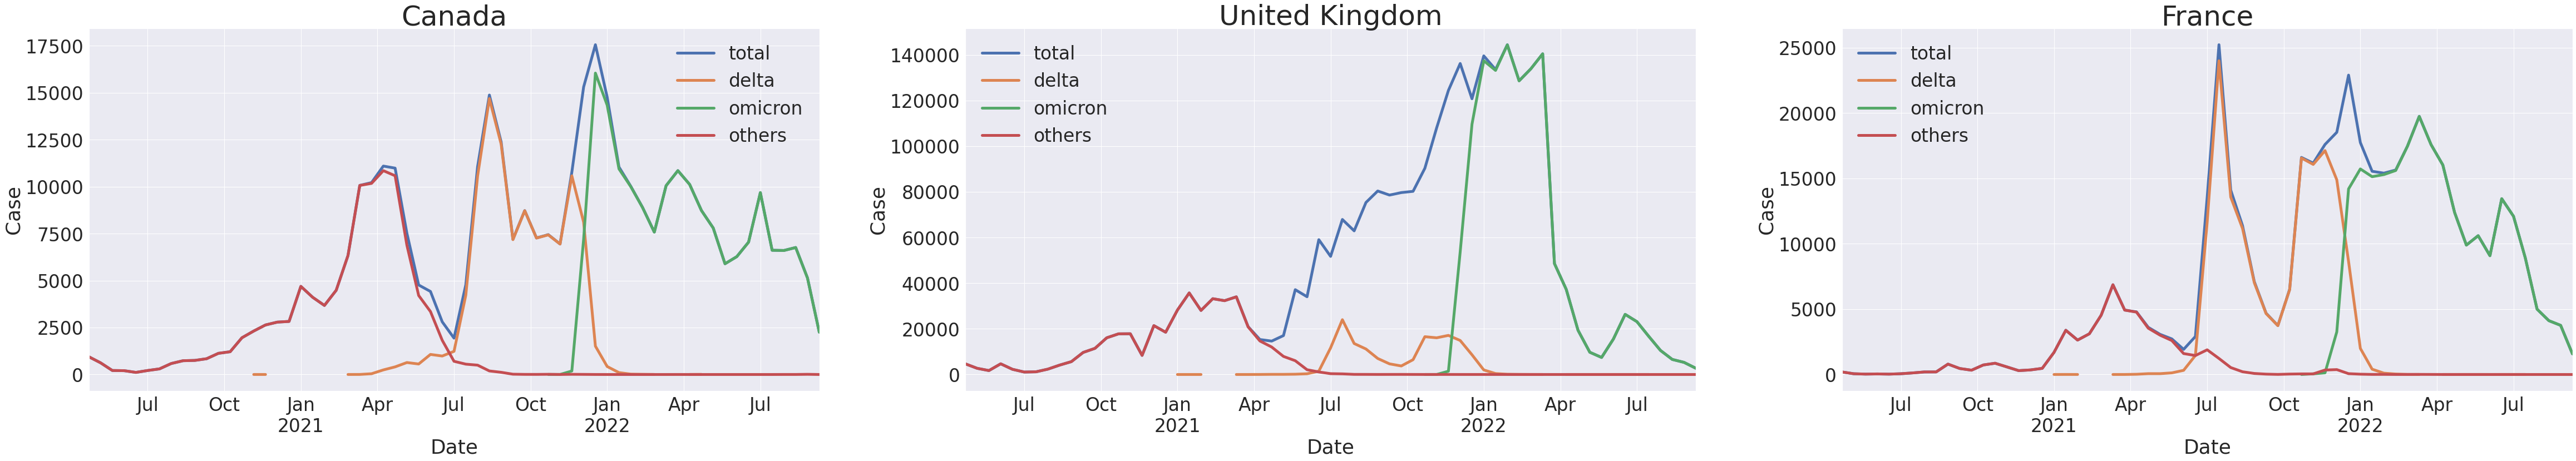

In [ ]:
pd.set_option('mode.chained_assignment',  None)
f, axes = plt.subplots(1, 3)
f.set_size_inches((80, 12))

#### Canada ####
result_2_3(0,df_canada,'total_sequences','delta','omicron','others','Canada')

#### United Kingdom ####
result_2_3(1,df_uk,'total_sequences','delta','omicron','others','United Kingdom')

#### France ####
result_2_3(2,df_fra,'total_sequences','delta','omicron','others','France')

plt.show()

In [ ]:
# pd.set_option('mode.chained_assignment',  None)
# f, axes = plt.subplots(2, 4)
# f.set_size_inches((100, 25))

# #### Korea ####
# #total
# total_x=df_variants.index
# total_y=R_case['Delta']
# total=axes[0][0].plot(total_x,total_y,label='total', linewidth=5)

# #delta
# delta_x=df_variants.index
# delta_y=R_case['Delta']
# delta=axes[0][0].plot(delta_x,delta_y,label='delta', linewidth=5)

# #omicron
# ax2 = axes[0][0].twinx()
# omicron_x=df_variants.index
# omicron_y=R_case['Omicron']
# omicron=ax2.plot(omicron_x,omicron_y,'orange',label='omicron', linewidth=5)

# #others
# others_x=df_variants.index
# others_y=R_case['others']
# others=axes[0][0].plot(others_x,others_y,'g',label='others', linewidth=5)

# lns = total+delta+omicron+others
# labs = [l.get_label() for l in lns]
# axes[0][0].legend(lns, labs, loc=0)
# axes[0][0].set_xlabel('date')
# axes[0][0].set_ylabel('case')
# axes[0][0].set_title('Korea', fontsize=50)

# #### Japan ####
# result_2_3(0,1,df_japan,'total_sequences','delta','omicron','others','Japan')

# #### Canada ####
# result_2_3(0,2,df_canada,'total_sequences','delta','omicron','others','Canada')

# #### Italy ####
# result_2_3(0,3,df_italy,'total_sequences','delta','omicron','others','Italy')

# #### USA ####
# result_2_3(1,0,df_usa,'total_sequences','delta','omicron','others','USA')

# #### United Kingdom ####
# result_2_3(1,1,df_uk,'total_sequences','delta','omicron','others','United Kingdom')

# #### Germany ####
# result_2_3(1,2,df_ger,'total_sequences','delta','omicron','others','Germany')

# #### France ####
# result_2_3(1,3,df_fra,'total_sequences','delta','omicron','others','France')

# plt.show()

##result 3 : 분포, scatterplot

###산점도1 - Rt의 mean, std

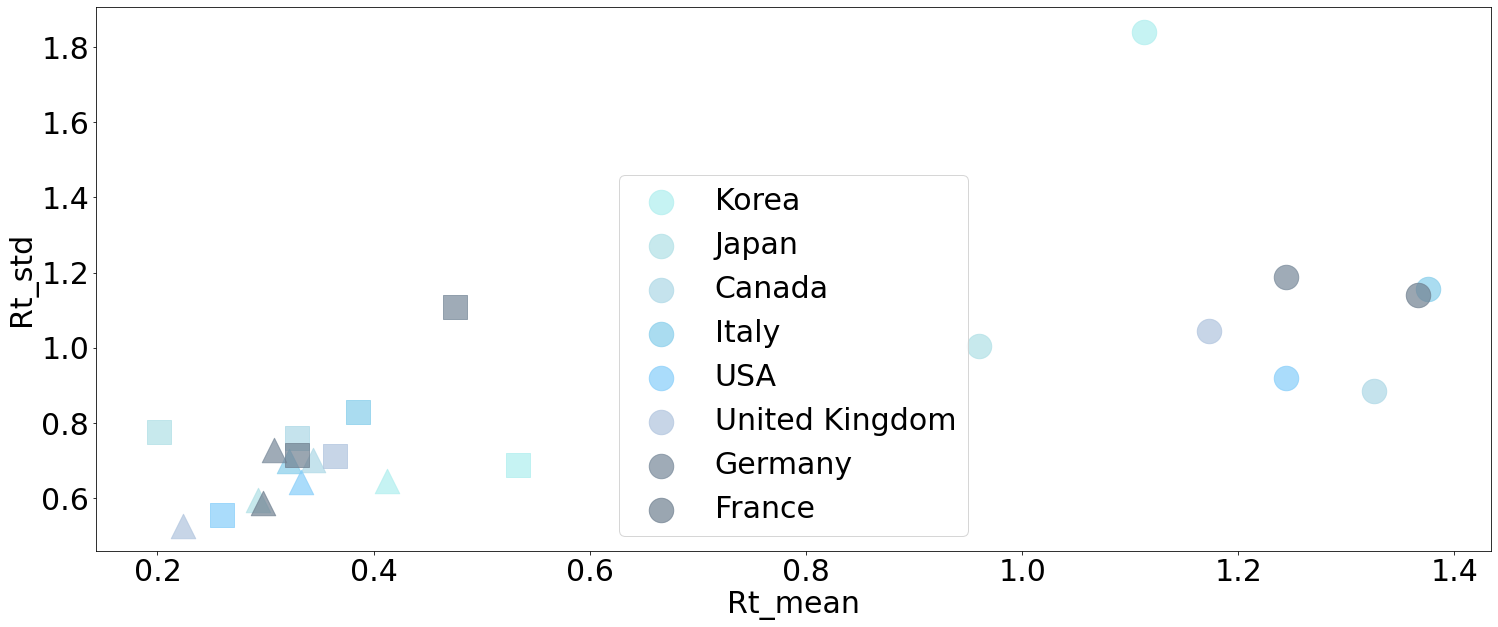

In [ ]:
fig, ax1=plt.subplots(figsize=(25,10))

x = np.linspace(-8, 8, 1000)

#### Korea ####
# total
mu_kor = np.mean(df_variants['Total_Rt'])
sigma_kor= np.std(df_variants['Total_Rt'])
plt.scatter(mu_kor, sigma_kor, alpha=0.7, s=600, label=r'Korea', color='paleturquoise')

# delta
mu_kor = np.mean(df_variants['Delta_Rt'])
sigma_kor= np.std(df_variants['Delta_Rt'])
plt.scatter(mu_kor, sigma_kor, alpha=0.7, s=600, color='paleturquoise', marker = 's')

# omicron
mu_kor = np.mean(df_variants['Omicron_Rt'])
sigma_kor= np.std(df_variants['Omicron_Rt'])
plt.scatter(mu_kor, sigma_kor, alpha=0.7, s=600, color='paleturquoise', marker = '^')


#### japan ####
# total
mu_jp = np.mean(df_japan['Total_Rt'])
sigma_jp = np.std(df_japan['Total_Rt'])
plt.scatter(mu_jp, sigma_jp, alpha=0.7, s=600, label=r'Japan', color='powderblue')

# delta
mu_jp = np.mean(df_japan['Delta_Rt'])
sigma_jp= np.std(df_japan['Delta_Rt'])
plt.scatter(mu_jp, sigma_jp, alpha=0.7, s=600, color='powderblue', marker = 's')

# omicron
mu_jp = np.mean(df_japan['Omicron_Rt'])
sigma_jp= np.std(df_japan['Omicron_Rt'])
plt.scatter(mu_jp, sigma_jp, alpha=0.7, s=600, color='powderblue', marker = '^')


#### canada ####
# total
mu_canada = np.mean(df_canada['Total_Rt'])
sigma_canada = np.std(df_canada['Total_Rt'])
plt.scatter(mu_canada, sigma_canada, alpha=0.7, s=600, label=r'Canada', color='lightblue')

# delta
mu_canada = np.mean(df_canada['Delta_Rt'])
sigma_canada= np.std(df_canada['Delta_Rt'])
plt.scatter(mu_canada, sigma_canada, alpha=0.7, s=600, color='lightblue', marker = 's')

# omicron
mu_canada = np.mean(df_canada['Omicron_Rt'])
sigma_canada= np.std(df_canada['Omicron_Rt'])
plt.scatter(mu_canada, sigma_canada, alpha=0.7, s=600, color='lightblue', marker = '^')


#### italy ####
# total
mu_italy = np.mean(df_italy['Total_Rt'])
sigma_italy = np.std(df_italy['Total_Rt'])
plt.scatter(mu_italy, sigma_italy, alpha=0.7, s=600, label=r'Italy', color='skyblue')

# delta
mu_italy = np.mean(df_italy['Delta_Rt'])
sigma_italy= np.std(df_italy['Delta_Rt'])
plt.scatter(mu_italy, sigma_italy, alpha=0.7, s=600, color='skyblue', marker = 's')

# omicron
mu_italy = np.mean(df_italy['Omicron_Rt'])
sigma_italy= np.std(df_italy['Omicron_Rt'])
plt.scatter(mu_italy, sigma_italy, alpha=0.7, s=600, color='skyblue', marker = '^')


#### USA ####
# total
mu_usa = np.mean(df_usa['Total_Rt'])
sigma_usa = np.std(df_usa['Total_Rt'])
plt.scatter(mu_usa, sigma_usa, alpha=0.7, s=600, label=r'USA', color='lightskyblue')

# delta
mu_usa = np.mean(df_usa['Delta_Rt'])
sigma_usa= np.std(df_usa['Delta_Rt'])
plt.scatter(mu_usa, sigma_usa, alpha=0.7, s=600, color='lightskyblue', marker = 's')

# omicron
mu_usa = np.mean(df_usa['Omicron_Rt'])
sigma_usa= np.std(df_usa['Omicron_Rt'])
plt.scatter(mu_usa, sigma_usa, alpha=0.7, s=600, color='lightskyblue', marker = '^')


#### United Kingdom ####
# total
mu_uk = np.mean(df_uk['Total_Rt'])
sigma_uk = np.std(df_uk['Total_Rt'])
plt.scatter(mu_uk, sigma_uk, alpha=0.7, s=600, label=r'United Kingdom', color='lightsteelblue')

# delta
mu_uk = np.mean(df_uk['Delta_Rt'])
sigma_uk= np.std(df_uk['Delta_Rt'])
plt.scatter(mu_uk, sigma_uk, alpha=0.7, s=600, color='lightsteelblue', marker = 's')

# omicron
mu_uk = np.mean(df_uk['Omicron_Rt'])
sigma_uk= np.std(df_uk['Omicron_Rt'])
plt.scatter(mu_uk, sigma_uk, alpha=0.7, s=600, color='lightsteelblue', marker = '^')


#### germany ####
# total
mu_ger = np.mean(df_ger['Total_Rt'])
sigma_ger = np.std(df_ger['Total_Rt'])
plt.scatter(mu_ger, sigma_ger, alpha=0.7, s=600, label=r'Germany', color='lightslategray')

# delta
mu_ger = np.mean(df_ger['Delta_Rt'])
sigma_ger= np.std(df_ger['Delta_Rt'])
plt.scatter(mu_ger, sigma_ger, alpha=0.7, s=600, color='lightslategray', marker = 's')

# omicron
mu_ger = np.mean(df_ger['Omicron_Rt'])
sigma_ger= np.std(df_ger['Omicron_Rt'])
plt.scatter(mu_ger, sigma_ger, alpha=0.7, s=600, color='lightslategray', marker = '^')


#### france ####
# total
mu_fra = np.mean(df_fra['Total_Rt'])
sigma_fra = np.std(df_fra['Total_Rt'])
plt.scatter(mu_fra, sigma_fra, alpha=0.7, s=600, label=r'France', color='slategray')

# delta
mu_fra = np.mean(df_fra['Delta_Rt'])
sigma_fra= np.std(df_fra['Delta_Rt'])
plt.scatter(mu_fra, sigma_fra, alpha=0.7, s=600, color='slategray', marker = 's')

# omicron
mu_fra = np.mean(df_fra['Omicron_Rt'])
sigma_fra= np.std(df_fra['Omicron_Rt'])
plt.scatter(mu_fra, sigma_fra, alpha=0.7, s=600, color='slategray', marker = '^')

plt.xlabel('Rt_mean')
plt.ylabel('Rt_std')
plt.legend()
plt.show()

###산점도2 - Rt의 mean, case의 mean

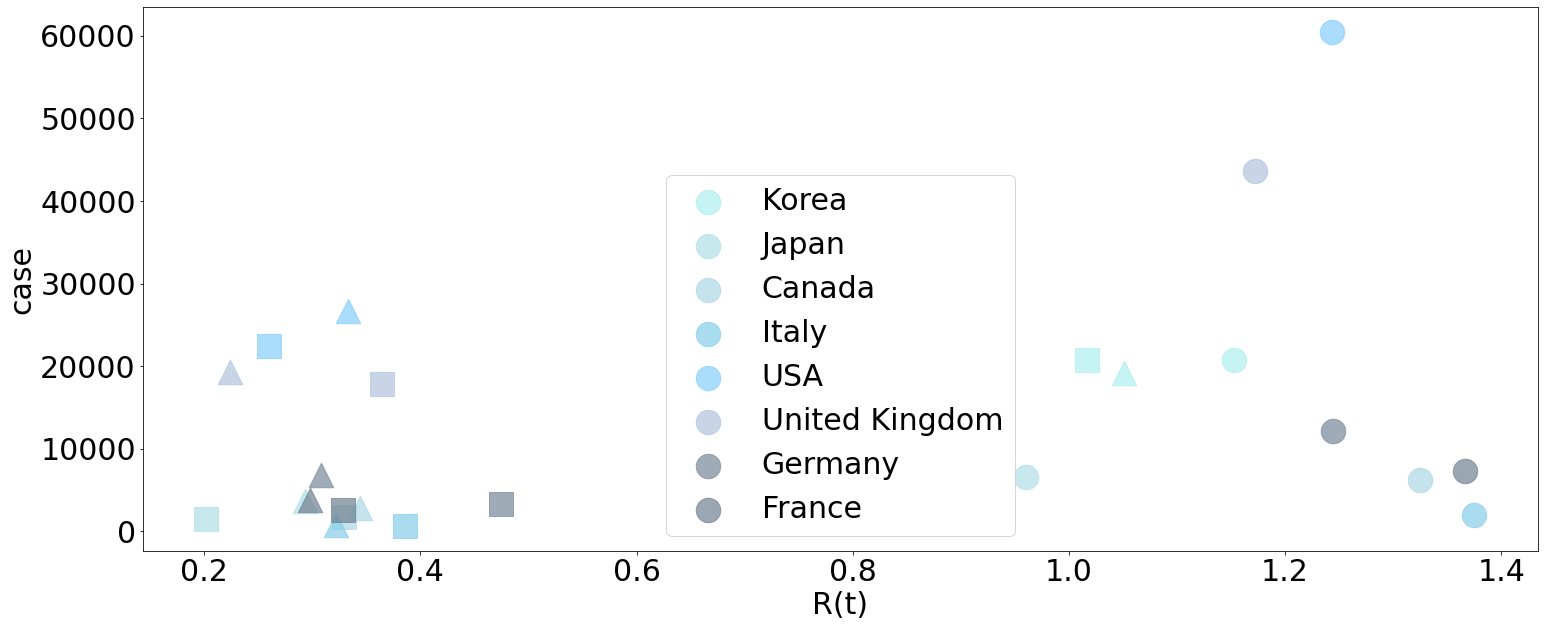

In [ ]:
fig, ax1=plt.subplots(figsize=(25,10))

#### Korea ####
# total
rt_kor = np.mean(R_rt['Total_Rt'])
case_kor= np.mean(R_case['total'])
plt.scatter(rt_kor, case_kor, alpha=0.7, s=600, label=r'Korea', color='paleturquoise')

# delta
rt_kor = np.mean(R_rt['Delta_Rt'])
sigma_kor= np.mean(R_case['Delta'])
plt.scatter(rt_kor, case_kor, alpha=0.7, s=600, color='paleturquoise', marker = 's')

# omicron
rt_kor = np.mean(R_rt['Omicron_Rt'])
case_kor= np.mean(R_case['Omicron'])
plt.scatter(rt_kor, case_kor, alpha=0.7, s=600, color='paleturquoise', marker = '^')


#### Japan ####
# total
rt_jp = np.mean(df_japan['Total_Rt'])
case_jp = np.mean(df_japan['total_sequences'])
plt.scatter(rt_jp, case_jp, alpha=0.7, s=600, label=r'Japan', color='powderblue')

# delta
rt_jp = np.mean(df_japan['Delta_Rt'])
case_jp= np.mean(df_japan['delta'])
plt.scatter(rt_jp, case_jp, alpha=0.7, s=600, color='powderblue', marker = 's')

# omicron
rt_jp = np.mean(df_japan['Omicron_Rt'])
case_jp= np.mean(df_japan['omicron'])
plt.scatter(rt_jp, case_jp, alpha=0.7, s=600, color='powderblue', marker = '^')


#### canada ####
# total
rt_canada = np.mean(df_canada['Total_Rt'])
case_canada = np.mean(df_canada['total_sequences'])
plt.scatter(rt_canada, case_canada, alpha=0.7, s=600, label=r'Canada', color='lightblue')

# delta
rt_canada = np.mean(df_canada['Delta_Rt'])
case_canada= np.mean(df_canada['delta'])
plt.scatter(rt_canada, case_canada, alpha=0.7, s=600, color='lightblue', marker = 's')

# omicron
rt_canada = np.mean(df_canada['Omicron_Rt'])
case_canada= np.mean(df_canada['omicron'])
plt.scatter(rt_canada, case_canada, alpha=0.7, s=600, color='lightblue', marker = '^')


#### italy ####
# total
rt_italy = np.mean(df_italy['Total_Rt'])
case_italy = np.mean(df_italy['total_sequences'])
plt.scatter(rt_italy, case_italy, alpha=0.7, s=600, label=r'Italy', color='skyblue')

# delta
rt_italy = np.mean(df_italy['Delta_Rt'])
case_italy= np.mean(df_italy['delta'])
plt.scatter(rt_italy, case_italy, alpha=0.7, s=600, color='skyblue', marker = 's')

# omicron
rt_italy = np.mean(df_italy['Omicron_Rt'])
case_italy= np.mean(df_italy['omicron'])
plt.scatter(rt_italy, case_italy, alpha=0.7, s=600, color='skyblue', marker = '^')


#### USA ####
# total
rt_usa = np.mean(df_usa['Total_Rt'])
case_usa = np.mean(df_usa['total_sequences'])
plt.scatter(rt_usa, case_usa, alpha=0.7, s=600, label=r'USA', color='lightskyblue')

# delta
rt_usa = np.mean(df_usa['Delta_Rt'])
case_usa= np.mean(df_usa['delta'])
plt.scatter(rt_usa, case_usa, alpha=0.7, s=600, color='lightskyblue', marker = 's')

# omicron
rt_usa = np.mean(df_usa['Omicron_Rt'])
case_usa= np.mean(df_usa['omicron'])
plt.scatter(rt_usa, case_usa, alpha=0.7, s=600, color='lightskyblue', marker = '^')


#### United Kingdom ####
# total
rt_uk = np.mean(df_uk['Total_Rt'])
case_uk = np.mean(df_uk['total_sequences'])
plt.scatter(rt_uk, case_uk, alpha=0.7, s=600, label=r'United Kingdom', color='lightsteelblue')

# delta
rt_uk = np.mean(df_uk['Delta_Rt'])
case_uk= np.mean(df_uk['delta'])
plt.scatter(rt_uk, case_uk, alpha=0.7, s=600, color='lightsteelblue', marker = 's')

# omicron
rt_uk = np.mean(df_uk['Omicron_Rt'])
case_uk= np.mean(df_uk['omicron'])
plt.scatter(rt_uk, case_uk, alpha=0.7, s=600, color='lightsteelblue', marker = '^')


#### germany ####
# total
rt_ger = np.mean(df_ger['Total_Rt'])
case_ger = np.mean(df_ger['total_sequences'])
plt.scatter(rt_ger, case_ger, alpha=0.7, s=600, label=r'Germany', color='lightslategray')

# delta
rt_ger = np.mean(df_ger['Delta_Rt'])
case_ger= np.mean(df_ger['delta'])
plt.scatter(rt_ger, case_ger, alpha=0.7, s=600, color='lightslategray', marker = 's')

# omicron
rt_ger = np.mean(df_ger['Omicron_Rt'])
case_ger= np.mean(df_ger['omicron'])
plt.scatter(rt_ger, case_ger, alpha=0.7, s=600, color='lightslategray', marker = '^')


#### france ####
# total
rt_fra = np.mean(df_fra['Total_Rt'])
case_fra = np.mean(df_fra['total_sequences'])
plt.scatter(rt_fra, case_fra, alpha=0.7, s=600, label=r'France', color='slategray')

# delta
rt_fra = np.mean(df_fra['Delta_Rt'])
case_fra= np.mean(df_fra['delta'])
plt.scatter(rt_fra, case_fra, alpha=0.7, s=600, color='slategray', marker = 's')

# omicron
rt_fra = np.mean(df_fra['Omicron_Rt'])
case_fra= np.mean(df_fra['omicron'])
plt.scatter(rt_fra, case_fra, alpha=0.7, s=600, color='slategray', marker = '^')


plt.xlabel('R(t)')
plt.ylabel('case')
plt.legend()
plt.show()

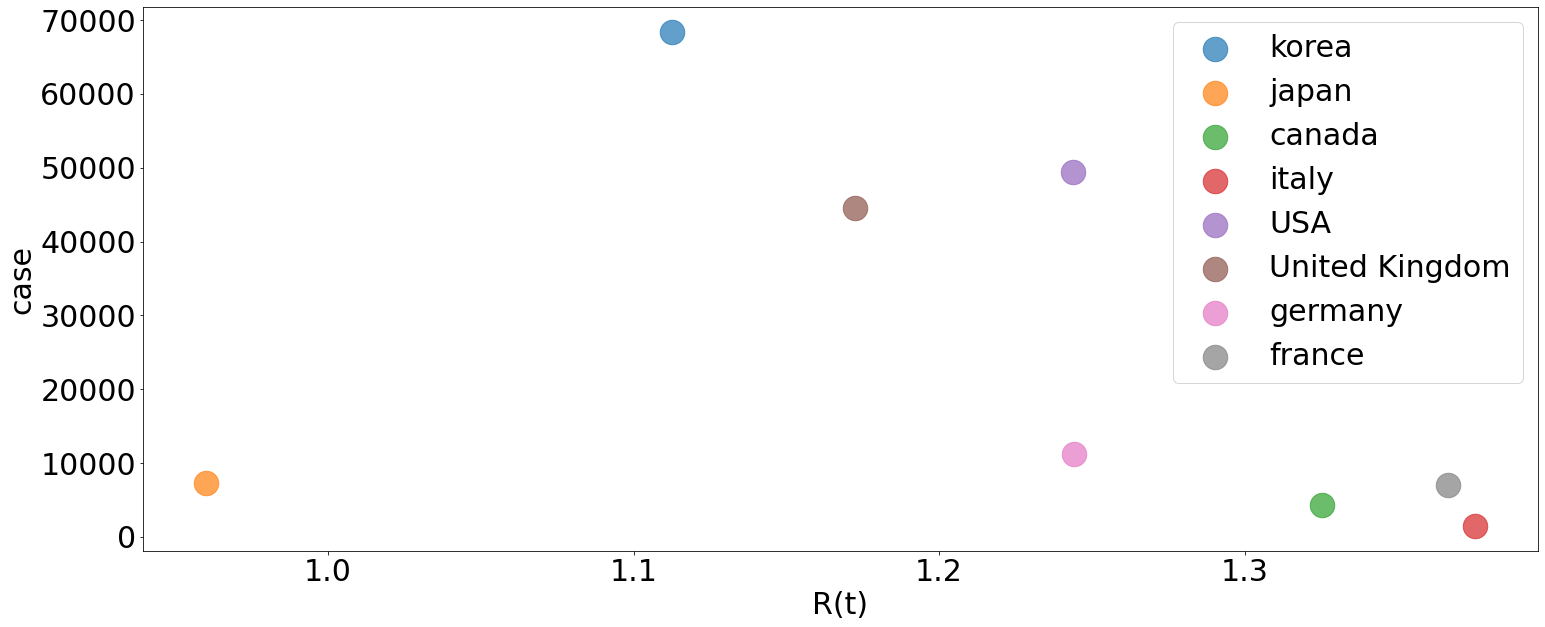

In [ ]:
fig, ax1=plt.subplots(figsize=(25,10))

# korea
rt_kor = np.mean(df_variants['Total_Rt'])
case_kor= np.std(df_variants['total'])
plt.scatter(rt_kor, case_kor, alpha=0.7, s=600, label=r'korea')

# japan
rt_jp = np.mean(df_japan['Total_Rt'])
case_jp = np.std(df_japan['total_sequences'])
plt.scatter(rt_jp, case_jp, alpha=0.7, s=600, label=r'japan')

# canada
rt_canada = np.mean(df_canada['Total_Rt'])
case_canada = np.std(df_canada['total_sequences'])
plt.scatter(rt_canada, case_canada, alpha=0.7, s=600, label=r'canada')

# italy
rt_italy = np.mean(df_italy['Total_Rt'])
case_italy = np.std(df_italy['total_sequences'])
plt.scatter(rt_italy, case_italy, alpha=0.7, s=600, label=r'italy')

# USA
rt_usa = np.mean(df_usa['Total_Rt'])
case_usa = np.std(df_usa['total_sequences'])
plt.scatter(rt_usa, case_usa, alpha=0.7, s=600, label=r'USA')

# United Kingdom
rt_uk = np.mean(df_uk['Total_Rt'])
case_uk = np.std(df_uk['total_sequences'])
plt.scatter(rt_uk, case_uk, alpha=0.7, s=600, label=r'United Kingdom')

# germany
rt_ger = np.mean(df_ger['Total_Rt'])
case_ger = np.std(df_ger['total_sequences'])
plt.scatter(rt_ger, case_ger, alpha=0.7, s=600, label=r'germany')

# france
rt_fra = np.mean(df_fra['Total_Rt'])
case_fra = np.std(df_fra['total_sequences'])
plt.scatter(rt_fra, case_fra, alpha=0.7, s=600, label=r'france')

plt.xlabel('R(t)')
plt.ylabel('case')
plt.legend()
plt.show()

###산점도3 - Rt의 mean, case의 합

In [ ]:
# 한국 해외와 날짜 기준이 달라서 바꿔줌
R_case=R_case.set_index(df_variants.index)
R_case

Delta  Omicron  others  total
2020-01-30      1        1       1      1
2020-01-31      1        1       3      3
2020-02-01      0        0       0      0
2020-02-02      1        1       1      1
2020-02-03      0        0       0      0
...           ...      ...     ...    ...
2022-07-01      0     9382       0   9382
2022-07-02      0    10542       0  10542
2022-07-03      0     9868       0   9868
2022-07-04      0     6089       0   6089
2022-07-05      0    17976       0  17976

[888 rows x 4 columns]

In [ ]:
df_case = R_case.loc['2020-04-27':].resample('14D').mean()
df_case

Delta        Omicron      others          total
2020-04-27     0.642857       0.642857    4.142857       4.142857
2020-05-11     1.071429       1.000000   16.500000      16.500000
2020-05-25     1.642857       1.000000   36.142857      36.142857
2020-06-08     1.714286       1.000000   35.857143      35.857143
2020-06-22     2.428571       1.000000   31.214286      31.214286
2020-07-06     4.214286       1.000000   19.785714      19.785714
2020-07-20     6.571429       1.000000   16.000000      16.000000
2020-08-03    37.642857       1.428571   53.500000      53.500000
2020-08-17   256.285714       4.642857  300.785714     300.785714
2020-08-31   155.785714       2.785714  163.357143     163.357143
2020-09-14    88.928571       1.785714   89.642857      89.642857
2020-09-28    57.500000       1.142857   57.500000      57.500000
2020-10-12    69.000000       1.214286   69.000000      69.000000
2020-10-26    92.571429       1.785714   92.642857      92.642857
2020-11-09   202.071429       3.357143  202.142857     202.142857
2020-11-23   465.071429       5.500000  465.142857     465.142857
2020-12-07   838.214286       3.071429  838.714286     838.714286
2020-12-21   929.642857      14.071429  942.500000     942.500000
2021-01-04   526.714286      50.142857  571.142857     617.000000
2021-01-18   270.500000     101.857143  386.857143     391.357143
2021-02-01    75.214286     277.928571  352.142857     352.142857
2021-02-15     9.571429     405.642857  414.214286     414.214286
2021-03-01     2.357143     406.785714  407.285714     407.285714
2021-03-15     4.142857     396.285714  419.642857     419.928571
2021-03-29     1.500000     537.571429  537.428571     537.714286
2021-04-12     3.071429     640.714286  637.857143     640.714286
2021-04-26    16.785714     575.500000  559.571429     575.500000
2021-05-10    13.428571     592.071429  579.428571     592.071429
2021-05-24    24.500000     568.285714  544.714286     568.285714
2021-06-07    55.714286     472.928571  418.142857     472.928571
2021-06-21   190.357143     593.428571  404.000000     593.428571
2021-07-05   688.857143    1222.857143  535.000000    1222.857143
2021-07-19  1114.714286    1045.214286  370.357143    1484.071429
2021-08-02  1558.214286       0.000000  106.285714    1663.500000
2021-08-16  1663.928571       0.000000   50.928571    1713.857143
2021-08-30  1699.571429       0.000000   10.571429    1708.785714
2021-09-13  1981.714286       0.000000   10.285714    1985.142857
2021-09-27  2136.285714       0.000000    7.428571    2140.500000
2021-10-11  1437.928571       0.000000    4.714286    1438.428571
2021-10-25  1980.857143       0.000000    6.571429    1982.357143
2021-11-08  2515.285714       0.500000    7.857143    2515.714286
2021-11-22  4061.642857      28.428571   12.357143    4089.428571
2021-12-06  6373.428571     169.571429   19.571429    6542.000000
2021-12-20  4384.785714     810.500000   15.428571    5194.285714
2022-01-03  1433.428571    2093.285714    6.928571    3525.714286
2022-01-17   437.357143    9042.357143    1.000000    9478.714286
2022-01-31   134.357143   36997.357143    1.000000   37130.928571
2022-02-14   200.000000  117108.000000    1.000000  117307.785714
2022-02-28   134.357143  244229.500000    0.000000  254325.428571
2022-03-14     0.000000  347391.500000    0.000000  375641.571429
2022-03-28     0.000000  228382.285714    0.000000  251289.000000
2022-04-11     0.000000  111523.071429    0.000000  111523.071429
2022-04-25     0.000000   46362.142857    0.000000   46362.142857
2022-05-09     0.000000   29512.857143    0.000000   29512.857143
2022-05-23     0.000000   14682.428571    0.000000   14682.428571
2022-06-06     0.000000    8001.428571    0.000000    8001.428571
2022-06-20     0.000000    7956.642857    0.000000    7956.642857
2022-07-04     0.000000   12032.500000    0.000000   12032.500000

In [ ]:
df_canada['delta']=df_canada['delta'].replace(0,np.nan)
df_canada['omicron']=df_canada['omicron'].replace(0,np.nan)
canada_delta=df_canada[['delta','Delta_Rt']].dropna()
canada_omicron=df_canada[['omicron','Omicron_Rt']].dropna()

In [ ]:
df_uk['delta']=df_fra['delta'].replace(0,np.nan)
df_uk['omicron']=df_uk['omicron'].replace(0,np.nan)
uk_delta=df_uk[['delta','Delta_Rt']].dropna()
uk_omicron=df_uk[['omicron','Omicron_Rt']].dropna()

In [ ]:
df_fra['delta']=df_fra['delta'].replace(0,np.nan)
df_fra['omicron']=df_fra['omicron'].replace(0,np.nan)
fra_delta=df_fra[['delta','Delta_Rt']].dropna()
fra_omicron=df_fra[['omicron','Omicron_Rt']].dropna()

In [ ]:
print('국내')
print(np.mean(R_rt['Total_Rt']))
print(np.mean(R_rt['Delta_Rt']))
print(np.mean(R_rt['Omicron_Rt']))

print('캐나다')
print(np.mean(df_canada['Total_Rt']))
print(np.mean(canada_delta['Delta_Rt']))
print(np.mean(canada_omicron['Omicron_Rt']))

print('영국')
print(np.mean(df_uk['Total_Rt']))
print(np.mean(uk_delta['Delta_Rt']))
print(np.mean(uk_omicron['Omicron_Rt']))

print('프랑스')
print(np.mean(df_fra['Total_Rt']))
print(np.mean(fra_delta['Delta_Rt']))
print(np.mean(fra_omicron['Omicron_Rt']))

국내
1.1528347705738788
1.017001483774286
1.0506530080705534
캐나다
1.3251428624911807
0.6480753097895144
0.9035574748333239
영국
1.1725446284332846
0.6041830271337436
0.5870756568187535
프랑스
1.3663876088023188
0.545213631943927
0.7820561877677323


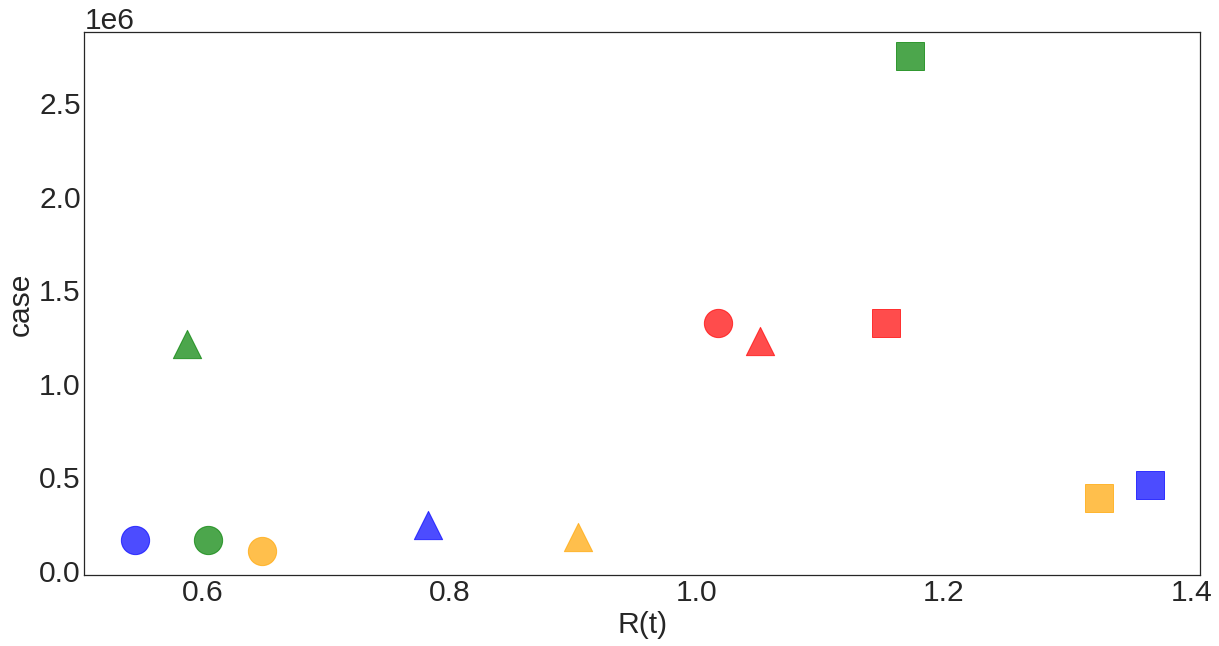

In [ ]:
fig, ax1=plt.subplots(figsize=(20,10))

#### Korea ####
# total
rt_kor = np.mean(R_rt['Total_Rt'])
case_kor= np.sum(df_case['total'])
plt.scatter(rt_kor, case_kor, alpha=0.7, s=800, label=r'Korea', color='red', marker = 's')
#plt.text(rt_kor, case_kor, 'Korea_total',fontdict={'weight': 'bold', 'size': 15})

# delta
rt_kor = np.mean(R_rt['Delta_Rt'])
sigma_kor= np.sum(df_case['Delta'])
plt.scatter(rt_kor, case_kor, alpha=0.7, s=800, color='red')
#plt.text(rt_kor, case_kor, 'Korea_delta',fontdict={'weight': 'bold', 'size': 15})

# omicron
rt_kor = np.mean(R_rt['Omicron_Rt'])
case_kor= np.sum(df_case['Omicron'])
plt.scatter(rt_kor, case_kor, alpha=0.7, s=800, color='red', marker = '^')
#plt.text(rt_kor, case_kor, 'Korea_omicron',fontdict={'weight': 'bold', 'size': 15})


#### canada ####
# total
rt_canada = np.mean(df_canada['Total_Rt'])
case_canada = np.sum(df_canada['total_sequences'])
plt.scatter(rt_canada, case_canada, alpha=0.7, s=800, label=r'Canada', color='orange', marker = 's')
#plt.text(rt_canada, case_canada, 'Canada_Total',fontdict={'weight': 'bold', 'size': 15})

# delta
rt_canada = np.mean(canada_delta['Delta_Rt'])
case_canada= np.sum(canada_delta['delta'])
plt.scatter(rt_canada, case_canada, alpha=0.7, s=800, color='orange')
#plt.text(rt_canada, case_canada, 'Canada_Delta',fontdict={'weight': 'bold', 'size': 15})

# omicron
rt_canada = np.mean(canada_omicron['Omicron_Rt'])
case_canada= np.sum(canada_omicron['omicron'])
plt.scatter(rt_canada, case_canada, alpha=0.7, s=800, color='orange', marker = '^')
#plt.text(rt_canada, case_canada, 'Canada_Omicron',fontdict={'weight': 'bold', 'size': 15})


#### United Kingdom ####
# total
rt_uk = np.mean(df_uk['Total_Rt'])
case_uk = np.sum(df_uk['total_sequences'])
plt.scatter(rt_uk, case_uk, alpha=0.7, s=800, label=r'United Kingdom', color='green', marker = 's')
#plt.text(rt_uk, case_uk, 'United Kingdom_Total',fontdict={'weight': 'bold', 'size': 15})

# delta
rt_uk = np.mean(uk_delta['Delta_Rt'])
case_uk= np.sum(uk_delta['delta'])
plt.scatter(rt_uk, case_uk, alpha=0.7, s=800, color='green')
#plt.text(rt_uk, case_uk, 'United Kingdom_Delta',fontdict={'weight': 'bold', 'size': 15})

# omicron
rt_uk = np.mean(uk_omicron['Omicron_Rt'])
case_uk= np.sum(uk_omicron['omicron'])
plt.scatter(rt_uk, case_uk, alpha=0.7, s=800, color='green', marker = '^')
#plt.text(rt_uk, case_uk, 'United Kingdom_Omicron',fontdict={'weight': 'bold', 'size': 15})


#### france ####
# total
rt_fra = np.mean(df_fra['Total_Rt'])
case_fra = np.sum(df_fra['total_sequences'])
plt.scatter(rt_fra, case_fra, alpha=0.7, s=800, label=r'France', color='blue', marker = 's')
#plt.text(rt_fra, case_fra, 'France_Total',fontdict={'weight': 'bold', 'size': 15})

# delta
rt_fra = np.mean(fra_delta['Delta_Rt'])
case_fra= np.sum(fra_delta['delta'])
plt.scatter(rt_fra, case_fra, alpha=0.7, s=800, color='blue')
#plt.text(rt_fra, case_fra, 'France_Delta',fontdict={'weight': 'bold', 'size': 15})

# omicron
rt_fra = np.mean(fra_omicron['Omicron_Rt'])
case_fra= np.sum(fra_omicron['omicron'])
plt.scatter(rt_fra, case_fra, alpha=0.7, s=800, color='blue', marker = '^')
#plt.text(rt_fra, case_fra, 'France_Omicron',fontdict={'weight': 'bold', 'size': 15})


plt.xlabel('R(t)')
plt.ylabel('case')
plt.show()

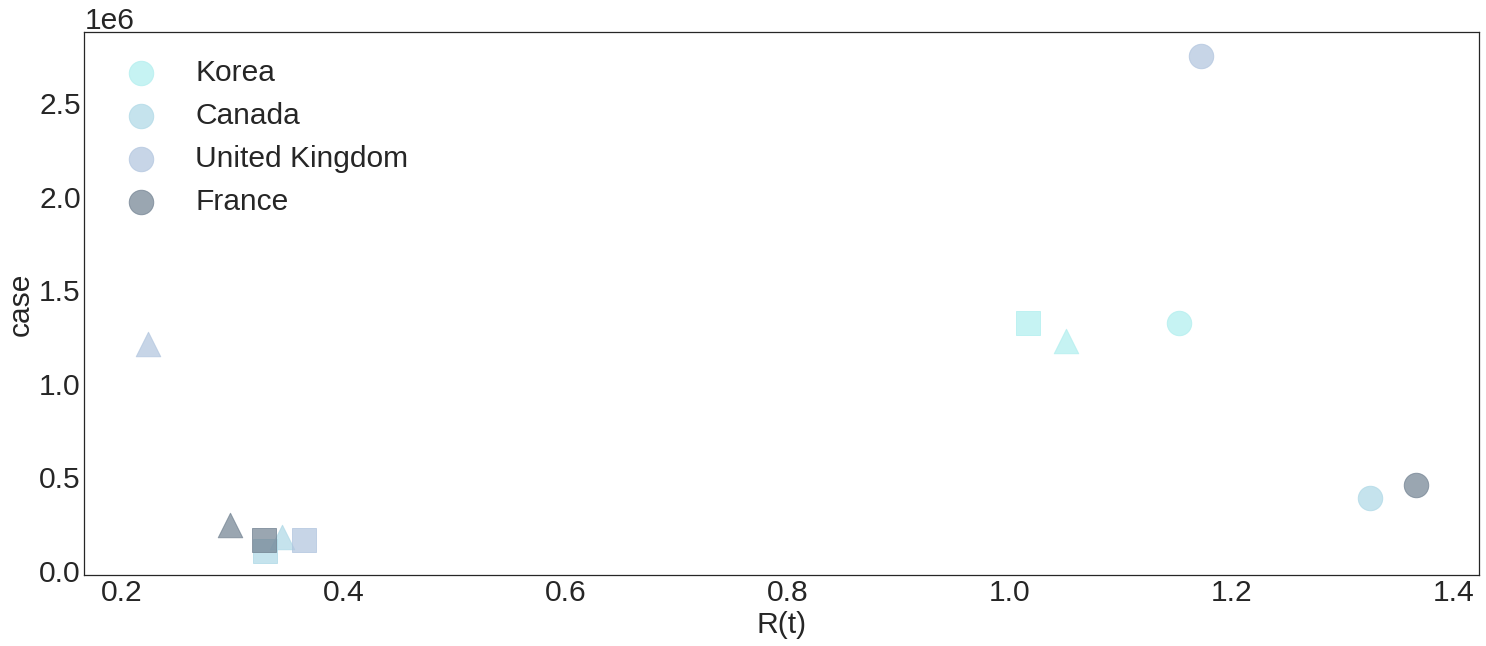

In [ ]:
fig, ax1=plt.subplots(figsize=(25,10))

#### Korea ####
# total
rt_kor = np.mean(R_rt['Total_Rt'])
case_kor= np.sum(df_case['total'])
plt.scatter(rt_kor, case_kor, alpha=0.7, s=600, label=r'Korea', color='paleturquoise')
#plt.text(rt_kor, case_kor, 'Korea_total',fontdict={'weight': 'bold', 'size': 15})

# delta
rt_kor = np.mean(R_rt['Delta_Rt'])
sigma_kor= np.sum(df_case['Delta'])
plt.scatter(rt_kor, case_kor, alpha=0.7, s=600, color='paleturquoise', marker = 's')
#plt.text(rt_kor, case_kor, 'Korea_delta',fontdict={'weight': 'bold', 'size': 15})

# omicron
rt_kor = np.mean(R_rt['Omicron_Rt'])
case_kor= np.sum(df_case['Omicron'])
plt.scatter(rt_kor, case_kor, alpha=0.7, s=600, color='paleturquoise', marker = '^')
#plt.text(rt_kor, case_kor, 'Korea_omicron',fontdict={'weight': 'bold', 'size': 15})


#### canada ####
# total
rt_canada = np.mean(df_canada['Total_Rt'])
case_canada = np.sum(df_canada['total_sequences'])
plt.scatter(rt_canada, case_canada, alpha=0.7, s=600, label=r'Canada', color='lightblue')
#plt.text(rt_canada, case_canada, 'Canada_Total',fontdict={'weight': 'bold', 'size': 15})

# delta
rt_canada = np.mean(df_canada['Delta_Rt'])
case_canada= np.sum(df_canada['delta'])
plt.scatter(rt_canada, case_canada, alpha=0.7, s=600, color='lightblue', marker = 's')
#plt.text(rt_canada, case_canada, 'Canada_Delta',fontdict={'weight': 'bold', 'size': 15})

# omicron
rt_canada = np.mean(df_canada['Omicron_Rt'])
case_canada= np.sum(df_canada['omicron'])
plt.scatter(rt_canada, case_canada, alpha=0.7, s=600, color='lightblue', marker = '^')
#plt.text(rt_canada, case_canada, 'Canada_Omicron',fontdict={'weight': 'bold', 'size': 15})


#### United Kingdom ####
# total
rt_uk = np.mean(df_uk['Total_Rt'])
case_uk = np.sum(df_uk['total_sequences'])
plt.scatter(rt_uk, case_uk, alpha=0.7, s=600, label=r'United Kingdom', color='lightsteelblue')
#plt.text(rt_uk, case_uk, 'United Kingdom_Total',fontdict={'weight': 'bold', 'size': 15})

# delta
rt_uk = np.mean(df_uk['Delta_Rt'])
case_uk= np.sum(df_uk['delta'])
plt.scatter(rt_uk, case_uk, alpha=0.7, s=600, color='lightsteelblue', marker = 's')
#plt.text(rt_uk, case_uk, 'United Kingdom_Delta',fontdict={'weight': 'bold', 'size': 15})

# omicron
rt_uk = np.mean(df_uk['Omicron_Rt'])
case_uk= np.sum(df_uk['omicron'])
plt.scatter(rt_uk, case_uk, alpha=0.7, s=600, color='lightsteelblue', marker = '^')
#plt.text(rt_uk, case_uk, 'United Kingdom_Omicron',fontdict={'weight': 'bold', 'size': 15})


#### france ####
# total
rt_fra = np.mean(df_fra['Total_Rt'])
case_fra = np.sum(df_fra['total_sequences'])
plt.scatter(rt_fra, case_fra, alpha=0.7, s=600, label=r'France', color='slategray')
#plt.text(rt_fra, case_fra, 'France_Total',fontdict={'weight': 'bold', 'size': 15})

# delta
rt_fra = np.mean(df_fra['Delta_Rt'])
case_fra= np.sum(df_fra['delta'])
plt.scatter(rt_fra, case_fra, alpha=0.7, s=600, color='slategray', marker = 's')
#plt.text(rt_fra, case_fra, 'France_Delta',fontdict={'weight': 'bold', 'size': 15})

# omicron
rt_fra = np.mean(df_fra['Omicron_Rt'])
case_fra= np.sum(df_fra['omicron'])
plt.scatter(rt_fra, case_fra, alpha=0.7, s=600, color='slategray', marker = '^')
#plt.text(rt_fra, case_fra, 'France_Omicron',fontdict={'weight': 'bold', 'size': 15})


plt.xlabel('R(t)')
plt.ylabel('case')
plt.legend()
plt.show()

In [ ]:
# df_case.to_excel('korea_14days.xlsx', sheet_name='Korea', index=False)

###frequenct plot - 히스토그램

####density plot 없는 것

In [ ]:
def result_3_1(x,y,data,country): # (x,y):subplot의 위치, data : 사용되는 데이터, country : 나라 이름
  axes[x][y].hist(data['Total_Rt'], alpha = 0.4, bins = 15)

  axes[x][y].set_xlabel('R(t)')
  axes[x][y].set_ylabel('count')
  axes[x][y].set_title(country, fontsize=50)

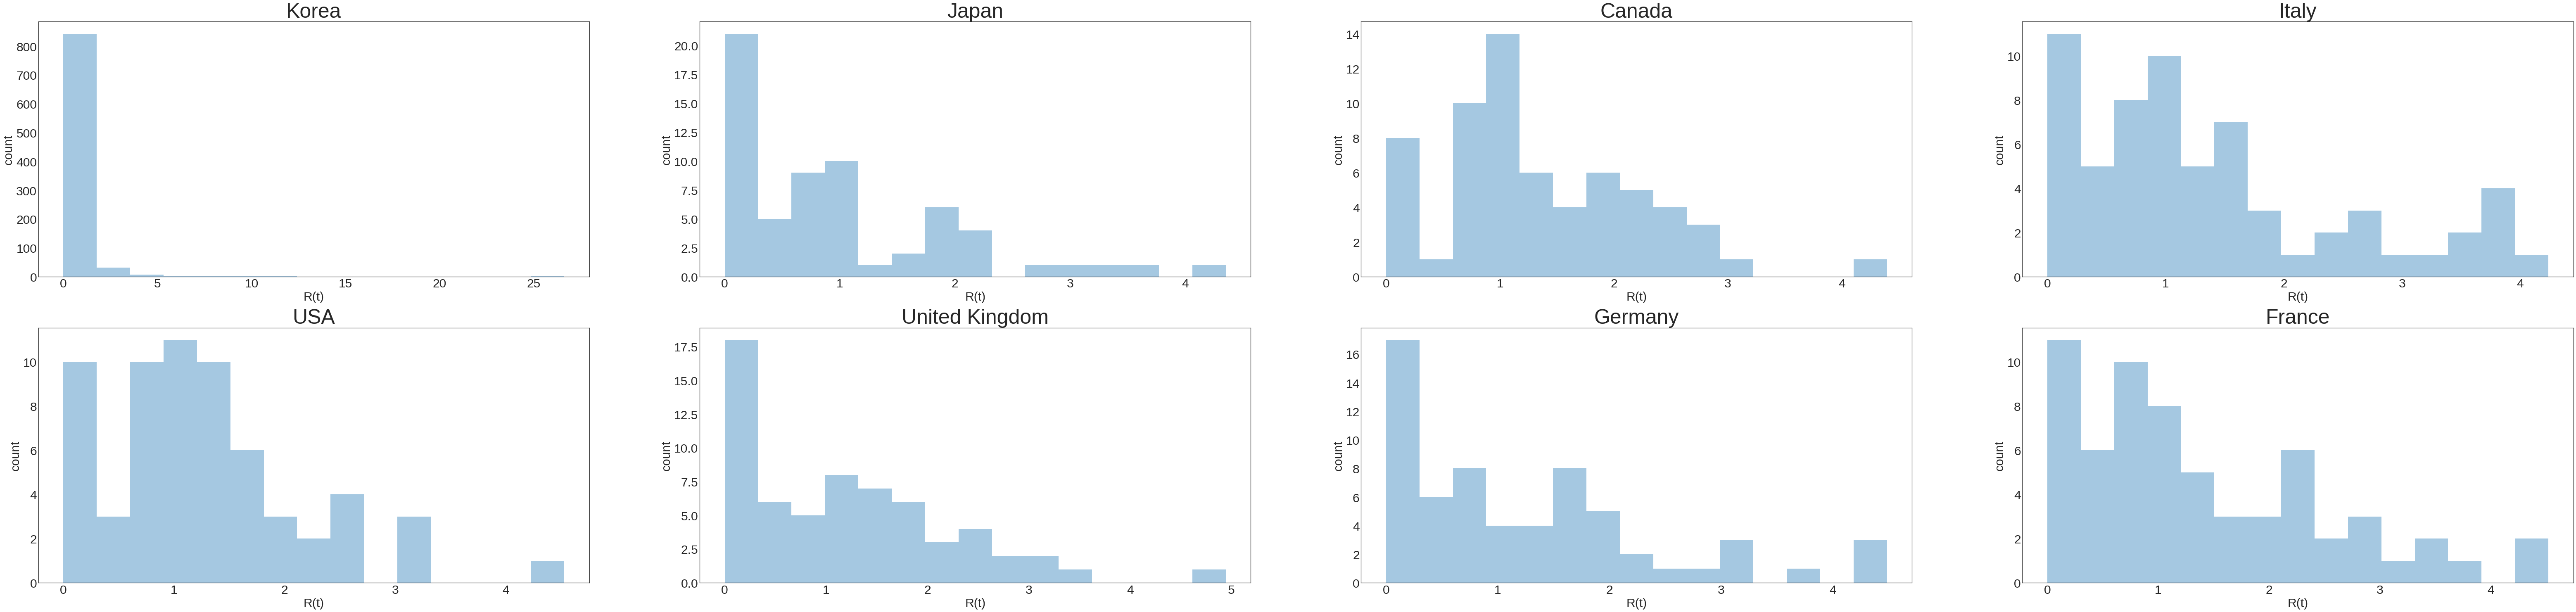

In [ ]:
pd.set_option('mode.chained_assignment',  None)
f, axes = plt.subplots(2, 4)
f.set_size_inches((110, 25))

#### Korea ####
result_3_1(0,0,R_rt,'Korea')

#### Japan ####
result_3_1(0,1,df_japan,'Japan')

#### Canada ####
result_3_1(0,2,df_canada,'Canada')

#### Italy ####
result_3_1(0,3,df_italy,'Italy')

#### USA ####
result_3_1(1,0,df_usa,'USA')

#### United Kingdom ####
result_3_1(1,1,df_uk,'United Kingdom')

#### Germany ####
result_3_1(1,2,df_ger,'Germany')

#### France ####
result_3_1(1,3,df_fra,'France')

plt.show()

####density plot 있는 것

Text(0.5, 1.0, 'France')

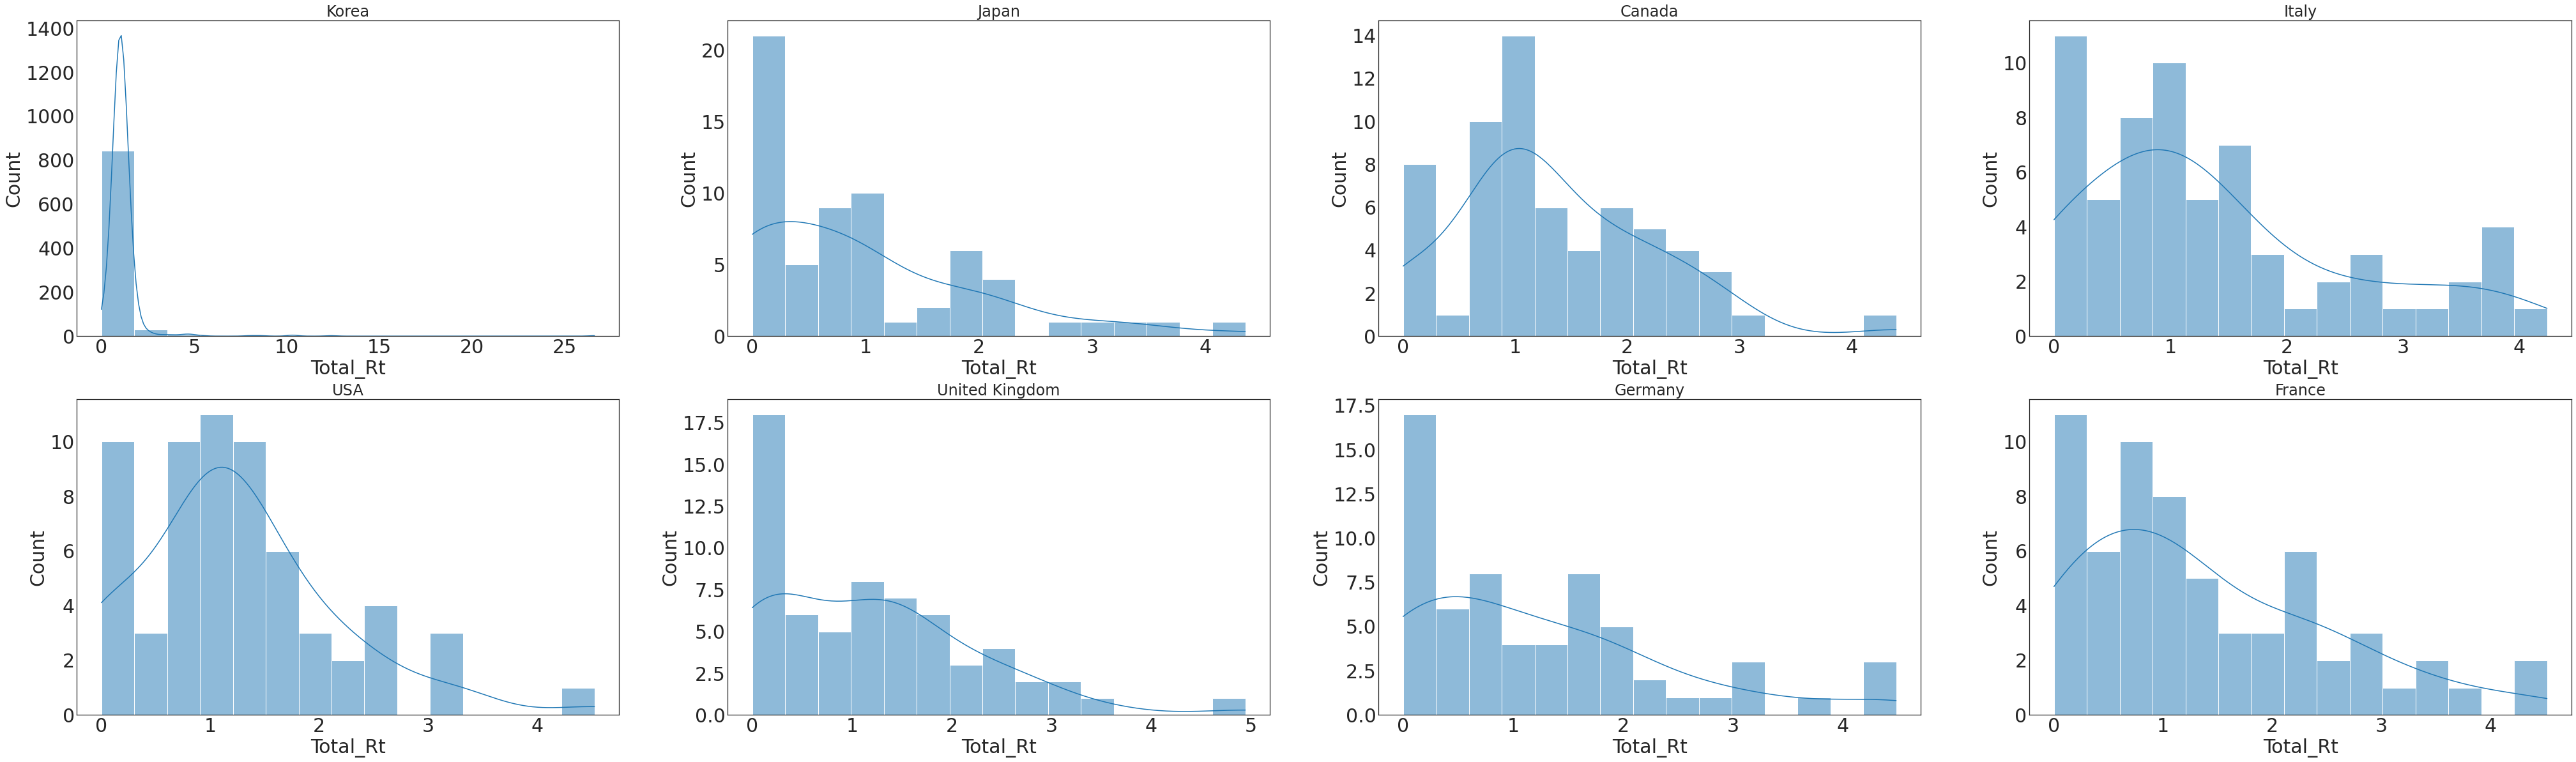

In [ ]:
sns.set_style("white")
#sns.set(font_scale=2)
fig=plt.figure(figsize=(70,20))

ax1=fig.add_subplot(2,4,1)
sns.histplot(data=R_rt['Total_Rt'],kde=True, bins=15, ax=ax1)
ax1.set_title('Korea')

ax2=fig.add_subplot(2,4,2)
sns.histplot(data=df_japan['Total_Rt'],kde=True, bins=15, ax=ax2)
ax2.set_title('Japan')

ax3=fig.add_subplot(2,4,3)
sns.histplot(data=df_canada['Total_Rt'],kde=True, bins=15, ax=ax3)
ax3.set_title('Canada')

ax4=fig.add_subplot(2,4,4)
sns.histplot(data=df_italy['Total_Rt'],kde=True, bins=15, ax=ax4)
ax4.set_title('Italy')

ax5=fig.add_subplot(2,4,5)
sns.histplot(data=df_usa['Total_Rt'],kde=True, bins=15, ax=ax5)
ax5.set_title('USA')

ax6=fig.add_subplot(2,4,6)
sns.histplot(data=df_uk['Total_Rt'],kde=True, bins=15, ax=ax6)
ax6.set_title('United Kingdom')

ax7=fig.add_subplot(2,4,7)
sns.histplot(data=df_ger['Total_Rt'],kde=True, bins=15, ax=ax7)
ax7.set_title('Germany')

ax8=fig.add_subplot(2,4,8)
sns.histplot(data=df_fra['Total_Rt'],kde=True, bins=15, ax=ax8)
ax8.set_title('France')

###히트맵

In [ ]:
# Korea 14일 간격으로 변경
df_resample = df_variants['Total_Rt'].loc['2020-04-27':].resample('14D').mean()
df_resample

2020-04-27    1.415127
2020-05-11    1.097271
2020-05-25    1.432433
2020-06-08    1.002025
2020-06-22    1.077857
2020-07-06    0.733618
2020-07-20    0.964754
2020-08-03    2.108795
2020-08-17    1.359215
2020-08-31    0.787501
2020-09-14    0.756350
2020-09-28    0.881942
2020-10-12    1.118751
2020-10-26    1.106426
2020-11-09    1.390811
2020-11-23    1.222545
2020-12-07    1.216542
2020-12-21    0.981959
2021-01-04    0.929224
2021-01-18    0.974729
2021-02-01    0.999494
2021-02-15    1.054634
2021-03-01    1.085361
2021-03-15    1.031618
2021-03-29    1.137875
2021-04-12    1.060481
2021-04-26    0.984861
2021-05-10    1.054881
2021-05-24    1.077331
2021-06-07    0.986541
2021-06-21    1.196797
2021-07-05    1.281147
2021-07-19    1.064820
2021-08-02    1.113305
2021-08-16    1.020972
2021-08-30    1.049934
2021-09-13    1.131049
2021-09-27    0.968083
2021-10-11    0.950743
2021-10-25    1.174259
2021-11-08    1.121904
2021-11-22    1.185446
2021-12-06    1.155270
2021-12-20 

In [ ]:
world_variants=pd.DataFrame()
world_variants['Korea']=df_resample
world_variants['Japan']=df_japan.Total_Rt
world_variants['Canada']=df_canada.Total_Rt
world_variants['Italy']=df_italy.Total_Rt
world_variants['USA']=df_usa.Total_Rt
world_variants['UK']=df_uk.Total_Rt
world_variants['Germany']=df_ger.Total_Rt
world_variants['France']=df_fra.Total_Rt
world_variants

Korea     Japan    Canada     Italy       USA        UK  \
2020-04-27  1.415127  0.000000  0.000000  0.000000  0.000000  0.000000   
2020-05-11  1.097271  0.000000  0.000000  0.000000  0.000000  0.000000   
2020-05-25  1.432433  0.000000  2.987951  0.000000  0.000000  0.000000   
2020-06-08  1.002025  0.000000  1.494276  3.898476  4.527646  0.000000   
2020-06-22  1.077857  0.000000  0.620428  0.000000  3.310646  1.668451   
2020-07-06  0.733618  0.000000  1.111866  0.919330  2.545732  0.574588   
2020-07-20  0.964754  0.000000  1.544691  0.497671  1.342261  0.582607   
2020-08-03  2.108795  4.350608  2.867684  0.662806  0.933086  1.198019   
2020-08-17  1.359215  1.760243  2.889118  3.124537  0.872718  2.157727   
2020-08-31  0.787501  0.698868  2.195212  3.084351  0.845938  2.650756   
2020-09-14  0.756350  0.428916  1.902742  2.324080  1.177041  3.599231   
2020-09-28  0.881942  0.475676  2.078829  1.642599  1.359632  2.983901   
2020-10-12  1.118751  0.678351  1.833285  1.927861  1.337328  2.966892   
2020-10-26  1.106426  0.922761  2.477694  3.673417  2.148520  2.358239   
2020-11-09  1.390811  2.240881  2.331461  1.278966  1.952741  1.794601   
2020-11-23  1.222545  2.246262  2.095066  1.202763  1.559378  0.688117   
2020-12-07  1.216542  2.095091  1.774564  2.797973  2.118693  1.665364   
2020-12-21  0.981959  1.937362  1.501903  2.441312  1.497542  1.329493   
2021-01-04  0.929224  2.759281  2.181427  2.564883  2.489049  1.880768   
2021-01-18  0.974729  1.489904  1.597719  1.716244  1.698078  2.091612   
2021-02-01  0.999494  0.685916  1.228790  3.408579  1.635976  1.373208   
2021-02-15  1.054634  0.451226  1.362685  3.722624  1.232353  1.426831   
2021-03-01  1.085361  0.692142  1.780710  3.535744  1.404675  1.253340   
2021-03-15  1.031618  1.272249  2.520171  0.000000  1.764570  1.225931   
2021-03-29  1.137875  2.300944  2.346952  1.508857  2.064908  0.930424   
2021-04-12  1.060481  3.164564  2.719668  1.477995  1.764622  2.382689   
2021-04-26  0.984861  3.497146  1.806230  0.927366  1.386562  0.000000   
2021-05-10  1.054881  1.875255  1.301709  0.780161  0.859079  0.000000   
2021-05-24  1.077331  0.850656  0.757509  0.799532  1.066511  0.000000   
2021-06-07  0.986541  0.944647  1.169280  1.895049  3.293642  0.000000   
2021-06-21  1.196797  1.874554  0.942211  4.237658  0.000000  4.942931   
2021-07-05  1.281147  0.000000  1.382743  0.000000  0.000000  2.528469   
2021-07-19  1.064820  0.000000  0.000000  0.000000  0.000000  2.336839   
2021-08-02  1.113305  0.000000  0.000000  2.228071  0.000000  1.656674   
2021-08-16  1.020972  0.000000  0.000000  1.533984  2.486758  1.650852   
2021-08-30  1.049934  1.599501  2.502993  1.019999  1.878606  1.522043   
2021-09-13  1.131049  0.399488  1.013346  0.913082  1.250337  1.319083   
2021-09-27  0.968083  0.129018  1.054048  0.827399  1.055966  1.222575   
2021-10-11  0.950743  0.059806  0.827693  0.883398  0.904462  1.155598   
2021-10-25  1.174259  0.054159  0.852685  1.283166  0.975551  1.245642   
2021-11-08  1.121904  0.054212  0.829125  1.478295  1.055639  1.426996   
2021-11-22  1.185446  0.058748  0.000000  1.391228  2.415556  0.000000   
2021-12-06  1.155270  0.000000  0.000000  0.000000  0.000000  0.000000   
2021-12-20  0.946909  0.000000  0.000000  0.000000  0.000000  0.000000   
2022-01-03  1.095990  0.000000  4.397704  0.000000  0.000000  0.000000   
2022-01-17  1.526621  0.000000  1.828565  3.894094  3.065830  2.890194   
2022-01-31  1.437985  1.746989  1.234517  2.719753  1.543499  2.066562   
2022-02-14  1.389298  1.065692  0.949891  0.842278  0.680263  1.410201   
2022-02-28  1.197201  0.863764  0.774478  0.946767  0.315275  1.260277   
2022-03-14  0.980366  0.785305  1.048520  0.955288  0.324992  1.209233   
2022-03-28  0.800827  1.072505  1.155003  1.502656  0.541874  0.394987   
2022-04-11  0.795627  0.987655  1.073235  0.898671  0.835514  0.317994   
2022-04-25  0.839078  0.931775  0.915287  1.226066  1.042265  0.188714   
2022-05-09  0.91001

In [ ]:
world_variants.index.strftime('%Y-%m-%d')

Index(['2020-04-27', '2020-05-11', '2020-05-25', '2020-06-08', '2020-06-22',
       '2020-07-06', '2020-07-20', '2020-08-03', '2020-08-17', '2020-08-31',
       '2020-09-14', '2020-09-28', '2020-10-12', '2020-10-26', '2020-11-09',
       '2020-11-23', '2020-12-07', '2020-12-21', '2021-01-04', '2021-01-18',
       '2021-02-01', '2021-02-15', '2021-03-01', '2021-03-15', '2021-03-29',
       '2021-04-12', '2021-04-26', '2021-05-10', '2021-05-24', '2021-06-07',
       '2021-06-21', '2021-07-05', '2021-07-19', '2021-08-02', '2021-08-16',
       '2021-08-30', '2021-09-13', '2021-09-27', '2021-10-11', '2021-10-25',
       '2021-11-08', '2021-11-22', '2021-12-06', '2021-12-20', '2022-01-03',
       '2022-01-17', '2022-01-31', '2022-02-14', '2022-02-28', '2022-03-14',
       '2022-03-28', '2022-04-11', '2022-04-25', '2022-05-09', '2022-05-23',
       '2022-06-06', '2022-06-20', '2022-07-04'],
      dtype='object')

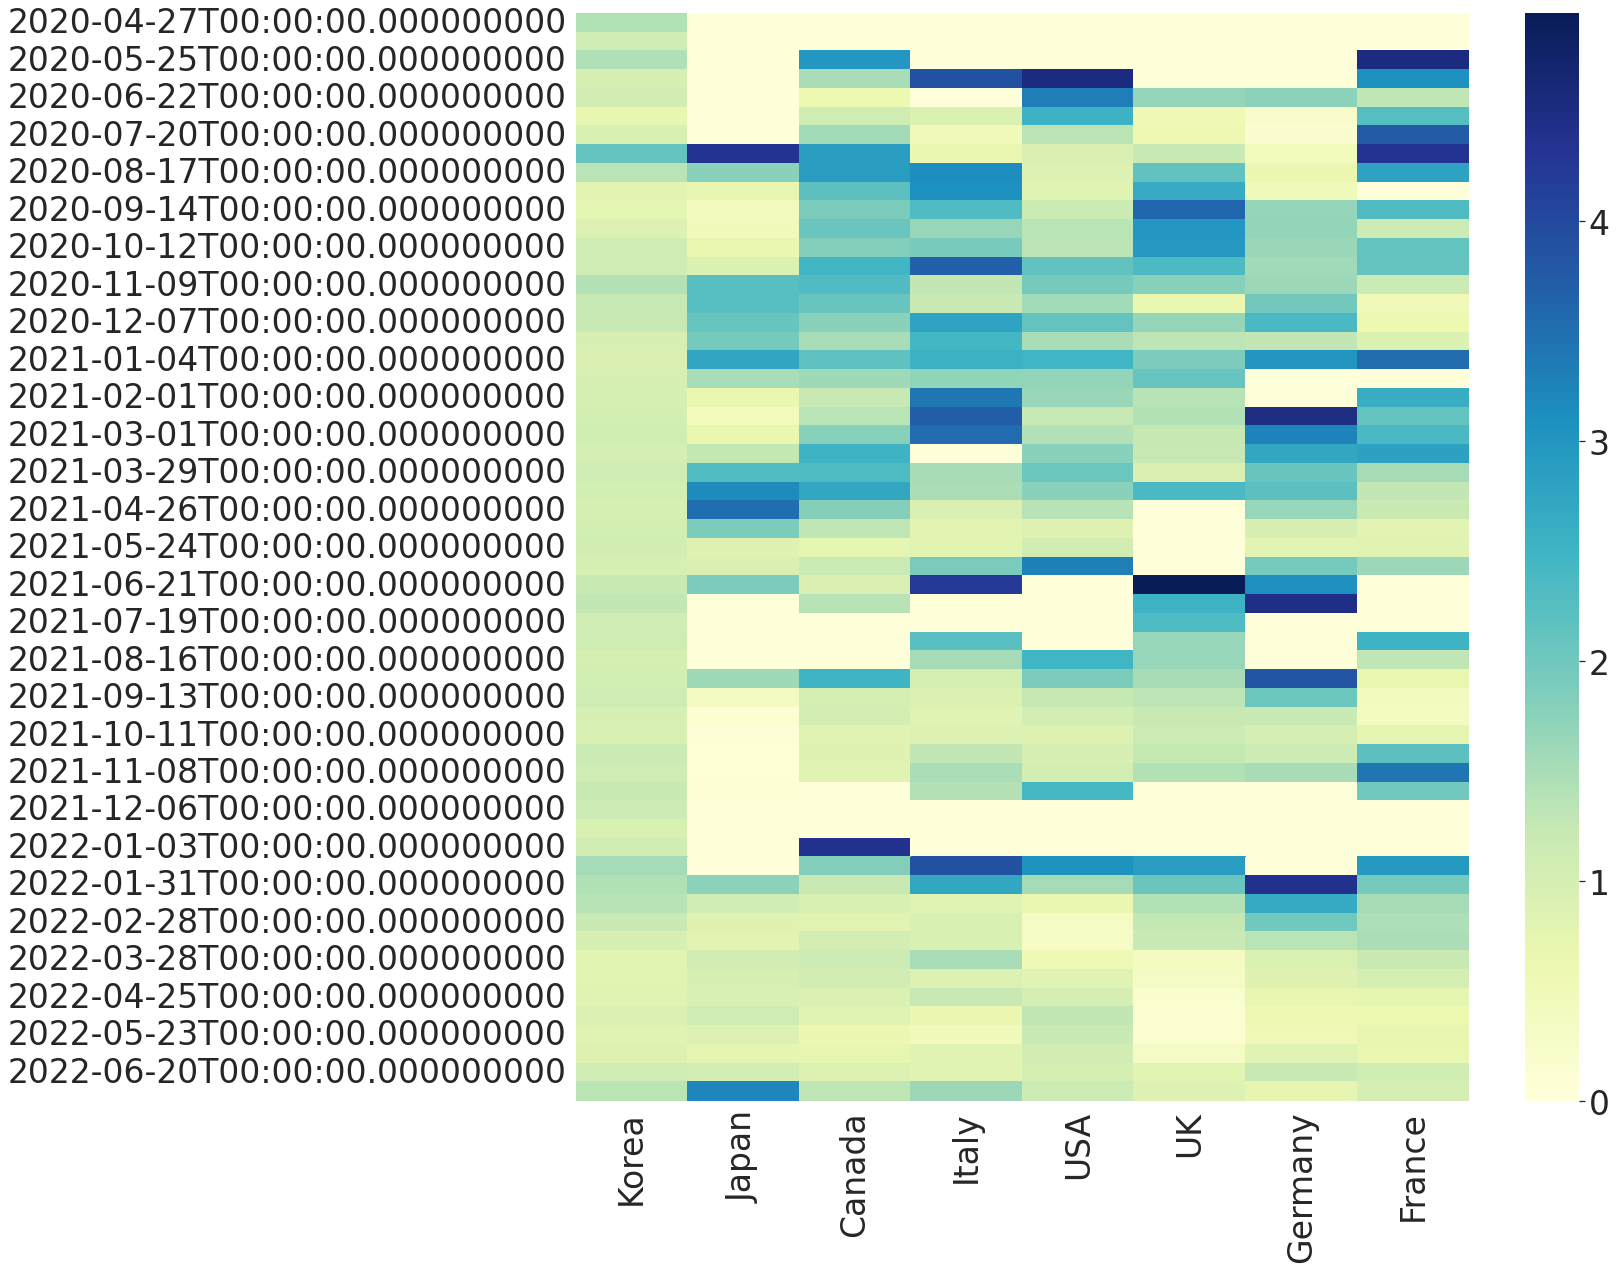

In [ ]:
import matplotlib.dates as mdates
sns.set_style("white")
#fig, ax1=plt.subplots(figsize=(20,20))
sns.set(rc={'figure.figsize':(20,20)})
sns.set(font_scale=3)
ax1=sns.heatmap(world_variants, cmap="YlGnBu")
#ax1.set_yticklabels(world_variants.index.strftime('%Y-%m-%d'))

plt.show()